<p style="color: darkred; font-size: 50px; text-align: center;"><b>Time Series Analysis</b></p>
<p style="color: darkred; font-size: 30px; text-align: center;">Forecasting Google Trends with VAR and ARIMA models</p>
<p style="font-size: 20px; text-align: center;">Joanna Misiak, Ilya Kidyshka</p>
<p style="font-size: 20px; text-align: center;">Spring 2025</p>
<p align="center">
    <img src="wne-logo-new-en.jpg" width="498" height="107" style="display: block; margin: 0 auto;">
</p>

## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
3. [Integration order and Granger causality](#integration-order-and-granger-causality)
4. [VAR model](#VAR-model)
   1. [VAR model specification](#VAR-model-specification)
   2. [VAR model estimation](#VAR-model-estimation)
   3. [VAR model diagnostics](#VAR-model-diagnostics)
   4. [VAR model forecasting](#VAR-model-forecasting)
   5. [VAR model forecasting for US](#VAR-model-forecasting-US)
   6. [VAR model forecasting for Poland](#VAR-model-forecasting-Poland)
5. [ARIMA models - Box-Jenkins procedure](#ARIMA-models)
   1. [ARIMA model identification](#ARIMA-model-identification)
   2. [ARIMA model estimation](#ARIMA-model-estimation)
   3. [ARIMA model diagnostics](#ARIMA-model-diagnostics)
   4. [ARIMA model forecasting](#ARIMA-model-forecasting)
   5. [ARIMA model comparison](#ARIMA-model-comparison)
6. [Comparison of VAR and ARIMA models](#comparison-of-VAR-and-ARIMA-models)
   1. [Evaluation metrics](#evaluation-metrics)
   2. [Model comparison](#model-comparison)
   3. [Conclusion](#conclusion)

***

## <a id="introduction"></a>Introduction

Understanding public interest in economic indicators such as mortgage and interest rates is crucial for anticipating consumer behavior, financial planning trends, and broader macroeconomic sentiments. In this project, we aim to forecast the number of Google search queries related to ***mortgage*** and ***interest rates*** using a Vector Autoregression (VAR) model and two independent univariate ARIMA models. Our goal is to assess the predictive power and mutual influence of these two search topics over time.

The theoretical motivation behind this project stems from the economic relationship between interest rates and the housing market. Typically, changes in interest rates can significantly impact mortgage rates, affecting housing affordability and, consequently, public interest in both topics. Therefore, we hypothesize that the number of Google searches for "interest rates" may Granger-cause searches for "mortgage", reflecting a public response to monetary policy changes.

To perform this analysis, we will use the historical Google Trends data for the two search terms. After ensuring the time series are stationary, we will explore whether a Granger causality exists between them and construct a VAR model to jointly forecast their future values. Additionally, we will develop two separate ARIMA models for each keyword to compare the univariate forecasting performance against the multivariate VAR approach.

This comparative analysis will help determine which modeling approach provides more accurate forecasts for public search behavior and offer insights into the interdependence of economic concerns expressed through online search patterns.

## <a id="data-loading-and-preprocessing"></a>Data Loading and Preprocessing

In [78]:
# Import necessary libraries
import pandas as pd # for data processing
import numpy as np # here mostly for series generation

import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting

import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen

import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test
from scipy.special.cython_special import betainc

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import kpss
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from IPython.display import Markdown

#import yfinance as yf # for importing data directly from finance.yahoo.com

import warnings
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")

# Set global options
pd.options.display.float_format = '{:.10f}'.format
sns.set_theme(style="whitegrid")

Since we faced a problem with *pytrends* package, we manually downloaded the data from the Google Trends website. The data contains 262 weekly observations from May 2020 to April 2025. We analyzed the series for worldwide searches, US and Poland.

In [79]:
data = pd.read_csv('TSA_project_data.csv', header=0, index_col=0, parse_dates=True, sep=';')

data.drop(columns=['Unnamed: 7', 'Unnamed: 8'], inplace=True)  # drop rolling means as they are not needed for analysis

TypeError: issubclass() arg 2 must be a class, a tuple of classes, or a union

Exception ignored in: 'pandas._libs.tslibs.parsing._maybe_warn_about_dayfirst'
Traceback (most recent call last):
  File "/Users/joannamisiak/Desktop/STUDIA/Time Series Analysis/TSA_project/.venv/lib/python3.13/site-packages/pandas/core/tools/datetimes.py", line 131, in _guess_datetime_format_for_array
    guessed_format = guess_datetime_format(
TypeError: issubclass() arg 2 must be a class, a tuple of classes, or a union


In [80]:
data.head()

mortgage_world  rates_world  mortgage_US  rates_US  \
Date                                                             
2020-05-24              81           11           82         7   
2020-05-31              80           12           80         7   
2020-06-07              85           12           84         8   
2020-06-14              85           11           91         7   
2020-06-21              85           11           83         7   

            mortgage_Poland  rates_Poland  
Date                                       
2020-05-24               32             0  
2020-05-31               38            11  
2020-06-07               39            11  
2020-06-14               37            12  
2020-06-21               44             0

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2020-05-24 to 2025-05-25
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   mortgage_world   262 non-null    int64
 1   rates_world      262 non-null    int64
 2   mortgage_US      262 non-null    int64
 3   rates_US         262 non-null    int64
 4   mortgage_Poland  262 non-null    int64
 5   rates_Poland     262 non-null    int64
dtypes: int64(6)
memory usage: 14.3 KB


In [82]:
data.describe()

mortgage_world    rates_world    mortgage_US       rates_US  \
count  262.0000000000 262.0000000000 262.0000000000 262.0000000000   
mean    63.7290076336  13.7442748092  67.4618320611   9.9541984733   
std      9.3950666809   3.7630317179   9.6682753954   3.7228971445   
min     40.0000000000   7.0000000000  40.0000000000   4.0000000000   
25%     58.0000000000  11.0000000000  61.2500000000   7.0000000000   
50%     62.0000000000  14.0000000000  66.0000000000  10.0000000000   
75%     68.0000000000  16.0000000000  73.0000000000  12.0000000000   
max    100.0000000000  30.0000000000 100.0000000000  31.0000000000   

       mortgage_Poland   rates_Poland  
count   262.0000000000 262.0000000000  
mean     57.9045801527  15.4770992366  
std      17.3192487542  10.8057318753  
min      25.0000000000   0.0000000000  
25%      45.2500000000   9.5000000000  
50%      53.0000000000  17.0000000000  
75%      71.0000000000  22.7500000000  
max     100.0000000000  53.0000000000

In [83]:
data['d_mortgage_world'] = data['mortgage_world'].diff()
data['d_rates_world'] = data['rates_world'].diff()

We will create a 6-week forecast with our estimated models.

In [84]:
forecast_horizon = 6
data_short = data.iloc[:-forecast_horizon]

In [85]:
data_short

mortgage_world  rates_world  mortgage_US  rates_US  \
Date                                                             
2020-05-24              81           11           82         7   
2020-05-31              80           12           80         7   
2020-06-07              85           12           84         8   
2020-06-14              85           11           91         7   
2020-06-21              85           11           83         7   
...                    ...          ...          ...       ...   
2025-03-16              69           15           66        13   
2025-03-23              65           13           65        10   
2025-03-30              79           17           86        14   
2025-04-06              76           19           77        16   
2025-04-13              68           15           69        12   

            mortgage_Poland  rates_Poland  d_mortgage_world  d_rates_world  
Date                                                                        
2020-05-24               32             0               NaN            NaN  
2020-05-31               38            11     -1.0000000000   1.0000000000  
2020-06-07               39            11      5.0000000000   0.0000000000  
2020-06-14               37            12      0.0000000000  -1.0000000000  
2020-06-21               44             0      0.0000000000   0.0000000000  
...                     ...           ...               ...            ...  
2025-03-16               48            32     -3.0000000000  -1.0000000000  
2025-03-23               87            20     -4.0000000000  -2.0000000000  
2025-03-30               74            22     14.0000000000   4.0000000000  
2025-04-06               68            19     -3.0000000000   2.0000000000  
2025-04-13               78            36     -8.0000000000  -4.0000000000  

[256 rows x 8 columns]

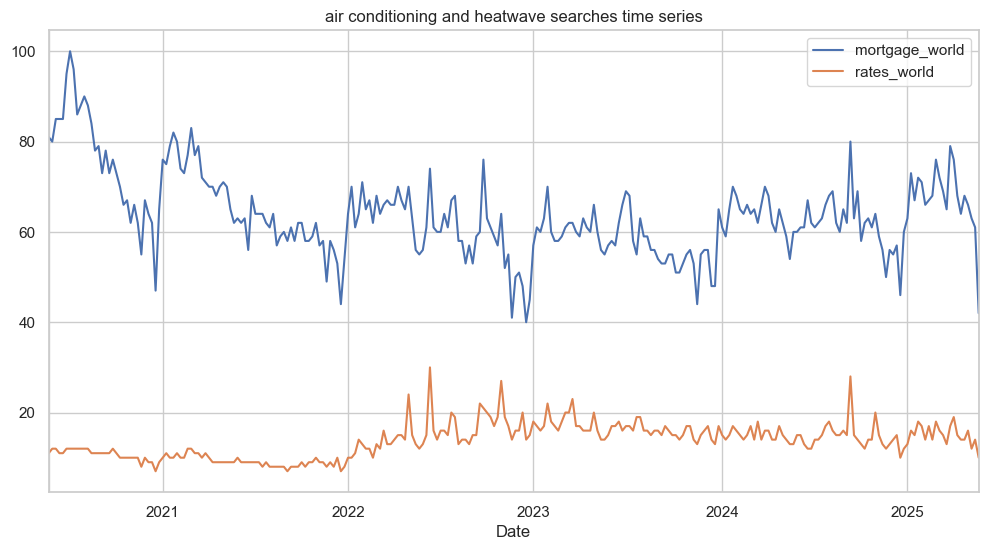

In [86]:
data[['mortgage_world', 'rates_world']].plot(figsize=(12, 6), title='air conditioning and heatwave searches time series')
plt.show()

As we see, our dataset consists of weekly Google Trends search data from 2020 to 2025 for keywords related to mortgages and interest rates across three regions: World, US, and Poland. We checked for missing values, ensured proper date indexing, and transformed the data to first differences where necessary to achieve stationarity. These steps prepared the data for time series modeling and forecasting.

***

## <a id="integration-order-and-granger-causality"></a>Integration order and Granger causality

In this section, we determine the stationarity of the time series by identifying their integration order using tests like the Augmented Dickey-Fuller (ADF) test. Stationarity is a prerequisite for Granger causality analysis, which examines whether one time series can predict another. The results help establish the causal relationship between the variables, providing insights into their dynamic interactions.

Checking the integration order of series before estimating VAR model is crucial - standard VAR models require all variables to be stationary (I(0)).
If variables are non-stationary, applying VAR directly can lead to spurious regression results.
The model assumptions (constant mean, variance) are violated with non-stationary data.

In [87]:
def adf_test(series, max_aug=10, version='c'):

    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations

        for aug in range(1, i+1): # adding augmentations max_aug is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 100:
                cv01 = -2.567; cv05 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 100:
                cv01 = -3.434; cv05 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 100:
                cv01 = -3.963; cv05 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test01 = smd.acorr_breusch_godfrey(model, nlags=1);  bg_pvalue01 = round(bg_test01[1],4); bg_test01 = round(bg_test01[0],4);
        bg_test05 = smd.acorr_breusch_godfrey(model, nlags=5);  bg_pvalue05 = round(bg_test05[1],4); bg_test05 = round(bg_test05[0],4);
        bg_test10 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test10[1],4); bg_test10 = round(bg_test10[0],4);
        bg_test15 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test15[1],4); bg_test15 = round(bg_test15[0],4);

        results.append([i, ts, cv01, cv05, cv10,
                        bg_test01, bg_pvalue01, bg_test05, bg_pvalue05, bg_test10, bg_pvalue10, bg_test15, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations',
                          'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)',
                          'BG test (1 lag) (statistic)', 'BG test (1 lag) (p-value)',
                          'BG test (5 lags) (statistic)', 'BG test (5 lags) (p-value)',
                          'BG test (10 lags) (statistic)', 'BG test (10 lags) (p-value)',
                          'BG test (15 lags) (statistic)', 'BG test (15 lags) (p-value)']

    return results_df

In [88]:
adf_test(data['mortgage_world'])

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0       -5.0798755533            -3.4340000000   
1                        1       -4.0621764783            -3.4340000000   
2                        2       -3.9262688208            -3.4340000000   
3                        3       -3.2052000726            -3.4340000000   
4                        4       -3.4185665204            -3.4340000000   
5                        5       -4.1412270465            -3.4340000000   
6                        6       -4.2444444814            -3.4340000000   
7                        7       -4.4151304844            -3.4340000000   
8                        8       -4.0974596273            -3.4340000000   
9                        9       -4.3593161273            -3.4340000000   

   ADF critival value (5%)  ADF critival value (10%)  \
0            -2.8630000000             -2.5680000000   
1            -2.8630000000             -2.5680000000   
2            -2.8630000000             -2.5680000000   
3            -2.8630000000             -2.5680000000   
4            -2.8630000000             -2.5680000000   
5            -2.8630000000             -2.5680000000   
6            -2.8630000000             -2.5680000000   
7            -2.8630000000             -2.5680000000   
8            -2.8630000000             -2.5680000000   
9            -2.8630000000             -2.5680000000   

   BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                 9.0250000000               0.0027000000   
1                 0.8438000000               0.3583000000   
2                 6.4410000000               0.0112000000   
3                 1.3516000000               0.2450000000   
4                 9.1292000000               0.0025000000   
5                 1.3799000000               0.2401000000   
6                 0.0262000000               0.8715000000   
7                 0.2768000000               0.5988000000   
8                 3.0051000000               0.0830000000   
9                 0.5914000000               0.4419000000   

   BG test (5 lags) (statistic)  BG test (5 lags) (p-value)  \
0                 28.6168000000                0.0000000000   
1                 20.8780000000                0.0009000000   
2                 19.0163000000                0.0019000000   
3                 11.4542000000                0.0431000000   
4                 18.0741000000                0.0029000000   
5                  7.4764000000                0.1876000000   
6                  4.9219000000                0.4255000000   
7                  7.4592000000                0.1887000000   
8                  8.6940000000                0.1219000000   
9                 10.4080000000                0.0645000000   

   BG test (10 lags) (statistic)  BG test (10 lags) (p-value)  \
0                  40.2341000000                 0.0000000000   
1                  31.0291000000                 0.0006000000   
2                  31.0283000000                 0.0006000000   
3                  26.0777000000                 0.0036000000   
4                  24.5150000000                 0.0063000000   
5                  12.8519000000                 0.2321000000   
6                  21.4692000000                 0.0180000000   
7                  19.8674000000                 0.0305000000   
8                  18.0422000000                 0.0543000000   
9                  14.8680000000                 0.1369000000   

   BG test (15 lags) (statistic)  BG test (15 lags) (p-value)  
0                  54.3936000000                 0.0000000000  
1                  46.4080000000                 0.0000000000  
2                  46.8120000000                 0.0000000000  
3                  34.4241000000                 0.0030000000  
4                  36.0959000000                 0.0017000000  
5                  26.2284000000                 0.0357000000  
6                  22.86680000

The ADF statistic results indicate that we can reject the null hypothesis about the non-stationarity for all of the analyzed models. However, the results of the BG test, regarding the autocorrelation, show the presence of the autocorrelation of the residuals for lags up to 15 lags for models with up to 4 augmentations. The model with 5 augmentations is stationary and has no problem with autocorrelation. Let's check the stationarity of the differenciated series *d_mortgage_world*.

In [89]:
adf_test(data['d_mortgage_world'])

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0      -20.5276751222            -3.4340000000   
1                        1      -13.7459853479            -3.4340000000   
2                        2      -13.7466705534            -3.4340000000   
3                        3       -9.6278187228            -3.4340000000   
4                        4       -7.5728512350            -3.4340000000   
5                        5       -7.8974732694            -3.4340000000   
6                        6       -6.6897197746            -3.4340000000   
7                        7       -6.3342574154            -3.4340000000   
8                        8       -5.4380967143            -3.4340000000   
9                        9       -5.7883936210            -3.4340000000   

   ADF critival value (5%)  ADF critival value (10%)  \
0            -2.8630000000             -2.5680000000   
1            -2.8630000000             -2.5680000000   
2            -2.8630000000             -2.5680000000   
3            -2.8630000000             -2.5680000000   
4            -2.8630000000             -2.5680000000   
5            -2.8630000000             -2.5680000000   
6            -2.8630000000             -2.5680000000   
7            -2.8630000000             -2.5680000000   
8            -2.8630000000             -2.5680000000   
9            -2.8630000000             -2.5680000000   

   BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                 2.5222000000               0.1123000000   
1                16.7534000000               0.0000000000   
2                 0.6518000000               0.4195000000   
3                 3.0328000000               0.0816000000   
4                 0.0558000000               0.8132000000   
5                 0.1852000000               0.6669000000   
6                 0.1750000000               0.6757000000   
7                 0.2172000000               0.6411000000   
8                 3.8686000000               0.0492000000   
9                 0.0723000000               0.7879000000   

   BG test (5 lags) (statistic)  BG test (5 lags) (p-value)  \
0                 24.8187000000                0.0002000000   
1                 21.4158000000                0.0007000000   
2                  8.4096000000                0.1351000000   
3                 12.8111000000                0.0252000000   
4                  3.7315000000                0.5887000000   
5                  6.0794000000                0.2986000000   
6                  8.0687000000                0.1525000000   
7                  8.5080000000                0.1304000000   
8                 11.1979000000                0.0476000000   
9                 14.4917000000                0.0128000000   

   BG test (10 lags) (statistic)  BG test (10 lags) (p-value)  \
0                  34.4372000000                 0.0002000000   
1                  33.2925000000                 0.0002000000   
2                  18.6327000000                 0.0452000000   
3                  25.1910000000                 0.0050000000   
4                  10.7083000000                 0.3807000000   
5                  20.6266000000                 0.0239000000   
6                  24.2040000000                 0.0071000000   
7                  15.1805000000                 0.1256000000   
8                  19.6028000000                 0.0332000000   
9                  19.3083000000                 0.0365000000   

   BG test (15 lags) (statistic)  BG test (15 lags) (p-value)  
0                  48.0486000000                 0.0000000000  
1                  46.6335000000                 0.0000000000  
2                  32.1436000000                 0.0062000000  
3                  32.8279000000                 0.0050000000  
4                  23.7591000000                 0.0693000000  
5                  21.2692000000                 0.1284000000  
6                  26.17150000

Based on the results, we can see that the differentiated series *d_mortgage_world* is stationary and has no problems with autocorrelation for a model with 4 augmentations. Hence, the series *mortgage_world* is **integrated of order 1**. Now let's check the series *rates_world*.

In [90]:
adf_test(data['rates_world'], max_aug=10)

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0       -6.3648905215            -3.4340000000   
1                        1       -4.5193851780            -3.4340000000   
2                        2       -3.6677302587            -3.4340000000   
3                        3       -2.8718245249            -3.4340000000   
4                        4       -2.3178563107            -3.4340000000   
5                        5       -1.7027941042            -3.4340000000   
6                        6       -1.6233546529            -3.4340000000   
7                        7       -1.7485483338            -3.4340000000   
8                        8       -1.6610009609            -3.4340000000   
9                        9       -1.7977767124            -3.4340000000   

   ADF critival value (5%)  ADF critival value (10%)  \
0            -2.8630000000             -2.5680000000   
1            -2.8630000000             -2.5680000000   
2            -2.8630000000             -2.5680000000   
3            -2.8630000000             -2.5680000000   
4            -2.8630000000             -2.5680000000   
5            -2.8630000000             -2.5680000000   
6            -2.8630000000             -2.5680000000   
7            -2.8630000000             -2.5680000000   
8            -2.8630000000             -2.5680000000   
9            -2.8630000000             -2.5680000000   

   BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                17.5037000000               0.0000000000   
1                 7.0792000000               0.0078000000   
2                12.7423000000               0.0004000000   
3                10.6749000000               0.0011000000   
4                22.7119000000               0.0000000000   
5                 0.3846000000               0.5352000000   
6                 2.0379000000               0.1534000000   
7                 0.5160000000               0.4726000000   
8                 2.4865000000               0.1148000000   
9                 0.2127000000               0.6447000000   

   BG test (5 lags) (statistic)  BG test (5 lags) (p-value)  \
0                 59.7233000000                0.0000000000   
1                 50.1388000000                0.0000000000   
2                 44.5298000000                0.0000000000   
3                 34.5632000000                0.0000000000   
4                 27.4785000000                0.0000000000   
5                  5.6169000000                0.3453000000   
6                  5.2084000000                0.3910000000   
7                 13.9881000000                0.0157000000   
8                 13.6001000000                0.0184000000   
9                 16.1542000000                0.0064000000   

   BG test (10 lags) (statistic)  BG test (10 lags) (p-value)  \
0                  68.4010000000                 0.0000000000   
1                  55.0106000000                 0.0000000000   
2                  49.4944000000                 0.0000000000   
3                  40.5234000000                 0.0000000000   
4                  39.0219000000                 0.0000000000   
5                  21.1635000000                 0.0200000000   
6                  20.5690000000                 0.0243000000   
7                  20.0546000000                 0.0287000000   
8                  20.0782000000                 0.0285000000   
9                  20.2226000000                 0.0272000000   

   BG test (15 lags) (statistic)  BG test (15 lags) (p-value)  
0                  79.3090000000                 0.0000000000  
1                  67.1095000000                 0.0000000000  
2                  61.8447000000                 0.0000000000  
3                  50.9852000000                 0.0000000000  
4                  44.0568000000                 0.0001000000  
5                  26.0084000000                 0.0379000000  
6                  26.49870000

The results of the ADF test indicate that the series is stationary for the model with up to 3 augmentations (assuming the 5% significance level). However, the results of the BG test show that there is a serious autocorrelation of the residuals. Hence, we need to analyze the differentiated series *d_rates_world*.

In [91]:
adf_test(data['d_rates_world'], max_aug=10)

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0      -23.3265777949            -3.4340000000   
1                        1      -16.5853368096            -3.4340000000   
2                        2      -14.9230703897            -3.4340000000   
3                        3      -13.6550088171            -3.4340000000   
4                        4      -14.2372929929            -3.4340000000   
5                        5      -11.0156675970            -3.4340000000   
6                        6       -8.1613803280            -3.4340000000   
7                        7       -7.5545162496            -3.4340000000   
8                        8       -6.1540201961            -3.4340000000   
9                        9       -5.5780268323            -3.4340000000   

   ADF critival value (5%)  ADF critival value (10%)  \
0            -2.8630000000             -2.5680000000   
1            -2.8630000000             -2.5680000000   
2            -2.8630000000             -2.5680000000   
3            -2.8630000000             -2.5680000000   
4            -2.8630000000             -2.5680000000   
5            -2.8630000000             -2.5680000000   
6            -2.8630000000             -2.5680000000   
7            -2.8630000000             -2.5680000000   
8            -2.8630000000             -2.5680000000   
9            -2.8630000000             -2.5680000000   

   BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                13.3437000000               0.0003000000   
1                17.4084000000               0.0000000000   
2                13.3623000000               0.0003000000   
3                25.0435000000               0.0000000000   
4                 0.6192000000               0.4313000000   
5                 1.5150000000               0.2184000000   
6                 0.7897000000               0.3742000000   
7                 1.9115000000               0.1668000000   
8                 0.0740000000               0.7855000000   
9                 1.3525000000               0.2448000000   

   BG test (5 lags) (statistic)  BG test (5 lags) (p-value)  \
0                 63.4038000000                0.0000000000   
1                 53.8753000000                0.0000000000   
2                 39.4801000000                0.0000000000   
3                 29.4408000000                0.0000000000   
4                  4.9727000000                0.4192000000   
5                  4.4724000000                0.4836000000   
6                  4.7994000000                0.4409000000   
7                 14.4223000000                0.0131000000   
8                 17.2567000000                0.0040000000   
9                 17.3666000000                0.0039000000   

   BG test (10 lags) (statistic)  BG test (10 lags) (p-value)  \
0                  67.5941000000                 0.0000000000   
1                  57.9831000000                 0.0000000000   
2                  46.1325000000                 0.0000000000   
3                  42.9816000000                 0.0000000000   
4                  22.1225000000                 0.0145000000   
5                  21.2745000000                 0.0193000000   
6                  20.8012000000                 0.0225000000   
7                  21.1052000000                 0.0204000000   
8                  19.4049000000                 0.0354000000   
9                  23.6205000000                 0.0087000000   

   BG test (15 lags) (statistic)  BG test (15 lags) (p-value)  
0                  80.4902000000                 0.0000000000  
1                  70.5249000000                 0.0000000000  
2                  55.8988000000                 0.0000000000  
3                  47.3853000000                 0.0000000000  
4                  27.1896000000                 0.0272000000  
5                  27.4682000000                 0.0251000000  
6                  30.41850000

The differenciated series shows the stationarity for all of the augmentations. However, there is still a problem with autocorrelation of the residuals - the model with 4 augmentations is characterized with no autocorrelation up to 5 lags (up to 15 with 1% significance level). Hence, the series *rates_world* is **integrated of order 1**. That means that we will need to use first differenced in the VAR model estimation.


In this subsection, we perform **Granger causality** tests to determine whether one time series can predict another. The test evaluates the null hypothesis that the lagged values of one series do not provide statistically significant information about the future values of another series. By analyzing the p-values for different lags, we identify the presence and direction of causality between the variables, offering insights into their dynamic relationships.

Granger Causality is crucial for the VAR models estimation - VAR models assume that variables in the system influence each other.
If no Granger causality exists between variables, including them in the same VAR may be unnecessary.
Granger Causality check helps justify the multivariate approach over separate univariate models.

In [92]:
grangercausalitytests(data[['d_mortgage_world', 'd_rates_world']].dropna(), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2655  , p=0.6068  , df_denom=257, df_num=1
ssr based chi2 test:   chi2=0.2686  , p=0.6043  , df=1
likelihood ratio test: chi2=0.2684  , p=0.6044  , df=1
parameter F test:         F=0.2655  , p=0.6068  , df_denom=257, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3047  , p=0.7376  , df_denom=254, df_num=2
ssr based chi2 test:   chi2=0.6214  , p=0.7329  , df=2
likelihood ratio test: chi2=0.6207  , p=0.7332  , df=2
parameter F test:         F=0.3047  , p=0.7376  , df_denom=254, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7449  , p=0.1583  , df_denom=251, df_num=3
ssr based chi2 test:   chi2=5.3808  , p=0.1459  , df=3
likelihood ratio test: chi2=5.3255  , p=0.1495  , df=3
parameter F test:         F=1.7449  , p=0.1583  , df_denom=251, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3477  , p=0.2528  

{np.int64(1): ({'ssr_ftest': (np.float64(0.26546831780075736),
    np.float64(0.6068308788459793),
    np.float64(257.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.26856716975952105),
    np.float64(0.6042945502514105),
    np.int64(1)),
   'lrtest': (np.float64(0.26842855688823875),
    np.float64(0.6043878627122321),
    np.int64(1)),
   'params_ftest': (np.float64(0.2654683178007279),
    np.float64(0.6068308788459793),
    np.float64(257.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.3047113771297963),
    np.float64(0.737605305790128),
    np.float64(254.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.6214192651702145),
    np.float64(0.7329266629950535),
    np.int64(2)),
   'lrtest': (np.float64(0.6206749691605182),
    np.float64(0.7331994709497065),
    np.int64(2)),
   'params_ftest': (np.float64(0.30471137712981944),
    np.float64(0.7376053057901071),
    np.float64(254.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
   

We reject the null hypothesis of no causalty at the 5% significance level for lag 5. This means that ***rates*** Granger causes ***mortgage*** at the 5% significance level. Hence, we can conclude that ***rates*** is a Granger cause of  ***mortgage***.

In [93]:
grangercausalitytests(data[['d_rates_world', 'd_mortgage_world']].dropna(), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2658  , p=0.2616  , df_denom=257, df_num=1
ssr based chi2 test:   chi2=1.2805  , p=0.2578  , df=1
likelihood ratio test: chi2=1.2774  , p=0.2584  , df=1
parameter F test:         F=1.2658  , p=0.2616  , df_denom=257, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2856  , p=0.2783  , df_denom=254, df_num=2
ssr based chi2 test:   chi2=2.6218  , p=0.2696  , df=2
likelihood ratio test: chi2=2.6086  , p=0.2714  , df=2
parameter F test:         F=1.2856  , p=0.2783  , df_denom=254, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3322  , p=0.2644  , df_denom=251, df_num=3
ssr based chi2 test:   chi2=4.1080  , p=0.2500  , df=3
likelihood ratio test: chi2=4.0756  , p=0.2534  , df=3
parameter F test:         F=1.3322  , p=0.2644  , df_denom=251, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6389  , p=0.6352  

{np.int64(1): ({'ssr_ftest': (np.float64(1.2657541203436418),
    np.float64(0.2616143318308877),
    np.float64(257.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.280529460269832),
    np.float64(0.257800614330818),
    np.int64(1)),
   'lrtest': (np.float64(1.2773863996549153),
    np.float64(0.25838555619340364),
    np.int64(1)),
   'params_ftest': (np.float64(1.2657541203436267),
    np.float64(0.2616143318308877),
    np.float64(257.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.2856003537660747),
    np.float64(0.27827735745302457),
    np.float64(254.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(2.621814894688294),
    np.float64(0.2695753199506307),
    np.int64(2)),
   'lrtest': (np.float64(2.6086336713290166),
    np.float64(0.2713578537446633),
    np.int64(2)),
   'params_ftest': (np.float64(1.285600353766093),
    np.float64(0.27827735745302457),
    np.float64(254.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
       

We reject the null hypothesis of no causalty at the 5% significance level for lag 5. This means that ***mortgage*** Granger causes ***rates*** at the 5% significance level. Hence, we can conclude that ***mortgage*** is a Granger cause of  ***rates***.

***

## <a id="VAR-model"></a>VAR model

In this section, we specify, estimate, and evaluate a Vector Autoregression (VAR) model to analyze the dynamic relationship between the time series. The VAR model captures the interdependencies between the variables by modeling each as a function of its own lags and the lags of the other variables. We determine the optimal lag order using information criteria (AIC, BIC, HQIC, FPE) and assess the model's adequacy through diagnostic checks, including residual autocorrelation and stability tests. The model's performance is further evaluated using impulse response functions (IRF) and forecast error variance decomposition (FEVD) to interpret the interactions and forecast accuracy.

### <a id="VAR-model-specification"></a>VAR model specification

Since we know that the series *d_mortgage_world* and *d_rates_world* are stationary we can create a VAR model.

In [94]:
data_train = data[['d_mortgage_world', 'd_rates_world']].dropna()
forecast_horizon = 6
data_train_short = data_train.iloc[:-forecast_horizon]

In [95]:
model = VAR(data_train, freq='W')
results = model.select_order(maxlags=15)
print("\nLag selection results:")
print(results.summary())


Lag selection results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        5.168       5.197       175.6       5.180
1        4.953       5.039       141.6       4.987
2        4.908       5.050       135.3       4.965
3        4.812       5.012       123.0       4.892
4        4.772       5.028       118.1       4.875
5        4.599      4.913*       99.42      4.725*
6        4.592       4.962       98.68       4.741
7        4.585       5.012       98.01       4.757
8        4.601       5.086       99.64       4.796
9        4.617       5.158       101.2       4.835
10       4.638       5.237       103.4       4.879
11       4.664       5.319       106.1       4.928
12       4.636       5.349       103.3       4.923
13       4.615       5.384       101.2       4.925
14      4.574*       5.400      97.12*       4.907
15       4.594       5.478       99.20       4.950
-------

Information criteria for different lag orders:
  aic bic hqic fpe
1   1   1    1   1
2   2   1    2   2
3   3   3    3   3
4   4   3    4   4
5   5   5    5   5
6   6   5    5   6


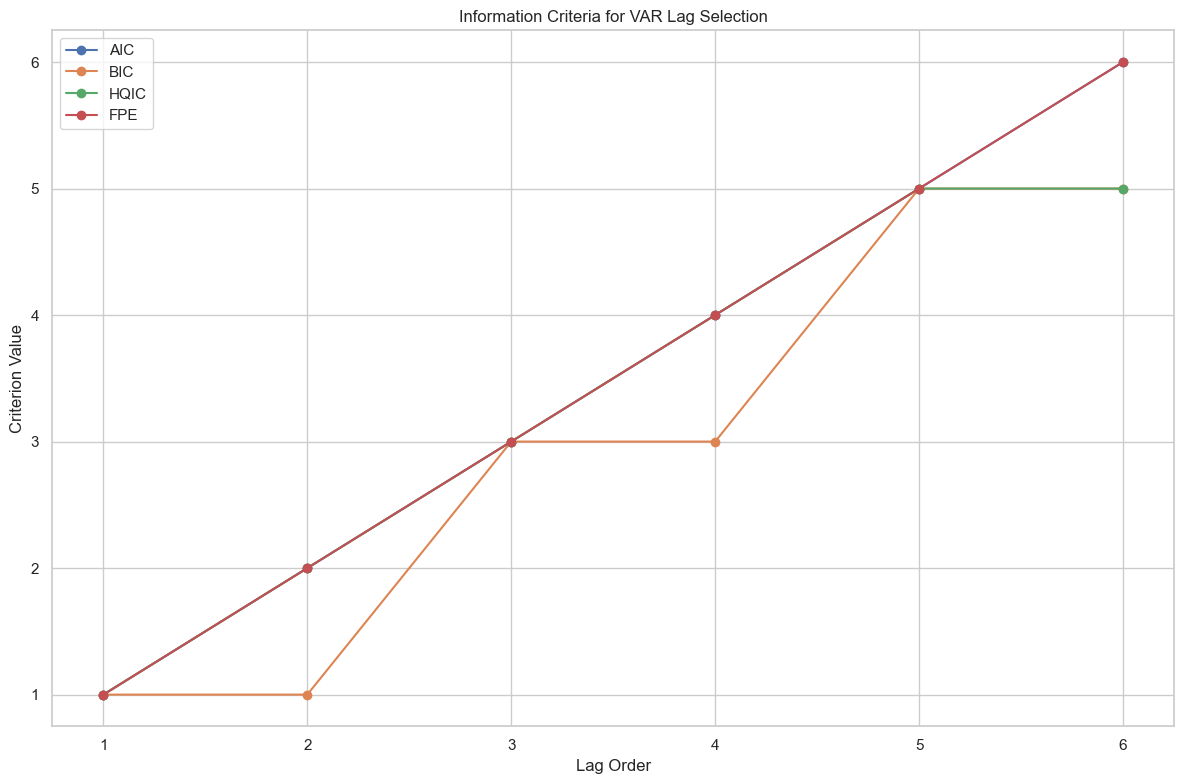

In [96]:
# Function to select optimal lag order
def select_var_order(data, max_lags=12):
    # Create a VAR model
    model = VAR(data, freq='W')

    # Determine information criteria for different lag orders
    results = {}
    for i in range(1, max_lags + 1):
        results[i] = model.select_order(i)

    # Create a DataFrame to display the results
    criteria = ['aic', 'bic', 'hqic', 'fpe']
    order_df = pd.DataFrame(index=range(1, max_lags + 1), columns=criteria)

    for i in range(1, max_lags + 1):
        for criterion in criteria:
            order_df.loc[i, criterion] = getattr(results[i], criterion)

    return order_df

# Select optimal lag order
lag_order_results = select_var_order(data_train, max_lags=6)
print("Information criteria for different lag orders:")
print(lag_order_results)

# Plot the information criteria
plt.figure(figsize=(12, 8))
for column in lag_order_results.columns:
    plt.plot(lag_order_results.index, lag_order_results[column], marker='o', label=column.upper())
plt.xlabel('Lag Order')
plt.ylabel('Criterion Value')
plt.title('Information Criteria for VAR Lag Selection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Based on the information criteria and the simplicity of the model we choose the model with 5 and 14 lags for further anlysis.

### <a id="VAR-model-estimation"></a>VAR model estimation

In [97]:
var5_model = VAR(data_train, freq='W')
var5_results = var5_model.fit(5)

print(var5_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Jul, 2025
Time:                     09:43:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.87643
Nobs:                     256.000    HQIC:                   4.69430
Log likelihood:          -1289.68    FPE:                    96.7252
AIC:                      4.57177    Det(Omega_mle):         88.9195
--------------------------------------------------------------------
Results for equation d_mortgage_world
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.207051         0.327552           -0.632           0.527
L1.d_mortgage_world        -0.247567         0.079080           -3.131           0.002
L1.d_rates_world         

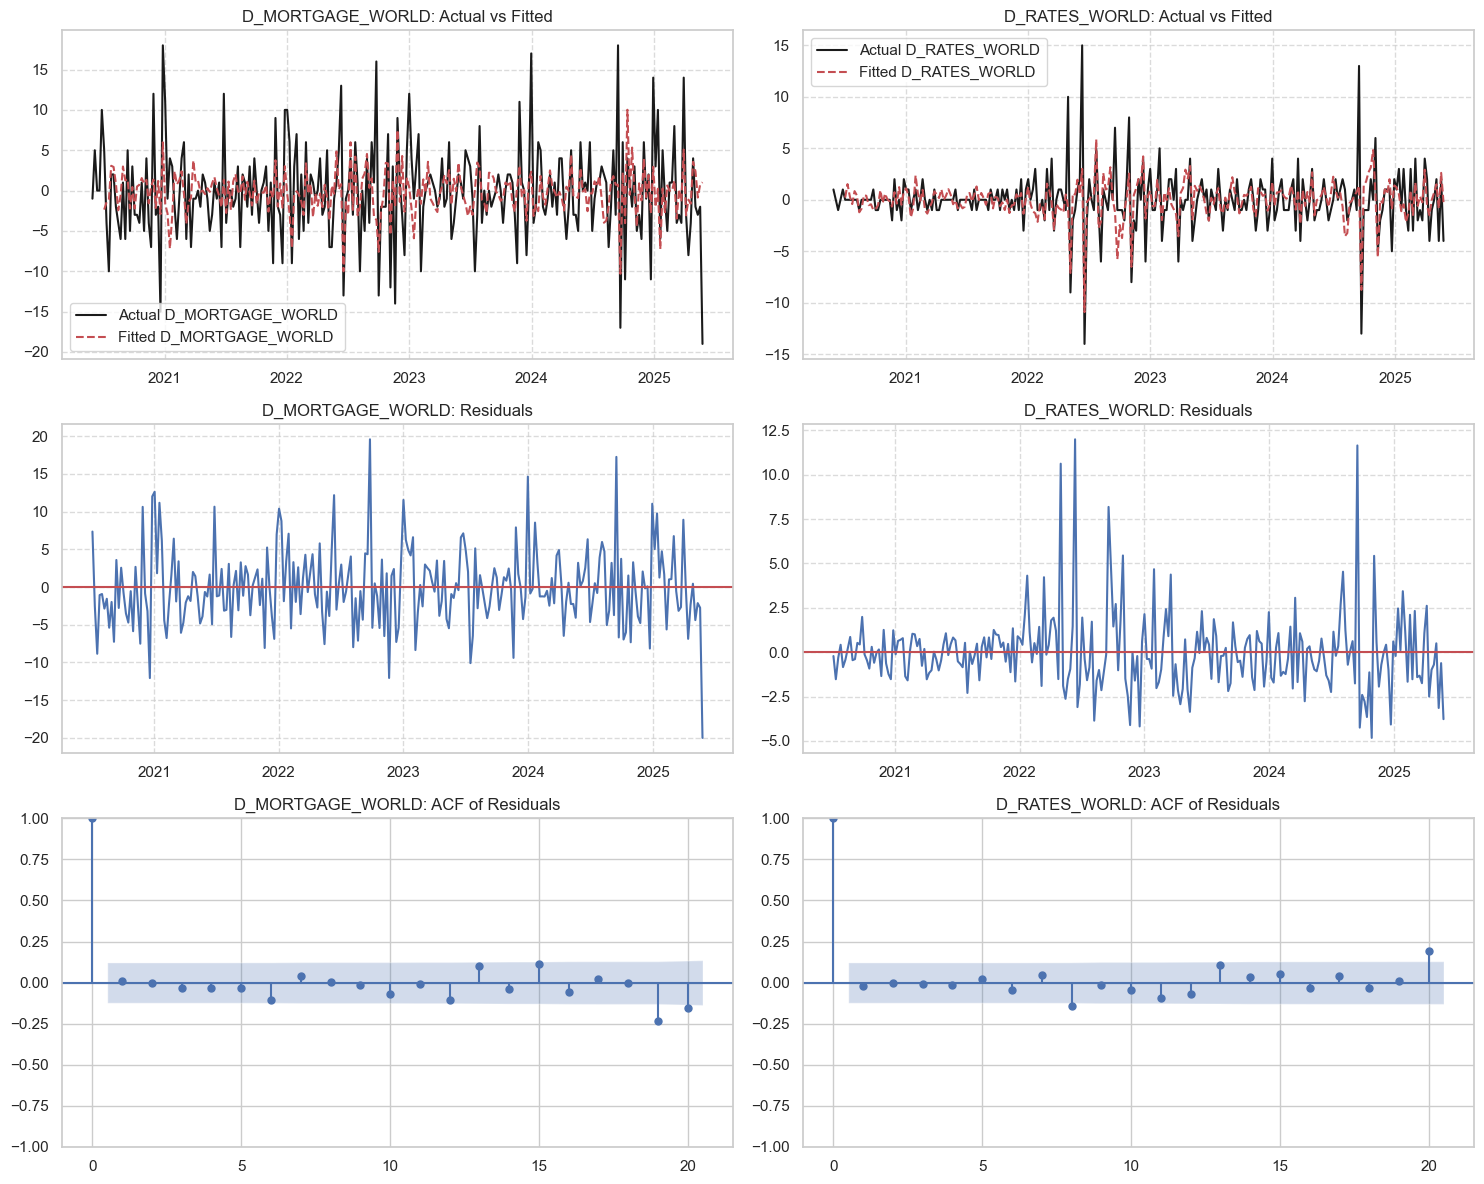

In [99]:
# Plot fitted values vs actual values, residuals, and ACF/PACF
fig = plt.figure(figsize=(15, 12))

# Fitted values vs actual values for each variable
for i, name in enumerate(data_train.columns):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(data_train.index, data_train[name], 'k-', label=f'Actual {name.upper()}')
    ax.plot(var5_results.fittedvalues[name].index, var5_results.fittedvalues[name], 'r--',
            label=f'Fitted {name.upper()}')
    ax.set_title(f'{name.upper()}: Actual vs Fitted')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Residuals for each variable
for i, name in enumerate(data_train.columns):
    ax = fig.add_subplot(3, 2, i+3)
    residuals = var5_results.resid[name]
    ax.plot(residuals.index, residuals, 'b-')
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_title(f'{name.upper()}: Residuals')
    ax.grid(True, linestyle='--', alpha=0.7)

# ACF and PACF for residuals
for i, name in enumerate(data_train.columns):
    ax = fig.add_subplot(3, 2, i+5)
    residuals = var5_results.resid[name].values
    plot_acf(residuals, ax=ax, lags=20, alpha=0.05, title=f'{name.upper()}: ACF of Residuals')

plt.tight_layout()
plt.show()


In [100]:
# Perform Ljung-Box test for autocorrelation of residuals (equivalent to Portmanteau test)
residuals = var5_results.resid

print("Ljung-Box Test for Residual Autocorrelation:")
for name in residuals.columns:
    lb_test = acorr_ljungbox(residuals[name], lags=[12, 24])
    print(f"\n{name.upper()} series:")
    print(f"Lag 12: p-value = {lb_test.iloc[0, 1]:.4f}")
    print(f"Lag 24: p-value = {lb_test.iloc[1, 1]:.4f}")

Ljung-Box Test for Residual Autocorrelation:

D_MORTGAGE_WORLD series:
Lag 12: p-value = 0.6956
Lag 24: p-value = 0.0070

D_RATES_WORLD series:
Lag 12: p-value = 0.5314
Lag 24: p-value = 0.2404


The VAR(6) is performing well - there is no problem with residual autocorrelation. Let's see the model with 15 lags.

In [101]:
var14_model = VAR(data_train, freq='W')
var14_results = var14_model.fit(14)

print(var14_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Jul, 2025
Time:                     09:44:43
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.39655
Nobs:                     247.000    HQIC:                   4.90426
Log likelihood:          -1207.66    FPE:                    96.9954
AIC:                      4.57249    Det(Omega_mle):         77.6831
--------------------------------------------------------------------
Results for equation d_mortgage_world
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.039352         0.323083           -0.122           0.903
L1.d_mortgage_world         -0.219203         0.083812           -2.615           0.009
L1.d_rates_world     

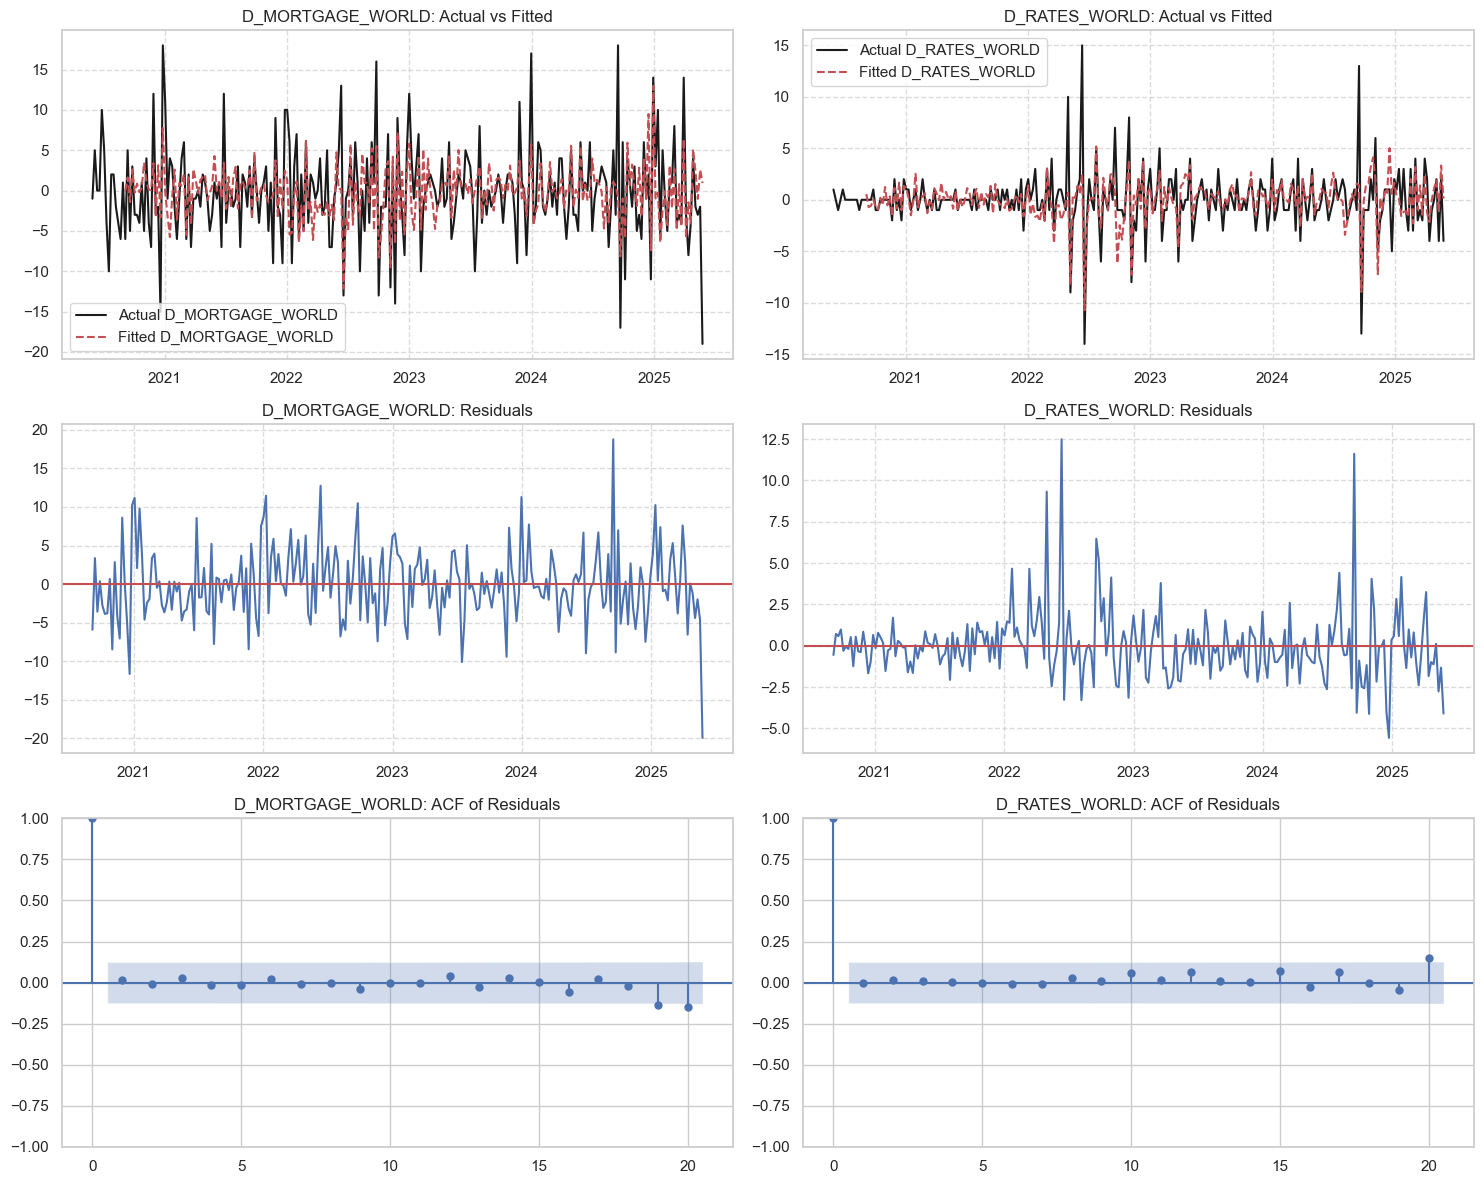

In [102]:
fig = plt.figure(figsize=(15, 12))

# Fitted values vs actual values for each variable
for i, name in enumerate(data_train.columns):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(data_train.index, data_train[name], 'k-', label=f'Actual {name.upper()}')
    ax.plot(var14_results.fittedvalues[name].index, var14_results.fittedvalues[name], 'r--',
            label=f'Fitted {name.upper()}')
    ax.set_title(f'{name.upper()}: Actual vs Fitted')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Residuals for each variable
for i, name in enumerate(data_train.columns):
    ax = fig.add_subplot(3, 2, i+3)
    residuals = var14_results.resid[name]
    ax.plot(residuals.index, residuals, 'b-')
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_title(f'{name.upper()}: Residuals')
    ax.grid(True, linestyle='--', alpha=0.7)

# ACF and PACF for residuals
for i, name in enumerate(data_train.columns):
    ax = fig.add_subplot(3, 2, i+5)
    residuals = var14_results.resid[name].values
    plot_acf(residuals, ax=ax, lags=20, alpha=0.05, title=f'{name.upper()}: ACF of Residuals')

plt.tight_layout()
plt.show()


In [103]:
residuals = var14_results.resid

print("Ljung-Box Test for Residual Autocorrelation:")
for name in residuals.columns:
    lb_test = acorr_ljungbox(residuals[name], lags=[12, 24])
    print(f"\n{name.upper()} series:")
    print(f"Lag 12: p-value = {lb_test.iloc[0, 1]:.4f}")
    print(f"Lag 24: p-value = {lb_test.iloc[1, 1]:.4f}")

Ljung-Box Test for Residual Autocorrelation:

D_MORTGAGE_WORLD series:
Lag 12: p-value = 0.9999
Lag 24: p-value = 0.8011

D_RATES_WORLD series:
Lag 12: p-value = 0.9989
Lag 24: p-value = 0.9163


Similar to the VAR(5) model - no residual autocorrelation was detected, evidence from Ljung-Box test and ACF/PACF plots. Let's compare the two models and decide with which we will proceed our analysis and forecast.

In [107]:
# Compare information criteria for the two models
ic_comparison = pd.DataFrame({
    'VAR(5)': [var5_results.aic, var5_results.bic, var5_results.hqic, var5_results.fpe],
    'VAR(14)': [var14_results.aic, var14_results.bic, var14_results.hqic, var14_results.fpe]
}, index=['AIC', 'BIC', 'HQIC', 'FPE'])

print("Information Criteria Comparison:")
print(ic_comparison)

# Find the best model according to each criterion (smaller is better)
best_model = ic_comparison.idxmin(axis=1)
print("\nBest model according to each criterion:")
print(best_model)

Information Criteria Comparison:
            VAR(5)       VAR(14)
AIC   4.5717678572  4.5724872766
BIC   4.8764315438  5.3965541734
HQIC  4.6943024639  4.9042630598
FPE  96.7251791617 96.9953709221

Best model according to each criterion:
AIC     VAR(5)
BIC     VAR(5)
HQIC    VAR(5)
FPE     VAR(5)
dtype: object


VAR(5) was selected based on all four information criteria (AIC, BIC, HQIC, FPE). Let's perform the diagnosis of the VAR(5) model.

### <a id="VAR-model-diagnostics"></a>VAR model diagnostics

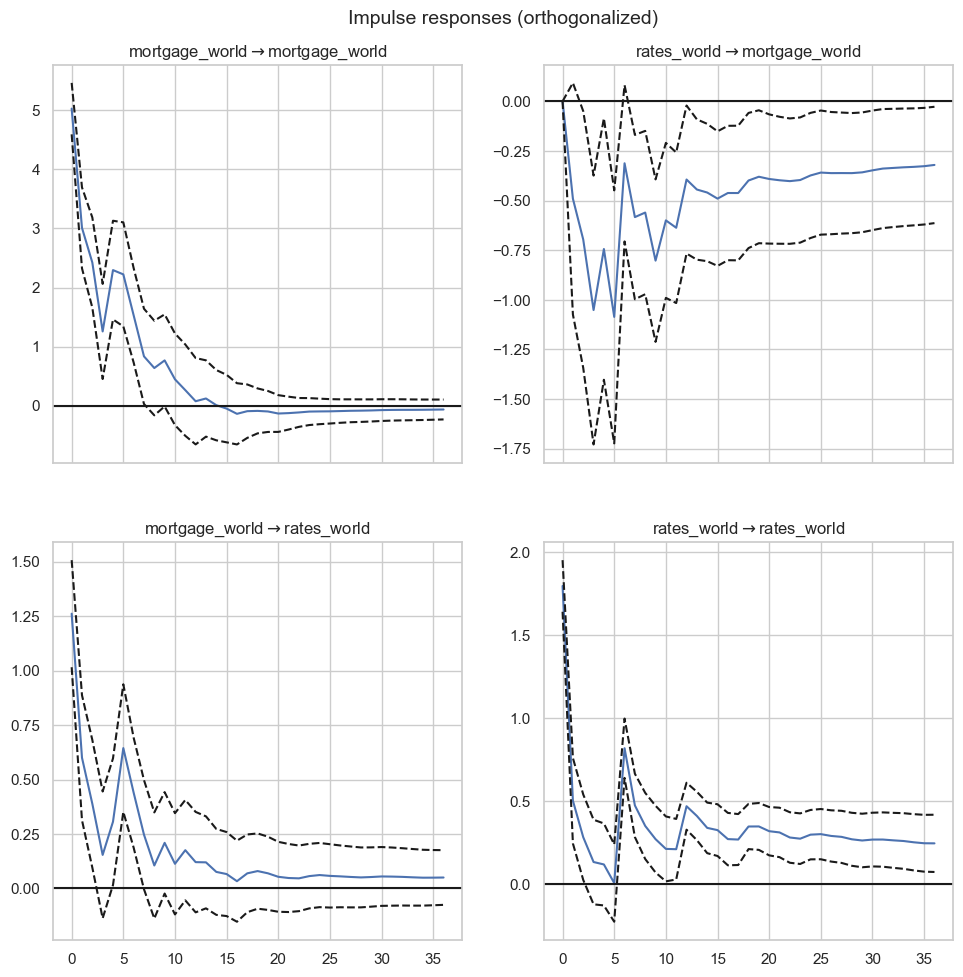

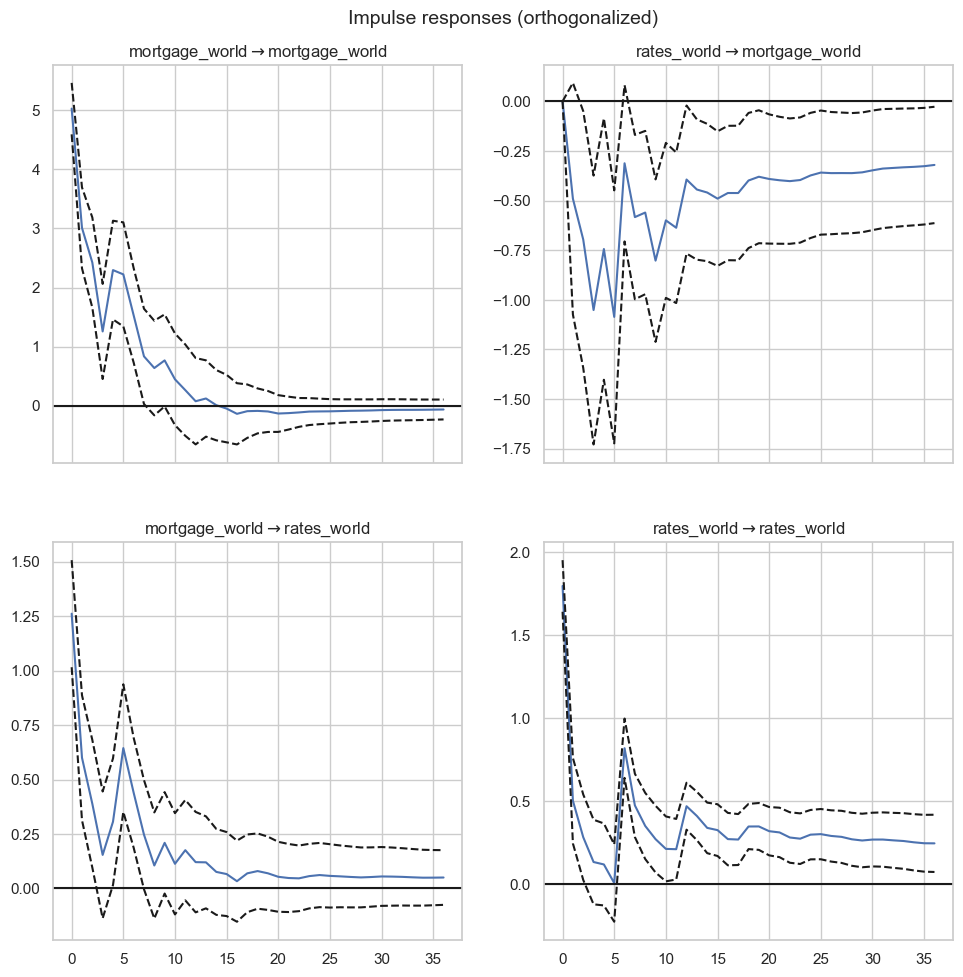

In [108]:
# Calculate and plot impulse response functions
irf = var6_results.irf(36)  # 36 periods ahead (equivalent to n.ahead=36 in R)

# Orthogonalization is done using the Cholesky decomposition of the estimated error covariance matrix
# and hence interpretations may change depending on variable ordering.
irf.plot(orth=True)

The IRF plots reveal that a shock to `rates_world` leads to an significant negative impact on `mortgage_world` - later it will flatten out at around -0.5. A shock to `mortgage_world` has a positive effect on `rates_world`, indicating asymmetry influence between these two variables. Both of the shocks resulted in mean-reverting impacts, indicating low long-term relation.

FEVD for mortgage_world
      mortgage_world  rates_world
0           1.000000     0.000000
1           0.993042     0.006958
2           0.982282     0.017718
3           0.958042     0.041958
4           0.951786     0.048214
5           0.935880     0.064120
6           0.936895     0.063105
7           0.932243     0.067757
8           0.927807     0.072193
9           0.918708     0.081292
10          0.913603     0.086397
11          0.907725     0.092275
12          0.905468     0.094532
13          0.902627     0.097373
14          0.899584     0.100416
15          0.896149     0.103851
16          0.893150     0.106850
17          0.890154     0.109846
18          0.887936     0.112064
19          0.885938     0.114062
20          0.883845     0.116155
21          0.881689     0.118311
22          0.879491     0.120509
23          0.877359     0.122641
24          0.875479     0.124521
25          0.873750     0.126250
26          0.872001     0.127999
27          0.870260    

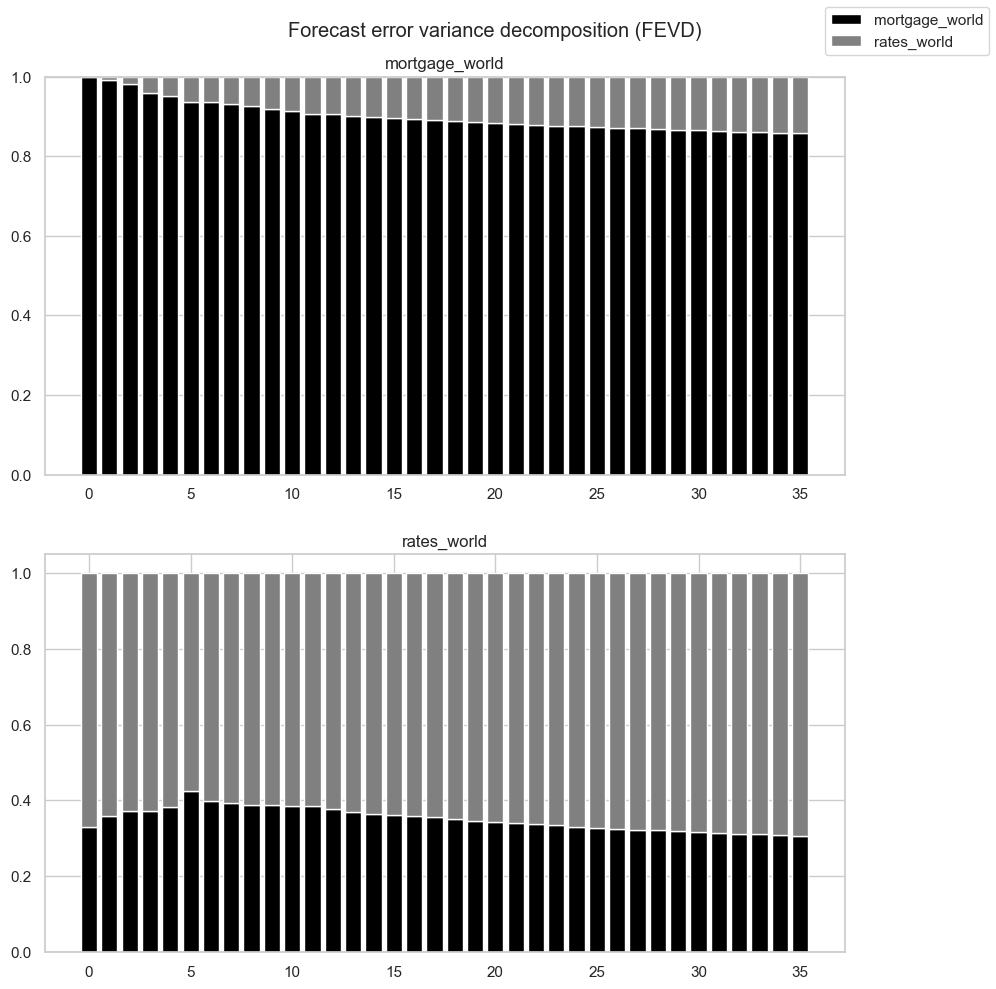

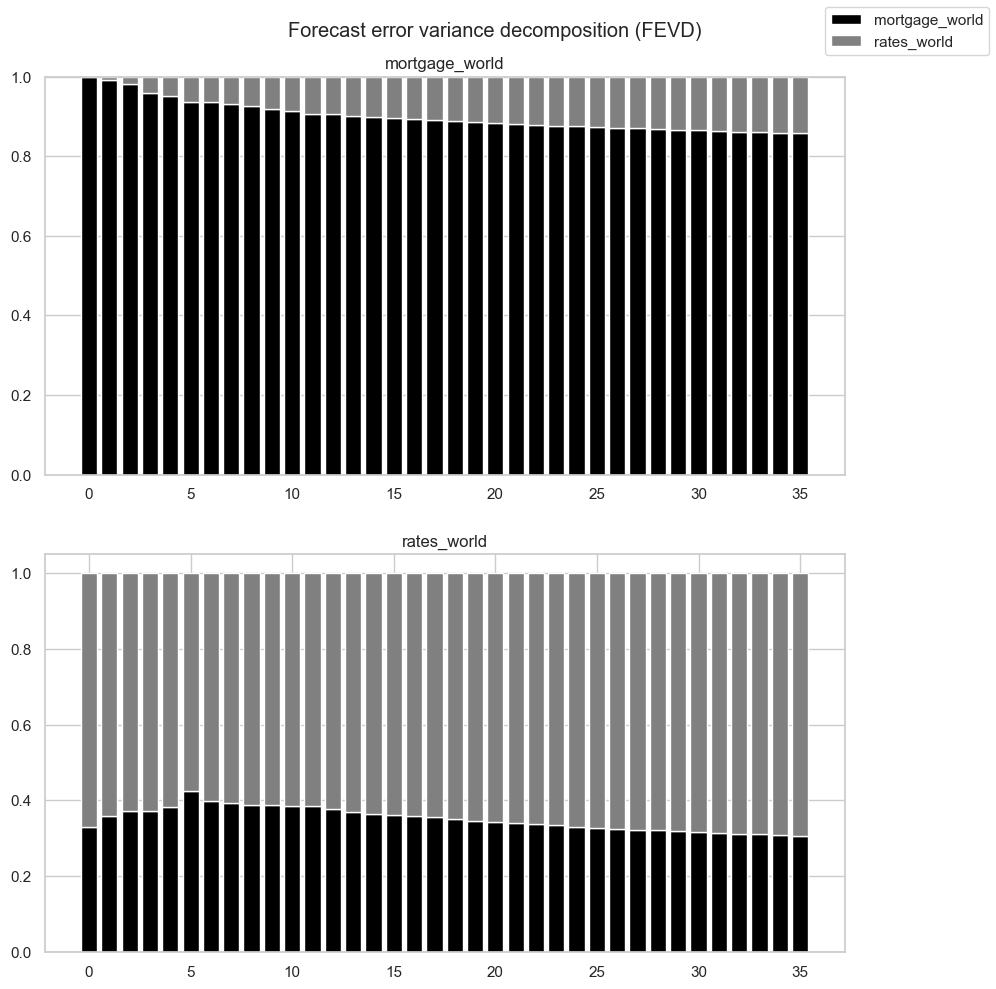

In [109]:
# Calculate and plot forecast error variance decomposition
fevd = var6_results.fevd(36)  # 36 periods ahead
fevd.summary()

# Plot FEVD
var6_results.fevd(36).plot()

The FEVD shows that most of the forecast variance in `mortgage_world` is explained by its own shocks, but around 30–40% is attributed to `rates_world` after several weeks. This confirms that interest rates play a huge role in driving mortgage-related search results over time.

### <a id="VAR-model-forecasting"></a>VAR model forecasting

In this subsection, we use the fitted VAR model to generate forecasts for the time series. The forecasts are evaluated against the actual values to assess the model's predictive accuracy. We also visualize the forecasted values alongside the observed data to analyze the model's performance. Metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) are computed to quantify the forecast accuracy.

In [110]:
forecast_horizon = 6
print("Original data shape:", data_train.shape)
print("Training data shape:", data_train_short.shape)
print("Last date in training data:", data_train_short.index[-1].strftime('%d-%m-%Y'))

# Fit VAR(6) model on the shorter sample
var6_short_model = VAR(data_train_short, freq='W')
var6_short_results = var6_short_model.fit(6)

# Generate forecasts
forecast = var6_short_results.forecast(data_train_short.values, steps=forecast_horizon)
forecast_index = pd.date_range(start=data_train_short.index[-1] + pd.DateOffset(weeks=1), periods=forecast_horizon, freq='W')

# Create a DataFrame for the forecasts
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data_train.columns)

print("\nForecast results:")
print(forecast_df)

Original data shape: (261, 2)
Training data shape: (255, 2)
Last date in training data: 13-04-2025

Forecast results:
            d_mortgage_world  d_rates_world
2025-04-20     -1.6097389983   0.1389509453
2025-04-27      3.4066625625   0.2293452400
2025-05-04      2.1099481058   0.7657672586
2025-05-11     -4.3653391865  -0.9109208305
2025-05-18      1.4719543784   0.9445585941
2025-05-25      0.5443301204  -0.2920956721


In [111]:
def compute_forecast_ci(model_results, y_values, steps, alpha=0.05):
    """Compute confidence intervals for VAR forecasts"""
    forecast_mean = model_results.forecast(y_values, steps)

    # Get forecast error covariance matrix for h-step ahead forecasts
    mse = np.zeros((steps, model_results.neqs, model_results.neqs))
    for i in range(steps):
        mse[i] = model_results.forecast_cov(i+1)[0, :, :]

    # Compute standard errors for each forecast
    stderr = np.zeros((steps, model_results.neqs))
    for i in range(steps):
        stderr[i] = np.sqrt(np.diag(mse[i]))

    # Compute confidence intervals
    from scipy.stats import norm
    q = norm.ppf(1 - alpha/2)
    lower = forecast_mean - q * stderr
    upper = forecast_mean + q * stderr

    return forecast_mean, lower, upper

# Calculate forecast means and 95% confidence intervals
forecast_mean, forecast_lower, forecast_upper = compute_forecast_ci(
    var6_short_results, data_train_short.values, forecast_horizon, alpha=0.05
)

# Create DataFrames for the confidence intervals
forecast_lower_df = pd.DataFrame(forecast_lower, index=forecast_index,
                               columns=[f"{col}_lower" for col in data_train.columns])
forecast_upper_df = pd.DataFrame(forecast_upper, index=forecast_index,
                               columns=[f"{col}_upper" for col in data_train.columns])

# Combine the forecasts and actual values
forecast_evaluation = pd.concat([
    data_train.loc[forecast_index],
    forecast_df,
    forecast_lower_df,
    forecast_upper_df
], axis=1)

forecast_evaluation.columns = [
    'mortgage_actual', 'rates_actual',
    'mortgage_forecast', 'rates_forecast',
    'mortgage_lower', 'rates_lower',
    'mortgage_upper', 'rates_upper'
]

print("Forecast evaluation dataset:")
print(forecast_evaluation)


Forecast evaluation dataset:
            mortgage_actual  rates_actual  mortgage_forecast  rates_forecast  \
2025-04-20    -4.0000000000 -1.0000000000      -1.6097389983    0.1389509453   
2025-04-27     4.0000000000  0.0000000000       3.4066625625    0.2293452400   
2025-05-04    -2.0000000000  2.0000000000       2.1099481058    0.7657672586   
2025-05-11    -3.0000000000 -4.0000000000      -4.3653391865   -0.9109208305   
2025-05-18    -2.0000000000  2.0000000000       1.4719543784    0.9445585941   
2025-05-25   -19.0000000000 -4.0000000000       0.5443301204   -0.2920956721   

            mortgage_lower   rates_lower  mortgage_upper  rates_upper  
2025-04-20  -11.4470496933 -4.1916240558    8.2275716966 4.4695259464  
2025-04-27   -6.4306481324 -4.1012297611   13.2439732575 4.5599202411  
2025-05-04   -7.7273625892 -3.5648077425   11.9472588008 5.0963422597  
2025-05-11  -14.2026498815 -5.2414958316    5.4719715084 3.4196541706  
2025-05-18   -8.3653563166 -3.3860164070   11.3092

The 6-week ahead forecasts show relatively small deviations from the actual values, particularly for mortgage searches. This suggests the VAR(6) model captures short-term dynamics well.

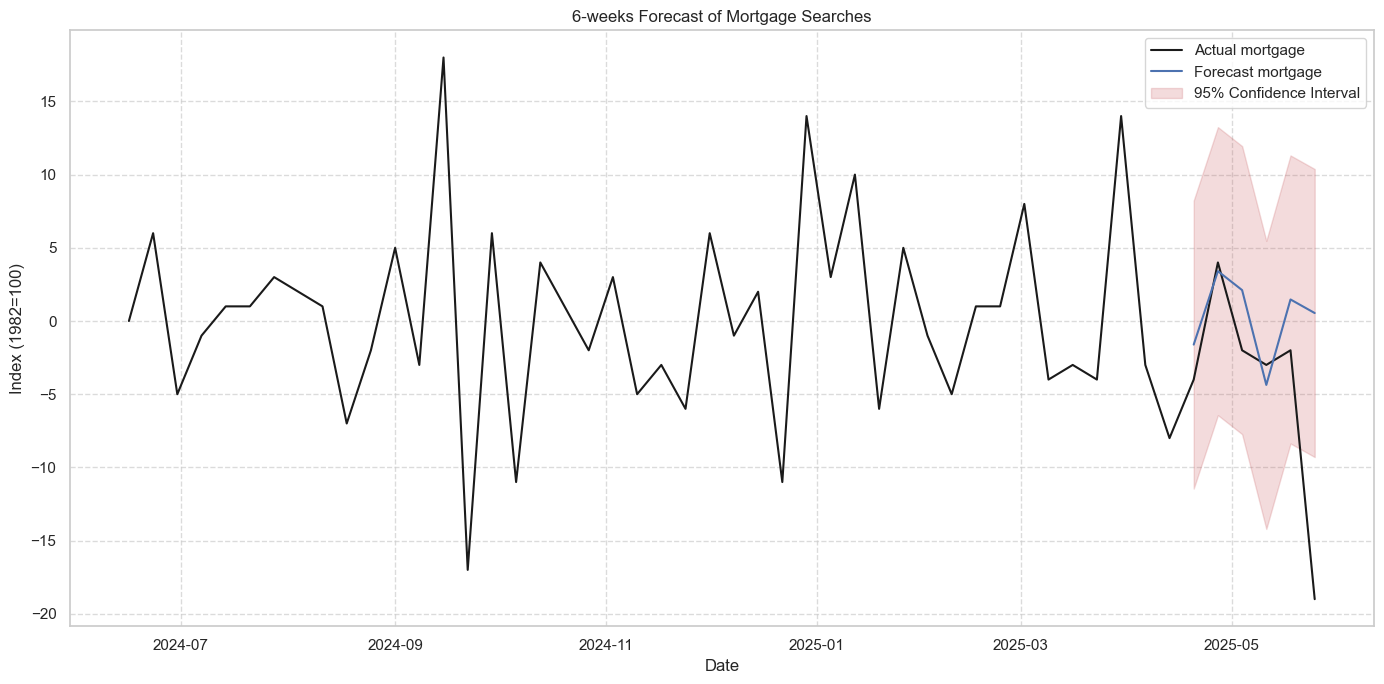

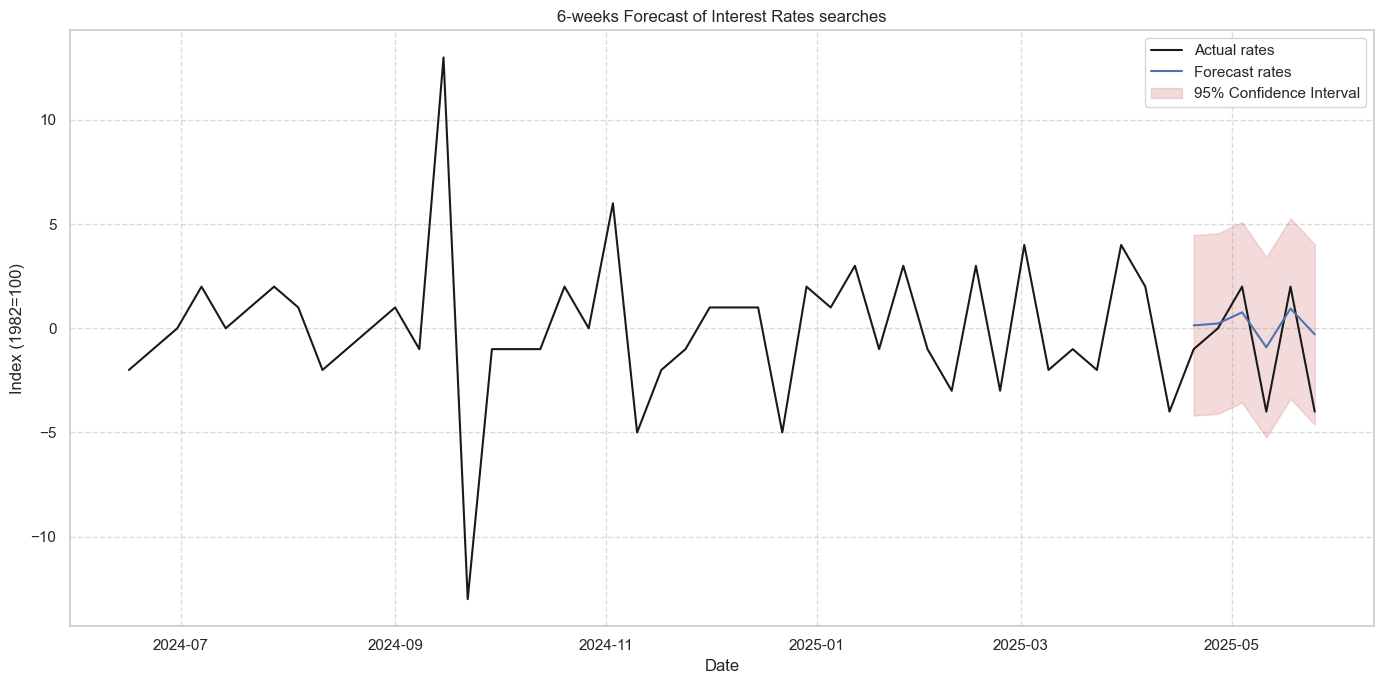

In [113]:
# Plot the mortgage forecasts vs actual values
plt.figure(figsize=(14, 7))

# Get the last 3 years of data for plotting context
plot_start_date = data_train.index[-14-36]  # 3 years before forecast start
plot_data = data_train.loc[plot_start_date:]

# Plot actual mortgage values (full history)
plt.plot(plot_data.index, plot_data['d_mortgage_world'], 'k-', label='Actual mortgage')

# Plot forecasted values
plt.plot(forecast_evaluation.index, forecast_evaluation['mortgage_forecast'], 'b-', label='Forecast mortgage')

# Plot confidence intervals
plt.fill_between(forecast_evaluation.index,
                forecast_evaluation['mortgage_lower'],
                forecast_evaluation['mortgage_upper'],
                color='r', alpha=0.2, label='95% Confidence Interval')

plt.title('6-weeks Forecast of Mortgage Searches')
plt.xlabel('Date')
plt.ylabel('Index (1982=100)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot the rates forecasts vs actual values
plt.figure(figsize=(14, 7))

# Plot actual rates values (full history)
plt.plot(plot_data.index, plot_data['d_rates_world'], 'k-', label='Actual rates')

# Plot forecasted values
plt.plot(forecast_evaluation.index, forecast_evaluation['rates_forecast'], 'b-', label='Forecast rates')

# Plot confidence intervals
plt.fill_between(forecast_evaluation.index,
                forecast_evaluation['rates_lower'],
                forecast_evaluation['rates_upper'],
                color='r', alpha=0.2, label='95% Confidence Interval')

plt.title('6-weeks Forecast of Interest Rates searches')
plt.xlabel('Date')
plt.ylabel('Index (1982=100)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [116]:
# Calculate forecast accuracy measures

# Define the function for MAPE and AMAPE
def mape(actual, pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - pred) / actual)) * 100

def amape(actual, pred):
    """Adjusted/Symmetric Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - pred) / ((actual + pred) / 2))) * 100

# Calculate metrics for mortgage
mortgage_mae = mean_absolute_error(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])
mortgage_mse = mean_squared_error(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])
mortgage_rmse = np.sqrt(mortgage_mse)
mortgage_mape = mape(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])
mortgage_amape = amape(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])

# Calculate metrics for rates
forecast_evaluation = forecast_evaluation[(forecast_evaluation['rates_actual']!=0)]
rates_mae = mean_absolute_error(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])
rates_mse = mean_squared_error(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])
rates_rmse = np.sqrt(rates_mse)
rates_mape = mape(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])
rates_amape = amape(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])

# Create a DataFrame to display the results
metrics_df = pd.DataFrame({
    'mortgage': [mortgage_mae, mortgage_mse, mortgage_rmse, mortgage_mape, mortgage_amape],
    'rates': [rates_mae, rates_mse, rates_rmse, rates_mape, rates_amape]
}, index=['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'AMAPE (%)'])

print("Forecast Accuracy Metrics:")
print(metrics_df)

Forecast Accuracy Metrics:
                 mortgage          rates
MAE          5.2458617050   2.0451217180
MSE         69.8094214262   5.4450921795
RMSE         8.3552032546   2.3334721296
MAPE (%)   100.3435477961  79.6606778659
AMAPE (%) 1523.5487984070 144.8141188699


### <a id="VAR-model-forecasting-US"></a>VAR model forecasting for US

We apply the same procedure as above for the US and Poland series.

In [118]:
adf_test(data['mortgage_US'])

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0       -6.4144289634            -3.4340000000   
1                        1       -4.6890846080            -3.4340000000   
2                        2       -4.1489676686            -3.4340000000   
3                        3       -3.2339545562            -3.4340000000   
4                        4       -3.4209100913            -3.4340000000   
5                        5       -3.9768153761            -3.4340000000   
6                        6       -4.0266869403            -3.4340000000   
7                        7       -4.4571331199            -3.4340000000   
8                        8       -4.1502499592            -3.4340000000   
9                        9       -4.6581683036            -3.4340000000   

   ADF critival value (5%)  ADF critival value (10%)  \
0            -2.8630000000             -2.5680000000   
1            -2.8630000000             -2.5680000000   
2            -2.8630000000             -2.5680000000   
3            -2.8630000000             -2.5680000000   
4            -2.8630000000             -2.5680000000   
5            -2.8630000000             -2.5680000000   
6            -2.8630000000             -2.5680000000   
7            -2.8630000000             -2.5680000000   
8            -2.8630000000             -2.5680000000   
9            -2.8630000000             -2.5680000000   

   BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                12.5527000000               0.0004000000   
1                 2.3497000000               0.1253000000   
2                20.7834000000               0.0000000000   
3                 2.7132000000               0.0995000000   
4                 1.2769000000               0.2585000000   
5                 1.2571000000               0.2622000000   
6                 2.0537000000               0.1518000000   
7                 0.1563000000               0.6926000000   
8                 5.9596000000               0.0146000000   
9                 2.2167000000               0.1365000000   

   BG test (5 lags) (statistic)  BG test (5 lags) (p-value)  \
0                 36.4463000000                0.0000000000   
1                 25.4007000000                0.0001000000   
2                 25.5660000000                0.0001000000   
3                  6.0656000000                0.2999000000   
4                 14.2870000000                0.0139000000   
5                  8.0772000000                0.1520000000   
6                 16.3939000000                0.0058000000   
7                  8.2054000000                0.1453000000   
8                 13.3463000000                0.0203000000   
9                 10.0146000000                0.0748000000   

   BG test (10 lags) (statistic)  BG test (10 lags) (p-value)  \
0                  50.7887000000                 0.0000000000   
1                  39.4523000000                 0.0000000000   
2                  40.0479000000                 0.0000000000   
3                  17.4260000000                 0.0655000000   
4                  23.2449000000                 0.0099000000   
5                  14.1504000000                 0.1662000000   
6                  19.0293000000                 0.0399000000   
7                  10.5020000000                 0.3976000000   
8                  17.9709000000                 0.0555000000   
9                  13.8451000000                 0.1802000000   

   BG test (15 lags) (statistic)  BG test (15 lags) (p-value)  
0                  56.9929000000                 0.0000000000  
1                  47.5248000000                 0.0000000000  
2                  47.1764000000                 0.0000000000  
3                  25.7702000000                 0.0405000000  
4                  28.9169000000                 0.0165000000  
5                  28.0644000000                 0.0212000000  
6                  25.39590000

In [119]:
data['d_mortgage_US']=data['mortgage_US'].diff()
adf_test(data['d_mortgage_US'])

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0      -22.4483883916            -3.4340000000   
1                        1      -15.2581508824            -3.4340000000   
2                        2      -15.2471633216            -3.4340000000   
3                        3       -9.9954133940            -3.4340000000   
4                        4       -8.0978075709            -3.4340000000   
5                        5       -7.6277239605            -3.4340000000   
6                        6       -6.5395637788            -3.4340000000   
7                        7       -6.4458751420            -3.4340000000   
8                        8       -5.2265312266            -3.4340000000   
9                        9       -5.9742316216            -3.4340000000   

   ADF critival value (5%)  ADF critival value (10%)  \
0            -2.8630000000             -2.5680000000   
1            -2.8630000000             -2.5680000000   
2            -2.8630000000             -2.5680000000   
3            -2.8630000000             -2.5680000000   
4            -2.8630000000             -2.5680000000   
5            -2.8630000000             -2.5680000000   
6            -2.8630000000             -2.5680000000   
7            -2.8630000000             -2.5680000000   
8            -2.8630000000             -2.5680000000   
9            -2.8630000000             -2.5680000000   

   BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                 6.9437000000               0.0084000000   
1                27.4815000000               0.0000000000   
2                 1.4574000000               0.2274000000   
3                 0.1842000000               0.6678000000   
4                 0.1144000000               0.7352000000   
5                 0.0000000000               0.9959000000   
6                 2.2966000000               0.1297000000   
7                 2.0651000000               0.1507000000   
8                 8.5869000000               0.0034000000   
9                 0.2090000000               0.6476000000   

   BG test (5 lags) (statistic)  BG test (5 lags) (p-value)  \
0                 34.2062000000                0.0000000000   
1                 29.0409000000                0.0000000000   
2                  3.3840000000                0.6410000000   
3                  8.3737000000                0.1368000000   
4                  3.0417000000                0.6936000000   
5                  8.9772000000                0.1100000000   
6                  7.7494000000                0.1706000000   
7                  9.1339000000                0.1038000000   
8                 15.6761000000                0.0078000000   
9                  9.4970000000                0.0908000000   

   BG test (10 lags) (statistic)  BG test (10 lags) (p-value)  \
0                  45.0312000000                 0.0000000000   
1                  43.7098000000                 0.0000000000   
2                  15.4646000000                 0.1160000000   
3                  16.8350000000                 0.0781000000   
4                  11.4872000000                 0.3208000000   
5                  13.2245000000                 0.2114000000   
6                  12.0574000000                 0.2812000000   
7                  16.7129000000                 0.0810000000   
8                  23.3853000000                 0.0094000000   
9                  16.9117000000                 0.0763000000   

   BG test (15 lags) (statistic)  BG test (15 lags) (p-value)  
0                  52.0125000000                 0.0000000000  
1                  49.8624000000                 0.0000000000  
2                  24.0753000000                 0.0638000000  
3                  24.2590000000                 0.0608000000  
4                  22.9614000000                 0.0850000000  
5                  19.6032000000                 0.1877000000  
6                  22.02870000

In [120]:
adf_test(data['rates_US'], max_aug=20)

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                         0       -7.2585360618            -3.4340000000   
1                         1       -5.0161987526            -3.4340000000   
2                         2       -4.0623440007            -3.4340000000   
3                         3       -3.1964742947            -3.4340000000   
4                         4       -2.7431885666            -3.4340000000   
5                         5       -1.9327618770            -3.4340000000   
6                         6       -1.8888785488            -3.4340000000   
7                         7       -1.9211074705            -3.4340000000   
8                         8       -2.0234343689            -3.4340000000   
9                         9       -2.1046321482            -3.4340000000   
10                       10       -2.0901100580            -3.4340000000   
11                       11       -2.1521037540            -3.4340000000   
12                       12       -1.8573544581            -3.4340000000   
13                       13       -1.7307578806            -3.4340000000   
14                       14       -1.7358483333            -3.4340000000   
15                       15       -1.6687827093            -3.4340000000   
16                       16       -1.6046954426            -3.4340000000   
17                       17       -1.5688091442            -3.4340000000   
18                       18       -1.5411812050            -3.4340000000   
19                       19       -1.3479506522            -3.4340000000   

    ADF critival value (5%)  ADF critival value (10%)  \
0             -2.8630000000             -2.5680000000   
1             -2.8630000000             -2.5680000000   
2             -2.8630000000             -2.5680000000   
3             -2.8630000000             -2.5680000000   
4             -2.8630000000             -2.5680000000   
5             -2.8630000000             -2.5680000000   
6             -2.8630000000             -2.5680000000   
7             -2.8630000000             -2.5680000000   
8             -2.8630000000             -2.5680000000   
9             -2.8630000000             -2.5680000000   
10            -2.8630000000             -2.5680000000   
11            -2.8630000000             -2.5680000000   
12            -2.8630000000             -2.5680000000   
13            -2.8630000000             -2.5680000000   
14            -2.8630000000             -2.5680000000   
15            -2.8630000000             -2.5680000000   
16            -2.8630000000             -2.5680000000   
17            -2.8630000000             -2.5680000000   
18            -2.8630000000             -2.5680000000   
19            -2.8630000000             -2.5680000000   

    BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                 19.2596000000               0.0000000000   
1                  6.5291000000               0.0106000000   
2                 11.5991000000               0.0007000000   
3                  5.0815000000               0.0242000000   
4                 31.5830000000               0.0000000000   
5                  0.0980000000               0.7543000000   
6                  0.4987000000               0.4801000000   
7                  0.4551000000               0.4999000000   
8                  0.6829000000               0.4086000000   
9                  0.0053000000               0.9418000000   
10                 0.1058000000               0.7450000000   
11                 5.3635000000               0.0206000000   
12                 2.4733000000               0.1158000000   
13                 0.0134000000               0.9080000000   
14                 0.1494000000               0.6991000000   
15                 0.1824000000               0.6693000000   
16                 0.2893000000               0.5907000000   
17                 0.1812000000               0.6704000000   
18                 7.4770000000

In [121]:
data['d_rates_US']=data['rates_US'].diff()
adf_test(data['d_rates_US'])

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0      -24.3223212950            -3.4340000000   
1                        1      -16.9296035874            -3.4340000000   
2                        2      -15.0817796050            -3.4340000000   
3                        3      -12.9521844001            -3.4340000000   
4                        4      -14.7160908015            -3.4340000000   
5                        5      -11.0267106834            -3.4340000000   
6                        6       -8.6277800134            -3.4340000000   
7                        7       -7.0979463205            -3.4340000000   
8                        8       -6.1603381008            -3.4340000000   
9                        9       -5.7477062591            -3.4340000000   

   ADF critival value (5%)  ADF critival value (10%)  \
0            -2.8630000000             -2.5680000000   
1            -2.8630000000             -2.5680000000   
2            -2.8630000000             -2.5680000000   
3            -2.8630000000             -2.5680000000   
4            -2.8630000000             -2.5680000000   
5            -2.8630000000             -2.5680000000   
6            -2.8630000000             -2.5680000000   
7            -2.8630000000             -2.5680000000   
8            -2.8630000000             -2.5680000000   
9            -2.8630000000             -2.5680000000   

   BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                14.1538000000               0.0002000000   
1                17.2002000000               0.0000000000   
2                 7.6089000000               0.0058000000   
3                35.0349000000               0.0000000000   
4                 0.2631000000               0.6080000000   
5                 0.2417000000               0.6230000000   
6                 0.1004000000               0.7513000000   
7                 0.3022000000               0.5825000000   
8                 0.0481000000               0.8264000000   
9                 0.1397000000               0.7086000000   

   BG test (5 lags) (statistic)  BG test (5 lags) (p-value)  \
0                 68.0544000000                0.0000000000   
1                 56.2383000000                0.0000000000   
2                 41.8436000000                0.0000000000   
3                 36.0307000000                0.0000000000   
4                  1.3294000000                0.9319000000   
5                  1.1839000000                0.9464000000   
6                  0.8618000000                0.9729000000   
7                  2.8872000000                0.7174000000   
8                  9.7114000000                0.0838000000   
9                  9.2469000000                0.0996000000   

   BG test (10 lags) (statistic)  BG test (10 lags) (p-value)  \
0                  68.7709000000                 0.0000000000   
1                  58.1649000000                 0.0000000000   
2                  47.9656000000                 0.0000000000   
3                  43.4622000000                 0.0000000000   
4                  13.1210000000                 0.2170000000   
5                  13.2223000000                 0.2115000000   
6                  12.8633000000                 0.2314000000   
7                  12.1261000000                 0.2767000000   
8                  10.8301000000                 0.3709000000   
9                  10.5312000000                 0.3952000000   

   BG test (15 lags) (statistic)  BG test (15 lags) (p-value)  
0                  78.2381000000                 0.0000000000  
1                  67.5911000000                 0.0000000000  
2                  53.6468000000                 0.0000000000  
3                  48.7449000000                 0.0000000000  
4                  25.4679000000                 0.0440000000  
5                  24.9688000000                 0.0504000000  
6                  23.21910000

We can see that both of the series for US are integrated of order 1 - the first differences are stationary.

In [124]:
grangercausalitytests(data[['d_mortgage_US', 'd_rates_US']].dropna(), maxlag=5)
grangercausalitytests(data[['d_rates_US', 'd_mortgage_US']].dropna(), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4446  , p=0.5055  , df_denom=257, df_num=1
ssr based chi2 test:   chi2=0.4498  , p=0.5024  , df=1
likelihood ratio test: chi2=0.4494  , p=0.5026  , df=1
parameter F test:         F=0.4446  , p=0.5055  , df_denom=257, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5517  , p=0.5767  , df_denom=254, df_num=2
ssr based chi2 test:   chi2=1.1251  , p=0.5698  , df=2
likelihood ratio test: chi2=1.1226  , p=0.5705  , df=2
parameter F test:         F=0.5517  , p=0.5767  , df_denom=254, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3514  , p=0.7882  , df_denom=251, df_num=3
ssr based chi2 test:   chi2=1.0835  , p=0.7810  , df=3
likelihood ratio test: chi2=1.0813  , p=0.7816  , df=3
parameter F test:         F=0.3514  , p=0.7882  , df_denom=251, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4390  , p=0.7804  

{np.int64(1): ({'ssr_ftest': (np.float64(0.24755770591739862),
    np.float64(0.6192254755957223),
    np.float64(257.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.2504474845856951),
    np.float64(0.6167601659345832),
    np.int64(1)),
   'lrtest': (np.float64(0.2503269390240348),
    np.float64(0.616844963684809),
    np.int64(1)),
   'params_ftest': (np.float64(0.2475577059173476),
    np.float64(0.6192254755957627),
    np.float64(257.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.9261983720445908),
    np.float64(0.39738989903278366),
    np.float64(254.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(1.888861246925583),
    np.float64(0.3889009389448212),
    np.int64(2)),
   'lrtest': (np.float64(1.8820069134362711),
    np.float64(0.390236053833616),
    np.int64(2)),
   'params_ftest': (np.float64(0.926198372044571),
    np.float64(0.39738989903279487),
    np.float64(254.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
       

Based on the above results we conclude that  ***rates*** Granger causes ***mortgage*** at the 5% significance level. Hence, we can conclude that ***rates*** is a Granger cause of  ***mortgage***. Other way around the Granger causality does not occur - ***mortgage*** does not Granger causes ***rates***. Let's estimate the VAR model.

In [122]:
data_train_US = data[['d_mortgage_US', 'd_rates_US']].dropna()
forecast_horizon = 6
data_train_short_US = data_train_US.iloc[:-forecast_horizon]

model = VAR(data_train_US, freq='W')
results = model.select_order(maxlags=15)
print("\nLag selection results:")
print(results.summary())


Lag selection results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        5.901       5.930       365.5       5.913
1        5.655       5.741       285.8       5.690
2        5.585       5.728       266.4       5.642
3        5.426       5.626       227.3       5.507
4        5.412       5.668       224.0       5.515
5       5.254*      5.568*      191.4*      5.380*
6        5.270       5.641       194.5       5.419
7        5.280       5.707       196.3       5.452
8        5.293       5.778       199.1       5.488
9        5.313       5.854       203.0       5.531
10       5.309       5.908       202.4       5.550
11       5.329       5.985       206.5       5.593
12       5.296       6.009       199.8       5.583
13       5.295       6.065       199.7       5.605
14       5.273       6.099       195.4       5.606
15       5.273       6.157       195.6       5.629
-------

We choose the model with 5 lags, based on all of the information criteria.

In [125]:
var5_model_US = VAR(data_train_US, freq='W')
var5_results_US = var5_model_US.fit(5)

print(var5_results_US.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Jul, 2025
Time:                     10:10:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.51856
Nobs:                     256.000    HQIC:                   5.33643
Log likelihood:          -1371.87    FPE:                    183.828
AIC:                      5.21389    Det(Omega_mle):         168.993
--------------------------------------------------------------------
Results for equation d_mortgage_US
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.224682         0.394232           -0.570           0.569
L1.d_mortgage_US        -0.355501         0.075552           -4.705           0.000
L1.d_rates_US           -0.333038       

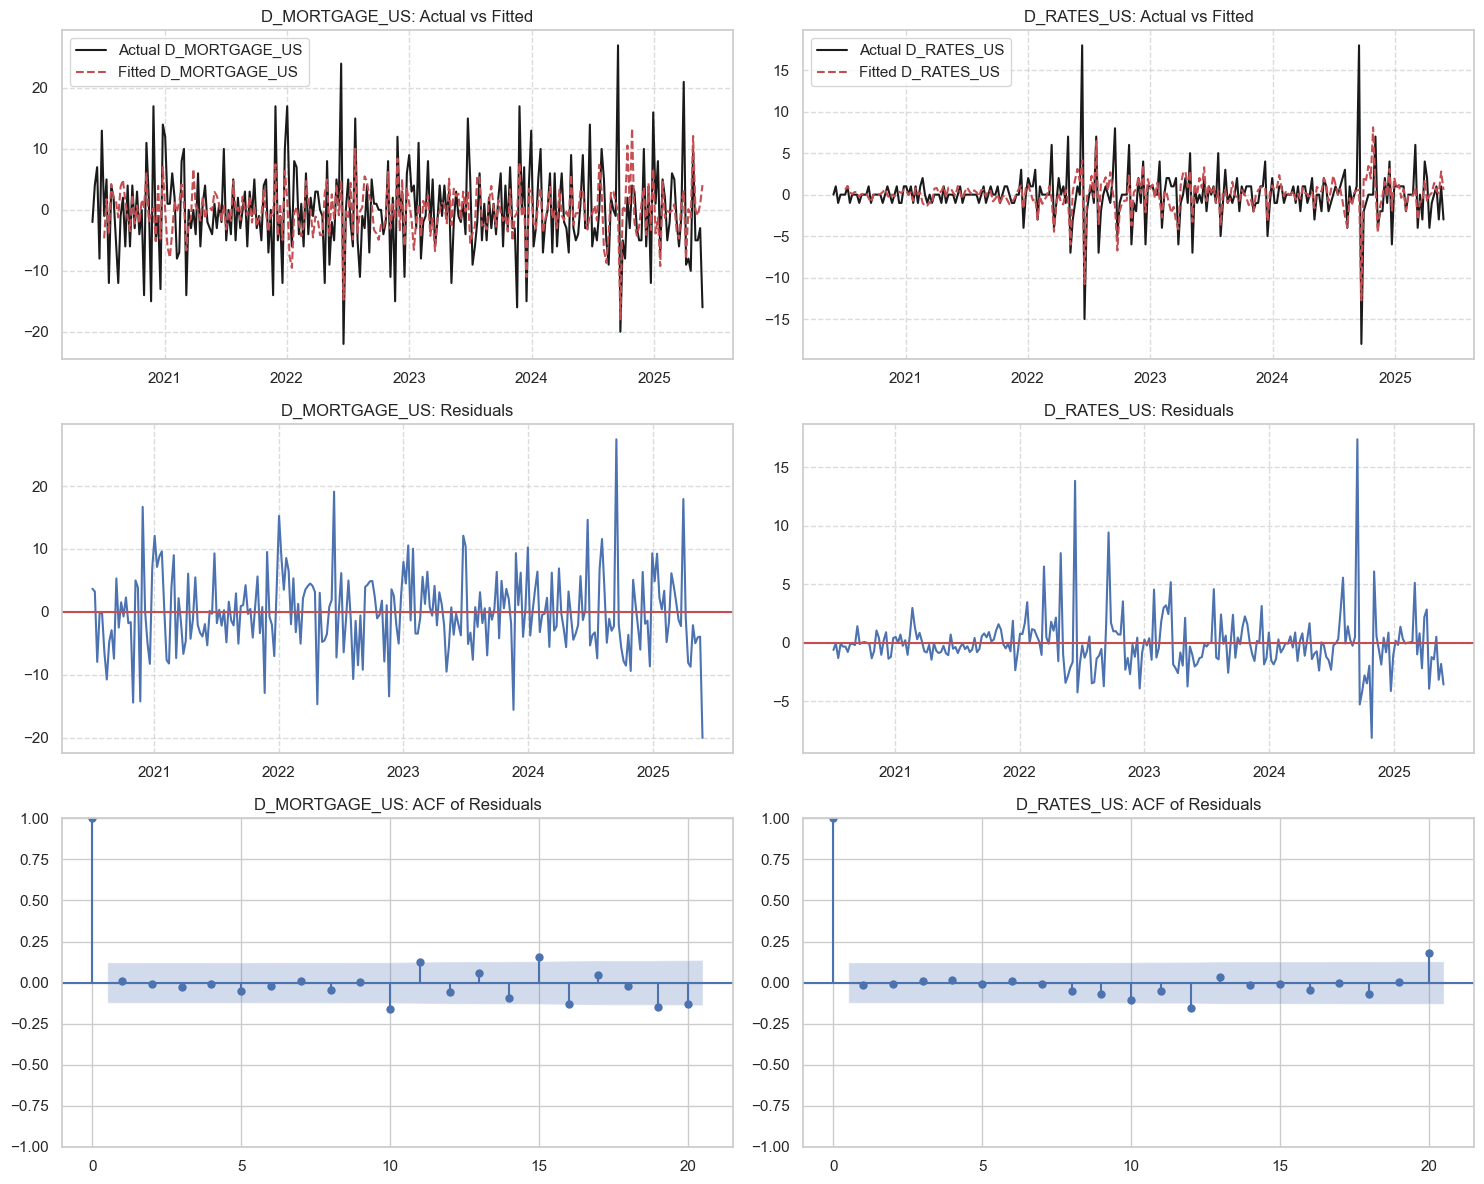

In [127]:
# Plot fitted values vs actual values, residuals, and ACF/PACF
fig = plt.figure(figsize=(15, 12))

# Fitted values vs actual values for each variable
for i, name in enumerate(data_train_US.columns):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(data_train_US.index, data_train_US[name], 'k-', label=f'Actual {name.upper()}')
    ax.plot(var5_results_US.fittedvalues[name].index, var5_results_US.fittedvalues[name], 'r--',
            label=f'Fitted {name.upper()}')
    ax.set_title(f'{name.upper()}: Actual vs Fitted')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Residuals for each variable
for i, name in enumerate(data_train_US.columns):
    ax = fig.add_subplot(3, 2, i+3)
    residuals = var5_results_US.resid[name]
    ax.plot(residuals.index, residuals, 'b-')
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_title(f'{name.upper()}: Residuals')
    ax.grid(True, linestyle='--', alpha=0.7)

# ACF and PACF for residuals
for i, name in enumerate(data_train_US.columns):
    ax = fig.add_subplot(3, 2, i+5)
    residuals = var5_results_US.resid[name].values
    plot_acf(residuals, ax=ax, lags=20, alpha=0.05, title=f'{name.upper()}: ACF of Residuals')

plt.tight_layout()
plt.show()

In [128]:
# Perform Ljung-Box test for autocorrelation of residuals (equivalent to Portmanteau test)
residuals = var5_results_US.resid

print("Ljung-Box Test for Residual Autocorrelation:")
for name in residuals.columns:
    lb_test = acorr_ljungbox(residuals[name], lags=[12, 24])
    print(f"\n{name.upper()} series:")
    print(f"Lag 12: p-value = {lb_test.iloc[0, 1]:.4f}")
    print(f"Lag 24: p-value = {lb_test.iloc[1, 1]:.4f}")

Ljung-Box Test for Residual Autocorrelation:

D_MORTGAGE_US series:
Lag 12: p-value = 0.3419
Lag 24: p-value = 0.0009

D_RATES_US series:
Lag 12: p-value = 0.4160
Lag 24: p-value = 0.2791


The VAR(5) model for US series is performing well. Let's create a forecast for 6 weeks using the VAR(5) model.

In [130]:
forecast_horizon = 6
print("Original data shape:", data_train_US.shape)
print("Training data shape:", data_train_short_US.shape)
print("Last date in training data:", data_train_short_US.index[-1].strftime('%d-%m-%Y'))

# Fit VAR(6) model on the shorter sample
var5_short_model_US = VAR(data_train_short_US, freq='W')
var5_short_results_US = var5_short_model_US.fit(5)

# Generate forecasts
forecast = var5_short_results_US.forecast(data_train_short_US.values, steps=forecast_horizon)
forecast_index = pd.date_range(start=data_train_short_US.index[-1] + pd.DateOffset(weeks=1), periods=forecast_horizon, freq='W')

# Create a DataFrame for the forecasts
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data_train_US.columns)

print("\nForecast results:")
print(forecast_df)

Original data shape: (261, 2)
Training data shape: (255, 2)
Last date in training data: 13-04-2025

Forecast results:
            d_mortgage_US    d_rates_US
2025-04-20  -0.6808650972  0.3110482299
2025-04-27   8.8362845701  0.9767592430
2025-05-04  -2.5199836332 -0.7756490422
2025-05-11  -3.6416604118  0.5444671502
2025-05-18   1.0468696811  0.8841540343
2025-05-25   1.4653316951 -0.9048235353


In [131]:
forecast_mean, forecast_lower, forecast_upper = compute_forecast_ci(
    var5_short_results_US, data_train_short_US.values, forecast_horizon, alpha=0.05
)

# Create DataFrames for the confidence intervals
forecast_lower_df = pd.DataFrame(forecast_lower, index=forecast_index,
                               columns=[f"{col}_lower" for col in data_train_US.columns])
forecast_upper_df = pd.DataFrame(forecast_upper, index=forecast_index,
                               columns=[f"{col}_upper" for col in data_train_US.columns])

# Combine the forecasts and actual values
forecast_evaluation = pd.concat([
    data_train_US.loc[forecast_index],
    forecast_df,
    forecast_lower_df,
    forecast_upper_df
], axis=1)

forecast_evaluation.columns = [
    'mortgage_actual', 'rates_actual',
    'mortgage_forecast', 'rates_forecast',
    'mortgage_lower', 'rates_lower',
    'mortgage_upper', 'rates_upper'
]

print("Forecast evaluation dataset:")
print(forecast_evaluation)


Forecast evaluation dataset:
            mortgage_actual  rates_actual  mortgage_forecast  rates_forecast  \
2025-04-20   -10.0000000000 -1.0000000000      -0.6808650972    0.3110482299   
2025-04-27    10.0000000000  0.0000000000       8.8362845701    0.9767592430   
2025-05-04    -5.0000000000  1.0000000000      -2.5199836332   -0.7756490422   
2025-05-11    -5.0000000000 -3.0000000000      -3.6416604118    0.5444671502   
2025-05-18    -3.0000000000  1.0000000000       1.0468696811    0.8841540343   
2025-05-25   -16.0000000000 -3.0000000000       1.4653316951   -0.9048235353   

            mortgage_lower   rates_lower  mortgage_upper  rates_upper  
2025-04-20  -12.7935030768 -4.5235085108   11.4317728823 5.1456049706  
2025-04-27   -3.2763534094 -3.8577974977   20.9489225497 5.8113159837  
2025-05-04  -14.6326216127 -5.6102057829    9.5926543463 4.0589076985  
2025-05-11  -15.7542983914 -4.2900895905    8.4709775677 5.3790238909  
2025-05-18  -11.0657682985 -3.9504027064   13.1595

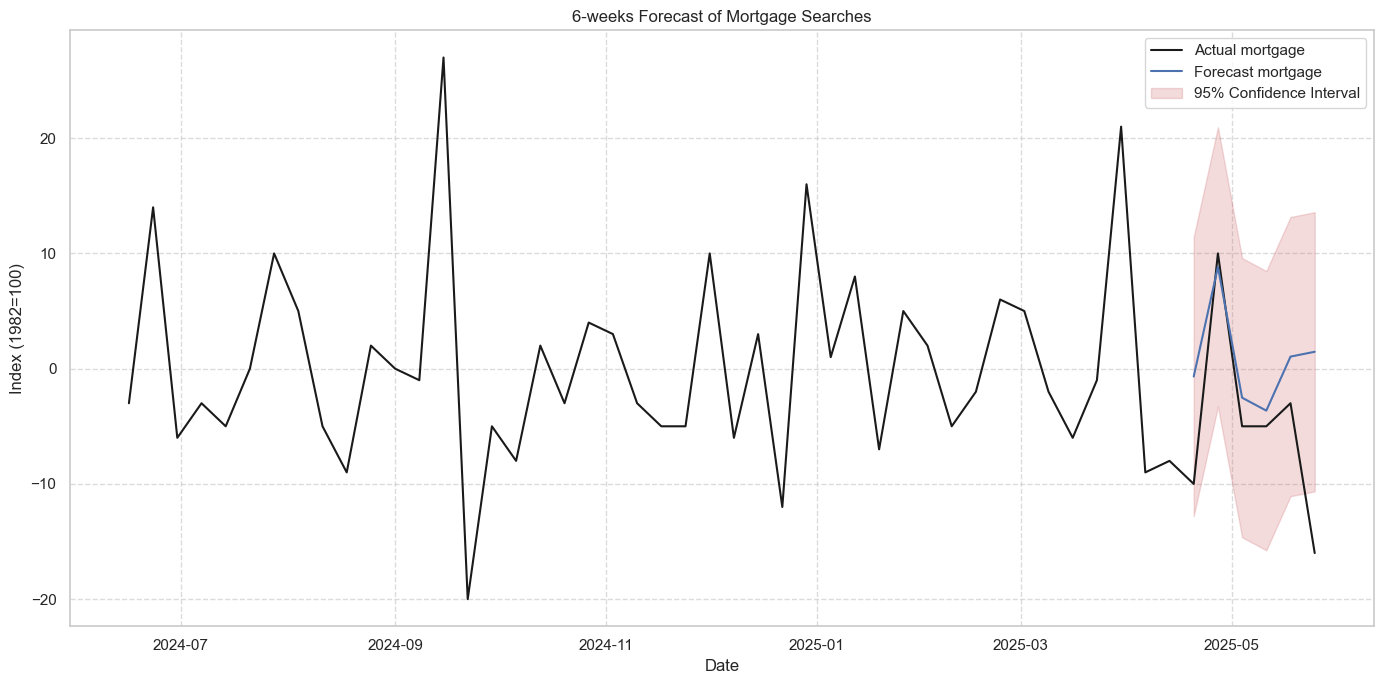

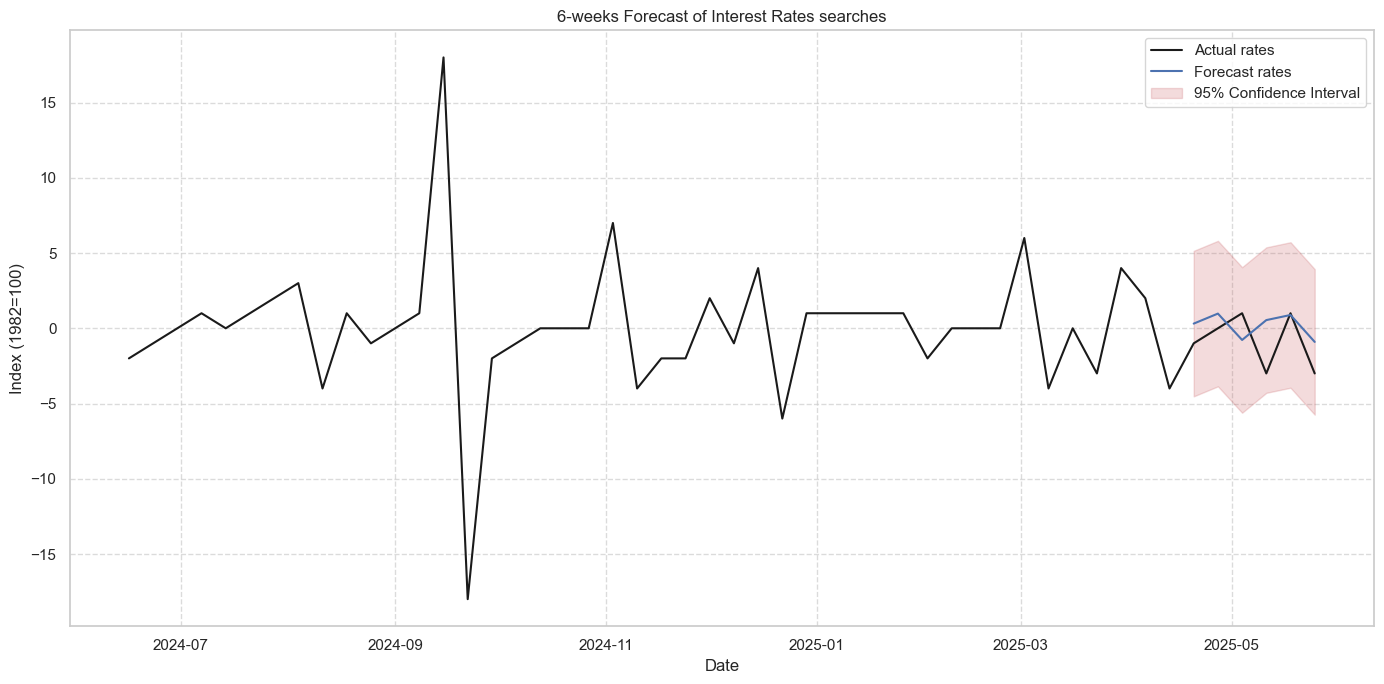

In [133]:
# Plot the mortgage forecasts vs actual values
plt.figure(figsize=(14, 7))

# Get the last 3 years of data for plotting context
plot_start_date = data_train_US.index[-14-36]  # 3 years before forecast start
plot_data = data_train_US.loc[plot_start_date:]

# Plot actual mortgage values (full history)
plt.plot(plot_data.index, plot_data['d_mortgage_US'], 'k-', label='Actual mortgage')

# Plot forecasted values
plt.plot(forecast_evaluation.index, forecast_evaluation['mortgage_forecast'], 'b-', label='Forecast mortgage')

# Plot confidence intervals
plt.fill_between(forecast_evaluation.index,
                forecast_evaluation['mortgage_lower'],
                forecast_evaluation['mortgage_upper'],
                color='r', alpha=0.2, label='95% Confidence Interval')

plt.title('6-weeks Forecast of Mortgage Searches')
plt.xlabel('Date')
plt.ylabel('Index (1982=100)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot the rates forecasts vs actual values
plt.figure(figsize=(14, 7))

# Plot actual rates values (full history)
plt.plot(plot_data.index, plot_data['d_rates_US'], 'k-', label='Actual rates')

# Plot forecasted values
plt.plot(forecast_evaluation.index, forecast_evaluation['rates_forecast'], 'b-', label='Forecast rates')

# Plot confidence intervals
plt.fill_between(forecast_evaluation.index,
                forecast_evaluation['rates_lower'],
                forecast_evaluation['rates_upper'],
                color='r', alpha=0.2, label='95% Confidence Interval')

plt.title('6-weeks Forecast of Interest Rates searches')
plt.xlabel('Date')
plt.ylabel('Index (1982=100)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [135]:
# Calculate metrics for mortgage
mortgage_mae = mean_absolute_error(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])
mortgage_mse = mean_squared_error(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])
mortgage_rmse = np.sqrt(mortgage_mse)
mortgage_mape = mape(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])
mortgage_amape = amape(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])

# Calculate metrics for rates
forecast_evaluation = forecast_evaluation[(forecast_evaluation['rates_actual']!=0)] #to get rid of the 0 values in actuals that are problematic with the MAPE metric
rates_mae = mean_absolute_error(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])
rates_mse = mean_squared_error(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])
rates_rmse = np.sqrt(rates_mse)
rates_mape = mape(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])
rates_amape = amape(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])

# Create a DataFrame to display the results
metrics_df_US = pd.DataFrame({
    'mortgage': [mortgage_mae, mortgage_mse, mortgage_rmse, mortgage_mape, mortgage_amape],
    'rates': [rates_mae, rates_mse, rates_rmse, rates_mape, rates_amape]
}, index=['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'AMAPE (%)'])

print("Forecast Accuracy Metrics:")
print(metrics_df_US)

Forecast Accuracy Metrics:
                mortgage          rates
MAE         5.9722346106   1.7684373705
MSE        69.6018403315   4.3676418135
RMSE        8.3427717415   2.0898903831
MAPE (%)   70.9416002593 101.6484888555
AMAPE (%) 156.4962477703 474.3628811780


### <a id="VAR-model-forecasting-Poland"></a>VAR model forecasting for Poland

In [137]:
adf_test(data['mortgage_Poland'])

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0       -6.1065641447            -3.4340000000   
1                        1       -4.4072742886            -3.4340000000   
2                        2       -3.2359942725            -3.4340000000   
3                        3       -2.7438701821            -3.4340000000   
4                        4       -2.3748090226            -3.4340000000   
5                        5       -2.1719441543            -3.4340000000   
6                        6       -1.9774517777            -3.4340000000   
7                        7       -1.9811452233            -3.4340000000   
8                        8       -1.7107250256            -3.4340000000   
9                        9       -1.5702918353            -3.4340000000   

   ADF critival value (5%)  ADF critival value (10%)  \
0            -2.8630000000             -2.5680000000   
1            -2.8630000000             -2.5680000000   
2            -2.8630000000             -2.5680000000   
3            -2.8630000000             -2.5680000000   
4            -2.8630000000             -2.5680000000   
5            -2.8630000000             -2.5680000000   
6            -2.8630000000             -2.5680000000   
7            -2.8630000000             -2.5680000000   
8            -2.8630000000             -2.5680000000   
9            -2.8630000000             -2.5680000000   

   BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                16.6527000000               0.0000000000   
1                18.0414000000               0.0000000000   
2                 5.7170000000               0.0168000000   
3                 2.5609000000               0.1095000000   
4                 1.1625000000               0.2810000000   
5                 2.4297000000               0.1191000000   
6                 0.0003000000               0.9872000000   
7                 0.7322000000               0.3922000000   
8                 2.5579000000               0.1097000000   
9                 1.0886000000               0.2968000000   

   BG test (5 lags) (statistic)  BG test (5 lags) (p-value)  \
0                 38.9822000000                0.0000000000   
1                 28.2525000000                0.0000000000   
2                 11.8576000000                0.0368000000   
3                  6.7560000000                0.2394000000   
4                  7.3055000000                0.1989000000   
5                  9.4649000000                0.0919000000   
6                  7.4318000000                0.1905000000   
7                  7.9849000000                0.1571000000   
8                  9.0264000000                0.1080000000   
9                  3.7147000000                0.5912000000   

   BG test (10 lags) (statistic)  BG test (10 lags) (p-value)  \
0                  41.4627000000                 0.0000000000   
1                  35.0769000000                 0.0001000000   
2                  21.9561000000                 0.0153000000   
3                  17.0675000000                 0.0729000000   
4                  15.3291000000                 0.1205000000   
5                  13.5840000000                 0.1928000000   
6                  10.8902000000                 0.3661000000   
7                  10.7886000000                 0.3742000000   
8                  10.6361000000                 0.3866000000   
9                   8.6275000000                 0.5678000000   

   BG test (15 lags) (statistic)  BG test (15 lags) (p-value)  
0                  53.2171000000                 0.0000000000  
1                  42.6731000000                 0.0002000000  
2                  26.9772000000                 0.0289000000  
3                  22.3733000000                 0.0984000000  
4                  19.5629000000                 0.1893000000  
5                  19.4098000000                 0.1958000000  
6                  17.00240000

In [138]:
data['d_mortgage_Poland']=data['mortgage_Poland'].diff()
adf_test(data['d_mortgage_Poland'])

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0      -23.0318121476            -3.4340000000   
1                        1      -18.1623446190            -3.4340000000   
2                        2      -14.3625042155            -3.4340000000   
3                        3      -12.1009064098            -3.4340000000   
4                        4      -10.5478804081            -3.4340000000   
5                        5       -9.7412057379            -3.4340000000   
6                        6       -8.3379610102            -3.4340000000   
7                        7       -8.3337183407            -3.4340000000   
8                        8       -8.2928703008            -3.4340000000   
9                        9       -7.9559880305            -3.4340000000   

   ADF critival value (5%)  ADF critival value (10%)  \
0            -2.8630000000             -2.5680000000   
1            -2.8630000000             -2.5680000000   
2            -2.8630000000             -2.5680000000   
3            -2.8630000000             -2.5680000000   
4            -2.8630000000             -2.5680000000   
5            -2.8630000000             -2.5680000000   
6            -2.8630000000             -2.5680000000   
7            -2.8630000000             -2.5680000000   
8            -2.8630000000             -2.5680000000   
9            -2.8630000000             -2.5680000000   

   BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                25.7853000000               0.0000000000   
1                 8.4937000000               0.0036000000   
2                 4.3153000000               0.0378000000   
3                 2.0829000000               0.1490000000   
4                 3.2084000000               0.0733000000   
5                 0.0338000000               0.8541000000   
6                 2.3254000000               0.1273000000   
7                 3.0256000000               0.0820000000   
8                 1.4134000000               0.2345000000   
9                 2.9096000000               0.0881000000   

   BG test (5 lags) (statistic)  BG test (5 lags) (p-value)  \
0                 40.9189000000                0.0000000000   
1                 17.8023000000                0.0032000000   
2                 14.2514000000                0.0141000000   
3                 10.7292000000                0.0570000000   
4                 12.0955000000                0.0335000000   
5                 10.0664000000                0.0734000000   
6                 10.9347000000                0.0527000000   
7                 10.6069000000                0.0598000000   
8                  4.9125000000                0.4267000000   
9                  4.6686000000                0.4576000000   

   BG test (10 lags) (statistic)  BG test (10 lags) (p-value)  \
0                  51.5875000000                 0.0000000000   
1                  29.7374000000                 0.0009000000   
2                  23.0694000000                 0.0105000000   
3                  19.1000000000                 0.0390000000   
4                  16.7964000000                 0.0790000000   
5                  13.6346000000                 0.1903000000   
6                  13.5179000000                 0.1961000000   
7                  12.9123000000                 0.2286000000   
8                   9.5335000000                 0.4823000000   
9                   8.5375000000                 0.5765000000   

   BG test (15 lags) (statistic)  BG test (15 lags) (p-value)  
0                  56.6886000000                 0.0000000000  
1                  34.0443000000                 0.0034000000  
2                  26.9458000000                 0.0292000000  
3                  22.5577000000                 0.0940000000  
4                  21.2906000000                 0.1278000000  
5                  18.3950000000                 0.2425000000  
6                  21.55380000

In [139]:
adf_test(data['rates_Poland'])

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0       -8.9998229037            -3.4340000000   
1                        1       -5.8023696443            -3.4340000000   
2                        2       -4.0556277674            -3.4340000000   
3                        3       -3.1801734569            -3.4340000000   
4                        4       -2.6335740463            -3.4340000000   
5                        5       -2.3395527769            -3.4340000000   
6                        6       -2.0453595946            -3.4340000000   
7                        7       -2.0275374804            -3.4340000000   
8                        8       -1.9908895176            -3.4340000000   
9                        9       -1.9610004892            -3.4340000000   

   ADF critival value (5%)  ADF critival value (10%)  \
0            -2.8630000000             -2.5680000000   
1            -2.8630000000             -2.5680000000   
2            -2.8630000000             -2.5680000000   
3            -2.8630000000             -2.5680000000   
4            -2.8630000000             -2.5680000000   
5            -2.8630000000             -2.5680000000   
6            -2.8630000000             -2.5680000000   
7            -2.8630000000             -2.5680000000   
8            -2.8630000000             -2.5680000000   
9            -2.8630000000             -2.5680000000   

   BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                20.9856000000               0.0000000000   
1                21.5189000000               0.0000000000   
2                10.7102000000               0.0011000000   
3                 9.0458000000               0.0026000000   
4                 5.9432000000               0.0148000000   
5                 1.8513000000               0.1736000000   
6                 0.0362000000               0.8491000000   
7                 1.3686000000               0.2421000000   
8                 1.3760000000               0.2408000000   
9                 0.8825000000               0.3475000000   

   BG test (5 lags) (statistic)  BG test (5 lags) (p-value)  \
0                 44.2199000000                0.0000000000   
1                 45.4094000000                0.0000000000   
2                 28.9487000000                0.0000000000   
3                 18.0582000000                0.0029000000   
4                 10.0744000000                0.0732000000   
5                  5.7527000000                0.3310000000   
6                  3.3379000000                0.6480000000   
7                  4.3120000000                0.5054000000   
8                  4.3639000000                0.4983000000   
9                  5.9099000000                0.3151000000   

   BG test (10 lags) (statistic)  BG test (10 lags) (p-value)  \
0                  61.1116000000                 0.0000000000   
1                  46.4756000000                 0.0000000000   
2                  32.8693000000                 0.0003000000   
3                  21.8565000000                 0.0159000000   
4                  16.4845000000                 0.0866000000   
5                  11.8640000000                 0.2943000000   
6                   7.1766000000                 0.7087000000   
7                   7.6644000000                 0.6616000000   
8                   6.4020000000                 0.7804000000   
9                   7.9621000000                 0.6325000000   

   BG test (15 lags) (statistic)  BG test (15 lags) (p-value)  
0                  66.6331000000                 0.0000000000  
1                  52.4156000000                 0.0000000000  
2                  38.5605000000                 0.0007000000  
3                  28.3380000000                 0.0195000000  
4                  20.6635000000                 0.1479000000  
5                  19.2085000000                 0.2044000000  
6                  12.21660000

In [140]:
data['d_rates_Poland']=data['rates_Poland'].diff()
adf_test(data['d_rates_Poland'])

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0      -26.3172880677            -3.4340000000   
1                        1      -20.1304764973            -3.4340000000   
2                        2      -16.1147659057            -3.4340000000   
3                        3      -14.1779096841            -3.4340000000   
4                        4      -12.4133703048            -3.4340000000   
5                        5      -11.0201489277            -3.4340000000   
6                        6       -9.4787112006            -3.4340000000   
7                        7       -8.6125105152            -3.4340000000   
8                        8       -8.0208410601            -3.4340000000   
9                        9       -7.4877585449            -3.4340000000   

   ADF critival value (5%)  ADF critival value (10%)  \
0            -2.8630000000             -2.5680000000   
1            -2.8630000000             -2.5680000000   
2            -2.8630000000             -2.5680000000   
3            -2.8630000000             -2.5680000000   
4            -2.8630000000             -2.5680000000   
5            -2.8630000000             -2.5680000000   
6            -2.8630000000             -2.5680000000   
7            -2.8630000000             -2.5680000000   
8            -2.8630000000             -2.5680000000   
9            -2.8630000000             -2.5680000000   

   BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                35.5292000000               0.0000000000   
1                16.4278000000               0.0001000000   
2                12.0425000000               0.0005000000   
3                 7.3309000000               0.0068000000   
4                 2.9161000000               0.0877000000   
5                 0.1859000000               0.6663000000   
6                 1.4809000000               0.2236000000   
7                 1.4638000000               0.2263000000   
8                 0.9499000000               0.3298000000   
9                 0.7141000000               0.3981000000   

   BG test (5 lags) (statistic)  BG test (5 lags) (p-value)  \
0                 67.5859000000                0.0000000000   
1                 39.2113000000                0.0000000000   
2                 23.6977000000                0.0002000000   
3                 13.2284000000                0.0213000000   
4                  7.7788000000                0.1689000000   
5                  4.2730000000                0.5108000000   
6                  5.3712000000                0.3723000000   
7                  5.4110000000                0.3678000000   
8                  6.9528000000                0.2242000000   
9                  7.4565000000                0.1888000000   

   BG test (10 lags) (statistic)  BG test (10 lags) (p-value)  \
0                  71.1076000000                 0.0000000000   
1                  43.1924000000                 0.0000000000   
2                  27.9458000000                 0.0018000000   
3                  20.2222000000                 0.0272000000   
4                  14.4629000000                 0.1529000000   
5                   8.7249000000                 0.5584000000   
6                   8.8418000000                 0.5472000000   
7                   7.3837000000                 0.6888000000   
8                   8.3554000000                 0.5942000000   
9                  10.9966000000                 0.3578000000   

   BG test (15 lags) (statistic)  BG test (15 lags) (p-value)  
0                  77.2841000000                 0.0000000000  
1                  47.5287000000                 0.0000000000  
2                  34.2282000000                 0.0032000000  
3                  24.0812000000                 0.0637000000  
4                  18.7981000000                 0.2230000000  
5                  13.3239000000                 0.5773000000  
6                  12.55710000

We can see that both of the series for Poland are integrated of order 1 - the first differences are stationary. LLet's check whether we have a Granger Causality.

In [141]:
grangercausalitytests(data[['d_mortgage_Poland', 'd_rates_Poland']].dropna(), maxlag=5)
grangercausalitytests(data[['d_rates_Poland', 'd_mortgage_Poland']].dropna(), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4331  , p=0.2324  , df_denom=257, df_num=1
ssr based chi2 test:   chi2=1.4498  , p=0.2286  , df=1
likelihood ratio test: chi2=1.4458  , p=0.2292  , df=1
parameter F test:         F=1.4331  , p=0.2324  , df_denom=257, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2650  , p=0.7674  , df_denom=254, df_num=2
ssr based chi2 test:   chi2=0.5404  , p=0.7632  , df=2
likelihood ratio test: chi2=0.5398  , p=0.7635  , df=2
parameter F test:         F=0.2650  , p=0.7674  , df_denom=254, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5669  , p=0.6373  , df_denom=251, df_num=3
ssr based chi2 test:   chi2=1.7482  , p=0.6263  , df=3
likelihood ratio test: chi2=1.7423  , p=0.6276  , df=3
parameter F test:         F=0.5669  , p=0.6373  , df_denom=251, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3169  , p=0.8665  

{np.int64(1): ({'ssr_ftest': (np.float64(5.702861354359882),
    np.float64(0.017660008321575417),
    np.float64(257.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(5.769431720364084),
    np.float64(0.016307307029808343),
    np.int64(1)),
   'lrtest': (np.float64(5.70635099730157),
    np.float64(0.016903640529113823),
    np.int64(1)),
   'params_ftest': (np.float64(5.7028613543598885),
    np.float64(0.017660008321575417),
    np.float64(257.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(2.0434139971938126),
    np.float64(0.13171048044863676),
    np.float64(254.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(4.167277364355886),
    np.float64(0.1244764568982745),
    np.int64(2)),
   'lrtest': (np.float64(4.134107209898957),
    np.float64(0.12655812313080214),
    np.int64(2)),
   'params_ftest': (np.float64(2.0434139971938436),
    np.float64(0.13171048044863298),
    np.float64(254.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
 

We get that the ***mortgage*** Granger causes the ***rates*** at a 5% significance level for 1 lag. The ***rates*** are not Granger causes the ***mortgage*** - we have one way causality. The VAR model may be not the best choice, but let's proceed and estimate the model for Poland series.

In [142]:
data_train_Poland = data[['d_mortgage_Poland', 'd_rates_Poland']].dropna()
forecast_horizon = 6
data_train_short_Poland = data_train_Poland.iloc[:-forecast_horizon]

model = VAR(data_train_Poland, freq='W')
results = model.select_order(maxlags=15)
print("\nLag selection results:")
print(results.summary())


Lag selection results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        9.781       9.809   1.769e+04       9.792
1        9.421       9.506   1.234e+04       9.455
2        9.217       9.359   1.006e+04       9.274
3        9.145      9.344*       9367.       9.225
4        9.110       9.366       9043.       9.213
5        9.076       9.390       8746.      9.202*
6       9.068*       9.439      8676.*       9.217
7        9.098       9.525       8936.       9.270
8        9.107       9.591       9022.       9.302
9        9.109       9.651       9042.       9.327
10       9.108       9.706       9033.       9.349
11       9.116       9.772       9111.       9.380
12       9.124       9.836       9185.       9.411
13       9.145       9.914       9380.       9.454
14       9.171       9.998       9639.       9.504
15       9.186       10.07       9783.       9.541
-------

Information criteria for different lag orders:
  aic bic hqic fpe
1   1   1    1   1
2   2   2    2   2
3   3   3    3   3
4   4   3    4   4
5   5   3    5   5
6   6   3    5   6


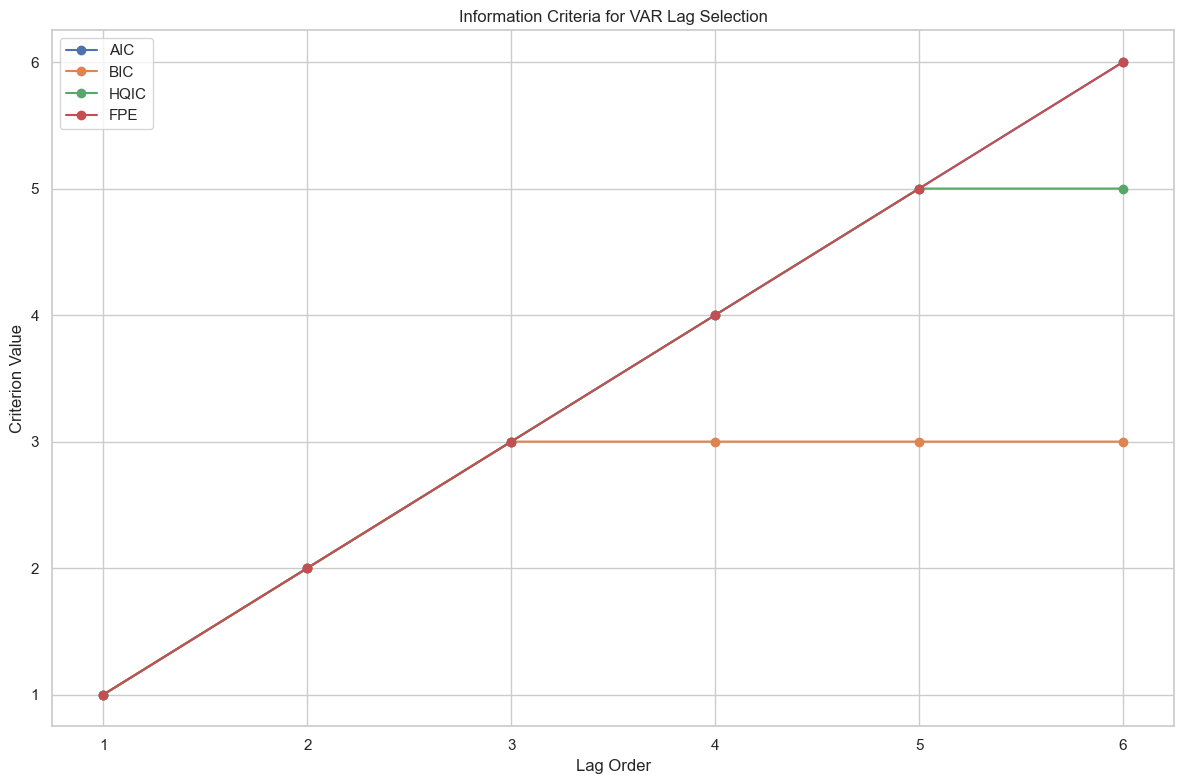

In [143]:
lag_order_results = select_var_order(data_train_Poland, max_lags=6)
print("Information criteria for different lag orders:")
print(lag_order_results)

# Plot the information criteria
plt.figure(figsize=(12, 8))
for column in lag_order_results.columns:
    plt.plot(lag_order_results.index, lag_order_results[column], marker='o', label=column.upper())
plt.xlabel('Lag Order')
plt.ylabel('Criterion Value')
plt.title('Information Criteria for VAR Lag Selection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Based on the information criteria we will analyze the VAR(3) and VAR(6).

In [144]:
var6_model_Poland = VAR(data_train_Poland, freq='W')
var6_results_Poland = var6_model_Poland.fit(6)

print(var6_results_Poland.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Jul, 2025
Time:                     10:19:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.37078
Nobs:                     255.000    HQIC:                   9.15494
Log likelihood:          -1846.40    FPE:                    8183.56
AIC:                      9.00971    Det(Omega_mle):         7408.89
--------------------------------------------------------------------
Results for equation d_mortgage_Poland
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.471222         0.670543            0.703           0.482
L1.d_mortgage_Poland        -0.559827         0.063715           -8.786           0.000
L1.d_rates_Poland   

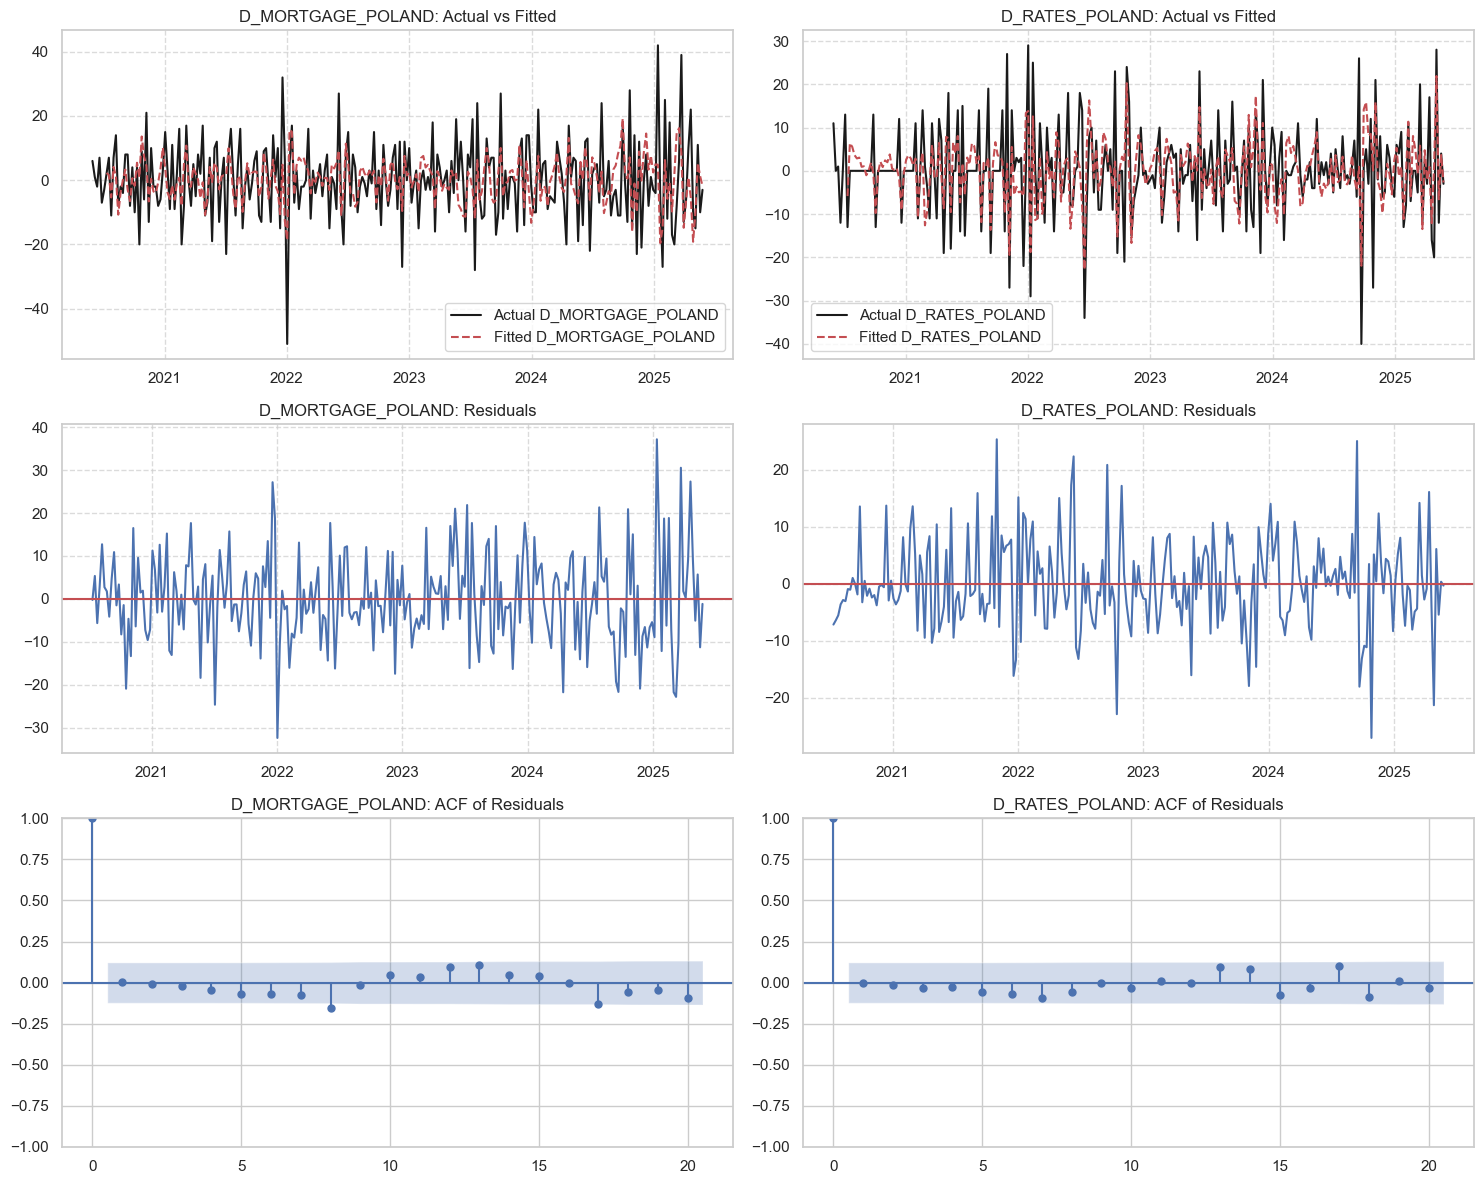

In [145]:
# Plot fitted values vs actual values, residuals, and ACF/PACF
fig = plt.figure(figsize=(15, 12))

# Fitted values vs actual values for each variable
for i, name in enumerate(data_train_Poland.columns):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(data_train_Poland.index, data_train_Poland[name], 'k-', label=f'Actual {name.upper()}')
    ax.plot(var6_results_Poland.fittedvalues[name].index, var6_results_Poland.fittedvalues[name], 'r--',
            label=f'Fitted {name.upper()}')
    ax.set_title(f'{name.upper()}: Actual vs Fitted')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Residuals for each variable
for i, name in enumerate(data_train_Poland.columns):
    ax = fig.add_subplot(3, 2, i+3)
    residuals = var6_results_Poland.resid[name]
    ax.plot(residuals.index, residuals, 'b-')
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_title(f'{name.upper()}: Residuals')
    ax.grid(True, linestyle='--', alpha=0.7)

# ACF and PACF for residuals
for i, name in enumerate(data_train_Poland.columns):
    ax = fig.add_subplot(3, 2, i+5)
    residuals = var6_results_Poland.resid[name].values
    plot_acf(residuals, ax=ax, lags=20, alpha=0.05, title=f'{name.upper()}: ACF of Residuals')

plt.tight_layout()
plt.show()

In [146]:
# Perform Ljung-Box test for autocorrelation of residuals (equivalent to Portmanteau test)
residuals = var6_results_Poland.resid

print("Ljung-Box Test for Residual Autocorrelation:")
for name in residuals.columns:
    lb_test = acorr_ljungbox(residuals[name], lags=[12, 24])
    print(f"\n{name.upper()} series:")
    print(f"Lag 12: p-value = {lb_test.iloc[0, 1]:.4f}")
    print(f"Lag 24: p-value = {lb_test.iloc[1, 1]:.4f}")

Ljung-Box Test for Residual Autocorrelation:

D_MORTGAGE_POLAND series:
Lag 12: p-value = 0.2839
Lag 24: p-value = 0.2423

D_RATES_POLAND series:
Lag 12: p-value = 0.9071
Lag 24: p-value = 0.2910


The VAR(6) model for Poland series is performing well. Let's analyze the VAR(3) model, that was winning in the BIC information criteria.

In [147]:
var3_model_Poland = VAR(data_train_Poland, freq='W')
var3_results_Poland = var3_model_Poland.fit(3)

print(var3_results_Poland.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Jul, 2025
Time:                     10:21:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.26823
Nobs:                     258.000    HQIC:                   9.15296
Log likelihood:          -1888.90    FPE:                    8738.25
AIC:                      9.07544    Det(Omega_mle):         8282.70
--------------------------------------------------------------------
Results for equation d_mortgage_Poland
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.324504         0.672463            0.483           0.629
L1.d_mortgage_Poland        -0.508541         0.061944           -8.210           0.000
L1.d_rates_Poland   

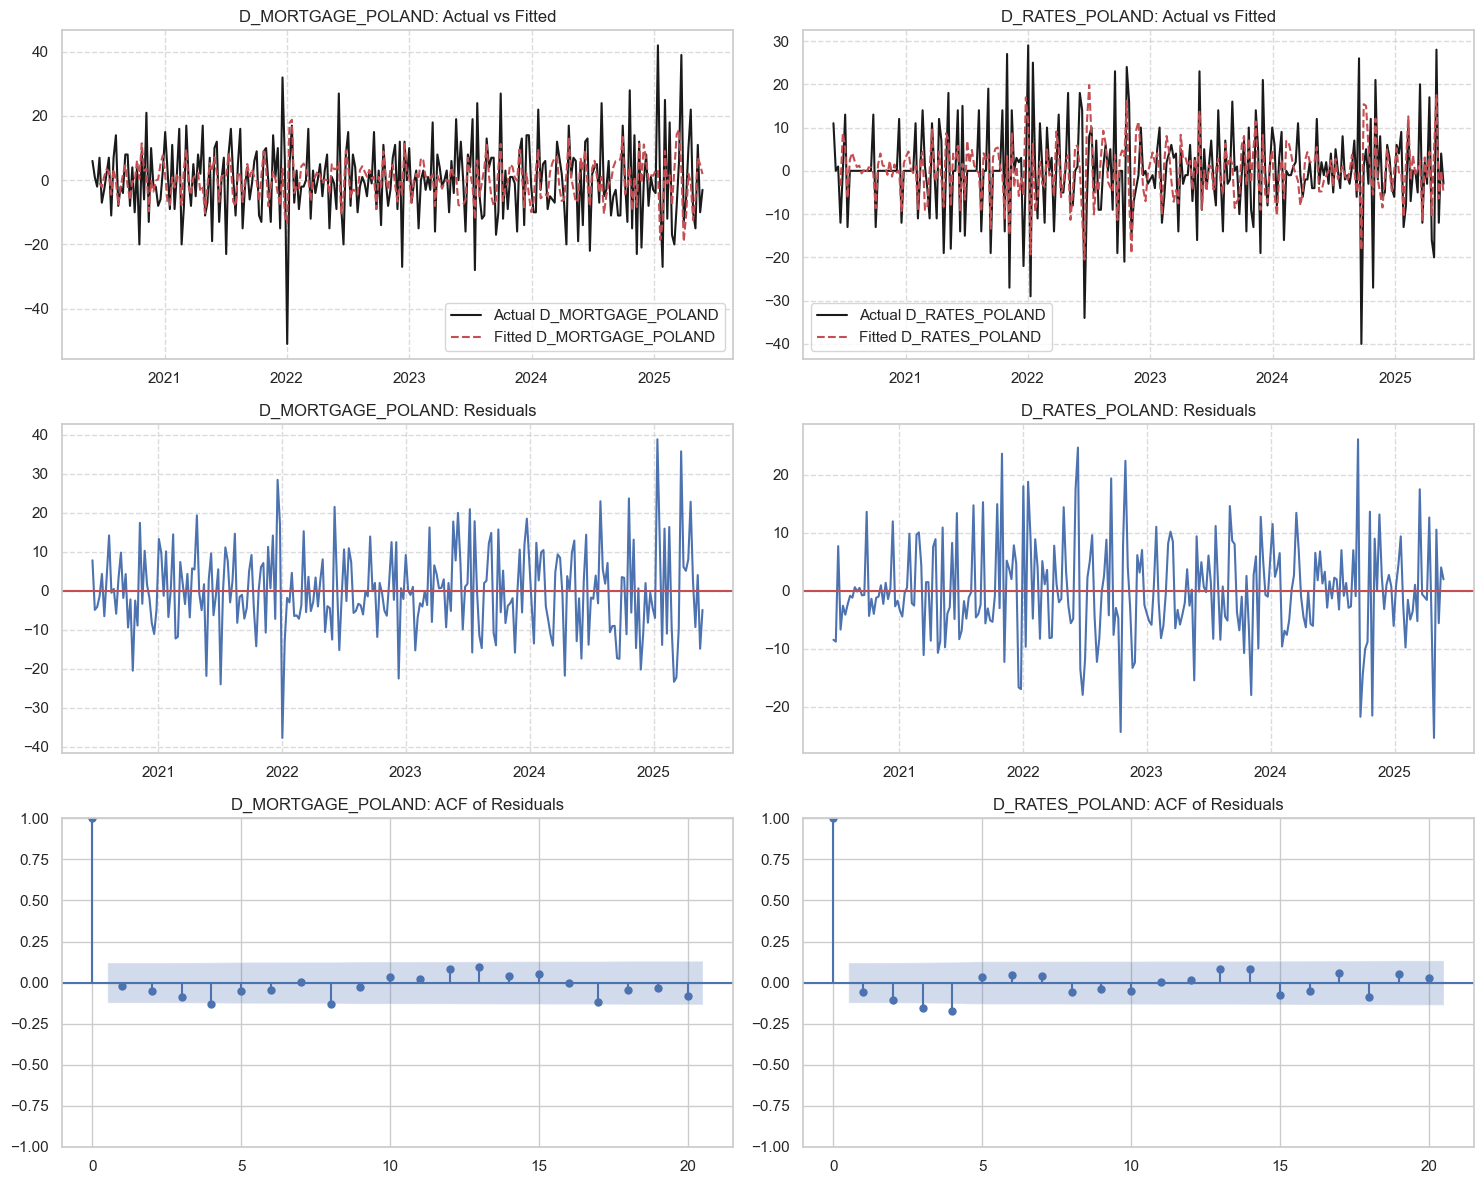

In [148]:
# Plot fitted values vs actual values, residuals, and ACF/PACF
fig = plt.figure(figsize=(15, 12))

# Fitted values vs actual values for each variable
for i, name in enumerate(data_train_Poland.columns):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(data_train_Poland.index, data_train_Poland[name], 'k-', label=f'Actual {name.upper()}')
    ax.plot(var3_results_Poland.fittedvalues[name].index, var3_results_Poland.fittedvalues[name], 'r--',
            label=f'Fitted {name.upper()}')
    ax.set_title(f'{name.upper()}: Actual vs Fitted')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Residuals for each variable
for i, name in enumerate(data_train_Poland.columns):
    ax = fig.add_subplot(3, 2, i+3)
    residuals = var3_results_Poland.resid[name]
    ax.plot(residuals.index, residuals, 'b-')
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_title(f'{name.upper()}: Residuals')
    ax.grid(True, linestyle='--', alpha=0.7)

# ACF and PACF for residuals
for i, name in enumerate(data_train_Poland.columns):
    ax = fig.add_subplot(3, 2, i+5)
    residuals = var3_results_Poland.resid[name].values
    plot_acf(residuals, ax=ax, lags=20, alpha=0.05, title=f'{name.upper()}: ACF of Residuals')

plt.tight_layout()
plt.show()

In [150]:
# Perform Ljung-Box test for autocorrelation of residuals (equivalent to Portmanteau test)
residuals = var3_results_Poland.resid

print("Ljung-Box Test for Residual Autocorrelation:")
for name in residuals.columns:
    lb_test = acorr_ljungbox(residuals[name], lags=[12, 24])
    print(f"\n{name.upper()} series:")
    print(f"Lag 12: p-value = {lb_test.iloc[0, 1]:.4f}")
    print(f"Lag 24: p-value = {lb_test.iloc[1, 1]:.4f}")

Ljung-Box Test for Residual Autocorrelation:

D_MORTGAGE_POLAND series:
Lag 12: p-value = 0.1959
Lag 24: p-value = 0.2771

D_RATES_POLAND series:
Lag 12: p-value = 0.0545
Lag 24: p-value = 0.0047


We can see that the VAR(6) performs well, has no problem with autocorrelation, while VAR(3) shows signs of residua autocorrelation for ***rates*** series. Based on this diagnosis, we will proceed with VAR\(6) model for Poland series. Let's create a 6-week forecast.

In [151]:
forecast_horizon = 6
print("Original data shape:", data_train_Poland.shape)
print("Training data shape:", data_train_short_Poland.shape)
print("Last date in training data:", data_train_short_Poland.index[-1].strftime('%d-%m-%Y'))

# Fit VAR(6) model on the shorter sample
var6_short_model_Poland = VAR(data_train_short_Poland, freq='W')
var6_short_results_Poland = var6_short_model_Poland.fit(6)

# Generate forecasts
forecast = var6_short_results_Poland.forecast(data_train_short_Poland.values, steps=forecast_horizon)
forecast_index = pd.date_range(start=data_train_short_Poland.index[-1] + pd.DateOffset(weeks=1), periods=forecast_horizon, freq='W')

# Create a DataFrame for the forecasts
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data_train_Poland.columns)

print("\nForecast results:")
print(forecast_df)

Original data shape: (261, 2)
Training data shape: (255, 2)
Last date in training data: 13-04-2025

Forecast results:
            d_mortgage_Poland  d_rates_Poland
2025-04-20      -8.1670539640  -11.0086917520
2025-04-27      -3.0839703151   -3.6763151771
2025-05-04       1.6617612377    4.8035824440
2025-05-11       4.8673143238   -1.2425075400
2025-05-18       0.5309297581    0.0200978191
2025-05-25      -3.5792604881    1.4992030058


In [152]:
forecast_mean, forecast_lower, forecast_upper = compute_forecast_ci(
    var6_short_results_Poland, data_train_short_Poland.values, forecast_horizon, alpha=0.05
)

# Create DataFrames for the confidence intervals
forecast_lower_df = pd.DataFrame(forecast_lower, index=forecast_index,
                               columns=[f"{col}_lower" for col in data_train_Poland.columns])
forecast_upper_df = pd.DataFrame(forecast_upper, index=forecast_index,
                               columns=[f"{col}_upper" for col in data_train_Poland.columns])

# Combine the forecasts and actual values
forecast_evaluation = pd.concat([
    data_train_Poland.loc[forecast_index],
    forecast_df,
    forecast_lower_df,
    forecast_upper_df
], axis=1)

forecast_evaluation.columns = [
    'mortgage_actual', 'rates_actual',
    'mortgage_forecast', 'rates_forecast',
    'mortgage_lower', 'rates_lower',
    'mortgage_upper', 'rates_upper'
]

print("Forecast evaluation dataset:")
print(forecast_evaluation)


Forecast evaluation dataset:
            mortgage_actual   rates_actual  mortgage_forecast  rates_forecast  \
2025-04-20    22.0000000000 -16.0000000000      -8.1670539640  -11.0086917520   
2025-04-27   -10.0000000000 -20.0000000000      -3.0839703151   -3.6763151771   
2025-05-04   -15.0000000000  28.0000000000       1.6617612377    4.8035824440   
2025-05-11    11.0000000000 -12.0000000000       4.8673143238   -1.2425075400   
2025-05-18   -10.0000000000   4.0000000000       0.5309297581    0.0200978191   
2025-05-25    -3.0000000000  -3.0000000000      -3.5792604881    1.4992030058   

            mortgage_lower    rates_lower  mortgage_upper   rates_upper  
2025-04-20  -28.9099707764 -26.7167118367   12.5758628485  4.6993283327  
2025-04-27  -23.8268871275 -19.3843352617   17.6589464974 12.0317049076  
2025-05-04  -19.0811555747 -10.9044376407   22.4046780501 20.5116025287  
2025-05-11  -15.8756024886 -16.9505276247   25.6102311363 14.4655125447  
2025-05-18  -20.2119870544 -15.68

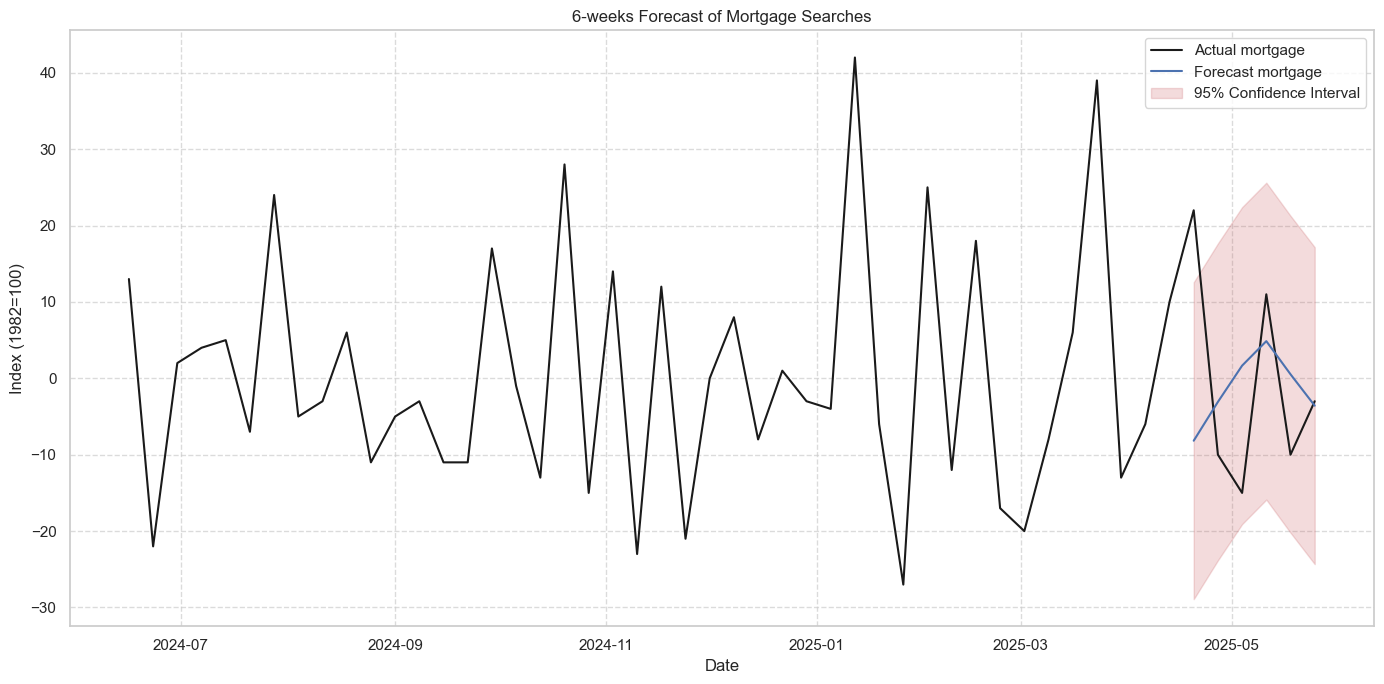

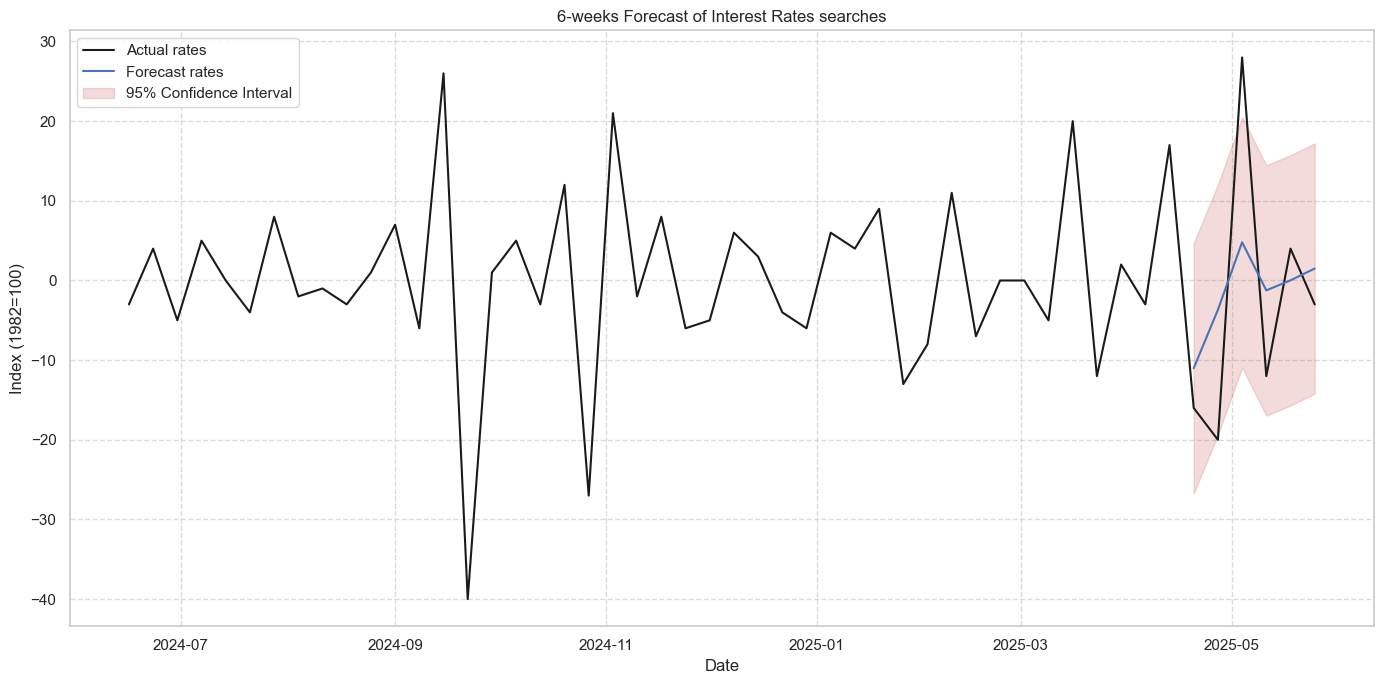

In [154]:
# Plot the mortgage forecasts vs actual values
plt.figure(figsize=(14, 7))

# Get the last 3 years of data for plotting context
plot_start_date = data_train_Poland.index[-14-36]  # 3 years before forecast start
plot_data = data_train_Poland.loc[plot_start_date:]

# Plot actual mortgage values (full history)
plt.plot(plot_data.index, plot_data['d_mortgage_Poland'], 'k-', label='Actual mortgage')

# Plot forecasted values
plt.plot(forecast_evaluation.index, forecast_evaluation['mortgage_forecast'], 'b-', label='Forecast mortgage')

# Plot confidence intervals
plt.fill_between(forecast_evaluation.index,
                forecast_evaluation['mortgage_lower'],
                forecast_evaluation['mortgage_upper'],
                color='r', alpha=0.2, label='95% Confidence Interval')

plt.title('6-weeks Forecast of Mortgage Searches')
plt.xlabel('Date')
plt.ylabel('Index (1982=100)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot the rates forecasts vs actual values
plt.figure(figsize=(14, 7))

# Plot actual rates values (full history)
plt.plot(plot_data.index, plot_data['d_rates_Poland'], 'k-', label='Actual rates')

# Plot forecasted values
plt.plot(forecast_evaluation.index, forecast_evaluation['rates_forecast'], 'b-', label='Forecast rates')

# Plot confidence intervals
plt.fill_between(forecast_evaluation.index,
                forecast_evaluation['rates_lower'],
                forecast_evaluation['rates_upper'],
                color='r', alpha=0.2, label='95% Confidence Interval')

plt.title('6-weeks Forecast of Interest Rates searches')
plt.xlabel('Date')
plt.ylabel('Index (1982=100)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [155]:
forecast_evaluation = forecast_evaluation[(forecast_evaluation['rates_actual']!=0)]
# Calculate metrics for mortgage
mortgage_mae = mean_absolute_error(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])
mortgage_mse = mean_squared_error(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])
mortgage_rmse = np.sqrt(mortgage_mse)
mortgage_mape = mape(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])
mortgage_amape = amape(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])

# Calculate metrics for rates
rates_mae = mean_absolute_error(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])
rates_mse = mean_squared_error(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])
rates_rmse = np.sqrt(rates_mse)
rates_mape = mape(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])
rates_amape = amape(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])

# Create a DataFrame to display the results
metrics_df_Poland = pd.DataFrame({
    'mortgage': [mortgage_mae, mortgage_mse, mortgage_rmse, mortgage_mape, mortgage_amape],
    'rates': [rates_mae, rates_mse, rates_rmse, rates_mape, rates_amape]
}, index=['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'AMAPE (%)'])

print("Forecast Accuracy Metrics:")
print(metrics_df_Poland)

Forecast Accuracy Metrics:
                mortgage          rates
MAE        11.8312868015  10.6246680456
MSE       230.7237928159 163.5426207901
RMSE       15.1895948865  12.7883783487
MAPE (%)   82.9552243579  89.1292012711
AMAPE (%) 184.8417891762 212.7203065853


We save our results and later we will compare the VAR models with ARIMA models.

## <a id="ARIMA-models"></a>ARIMA models - Box-Jenkins procedure

### <a id="ARIMA-model-identification"></a>ARIMA model identification

In [116]:
adf_test(data['mortgage_world'], max_aug=30)

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                         0       -5.0798755533            -3.4340000000   
1                         1       -4.0621764783            -3.4340000000   
2                         2       -3.9262688208            -3.4340000000   
3                         3       -3.2052000726            -3.4340000000   
4                         4       -3.4185665204            -3.4340000000   
5                         5       -4.1412270465            -3.4340000000   
6                         6       -4.2444444814            -3.4340000000   
7                         7       -4.4151304844            -3.4340000000   
8                         8       -4.0974596273            -3.4340000000   
9                         9       -4.3593161273            -3.4340000000   
10                       10       -4.1850908784            -3.4340000000   
11                       11       -4.2400722510            -3.4340000000   
12                       12       -3.9002011361            -3.4340000000   
13                       13       -3.9216325188            -3.4340000000   
14                       14       -3.7727967894            -3.4340000000   
15                       15       -3.6393696538            -3.4340000000   
16                       16       -3.7069993753            -3.4340000000   
17                       17       -3.6963141542            -3.4340000000   
18                       18       -3.9375621167            -3.4340000000   
19                       19       -3.5832077088            -3.4340000000   
20                       20       -3.1527352410            -3.4340000000   
21                       21       -2.9412612145            -3.4340000000   
22                       22       -2.9341283720            -3.4340000000   
23                       23       -2.6646995641            -3.4340000000   
24                       24       -2.7996438497            -3.4340000000   
25                       25       -2.7204235925            -3.4340000000   
26                       26       -2.4545402493            -3.4340000000   
27                       27       -2.6304983290            -3.4340000000   
28                       28       -2.4871878249            -3.4340000000   
29                       29       -2.2656834672            -3.4340000000   

    ADF critival value (5%)  ADF critival value (10%)  \
0             -2.8630000000             -2.5680000000   
1             -2.8630000000             -2.5680000000   
2             -2.8630000000             -2.5680000000   
3             -2.8630000000             -2.5680000000   
4             -2.8630000000             -2.5680000000   
5             -2.8630000000             -2.5680000000   
6             -2.8630000000             -2.5680000000   
7             -2.8630000000             -2.5680000000   
8             -2.8630000000             -2.5680000000   
9             -2.8630000000             -2.5680000000   
10            -2.8630000000             -2.5680000000   
11            -2.8630000000             -2.5680000000   
12            -2.8630000000             -2.5680000000   
13            -2.8630000000             -2.5680000000   
14            -2.8630000000             -2.5680000000   
15            -2.8630000000             -2.5680000000   
16            -2.8630000000             -2.5680000000   
17            -2.8630000000             -2.5680000000   
18            -2.8630000000             -2.5680000000   
19            -2.8630000000             -2.5680000000   
20            -2.8630000000             -2.5680000000   
21            -2.8630000000             -2.5680000000   
22            -2.8630000000             -2.5680000000   
23            -2.8630000000             -2.5680000000   
24            -2.8630000000             -2.5680000000   
25            -2.8630000000             -2.5680000000   
26            -2.8630000000             -2.5680000000   
27            -2.8630000000             -2.56800000

In [117]:
adf_test(data['d_mortgage_world'], max_aug=30)

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                         0      -20.5276751222            -3.4340000000   
1                         1      -13.7459853479            -3.4340000000   
2                         2      -13.7466705534            -3.4340000000   
3                         3       -9.6278187228            -3.4340000000   
4                         4       -7.5728512350            -3.4340000000   
5                         5       -7.8974732694            -3.4340000000   
6                         6       -6.6897197746            -3.4340000000   
7                         7       -6.3342574154            -3.4340000000   
8                         8       -5.4380967143            -3.4340000000   
9                         9       -5.7883936210            -3.4340000000   
10                       10       -5.2155568080            -3.4340000000   
11                       11       -6.0150989363            -3.4340000000   
12                       12       -4.8843119232            -3.4340000000   
13                       13       -5.0902372433            -3.4340000000   
14                       14       -4.6277453807            -3.4340000000   
15                       15       -4.8101964523            -3.4340000000   
16                       16       -4.4226777221            -3.4340000000   
17                       17       -3.9396423877            -3.4340000000   
18                       18       -4.6180612174            -3.4340000000   
19                       19       -5.6019950634            -3.4340000000   
20                       20       -6.2360161002            -3.4340000000   
21                       21       -5.8232995280            -3.4340000000   
22                       22       -5.8553656354            -3.4340000000   
23                       23       -5.8620209376            -3.4340000000   
24                       24       -5.5868192271            -3.4340000000   
25                       25       -5.0666723796            -3.4340000000   
26                       26       -4.6842573716            -3.4340000000   
27                       27       -4.4547541335            -3.4340000000   
28                       28       -4.4846432003            -3.4340000000   
29                       29       -4.5927277765            -3.4340000000   

    ADF critival value (5%)  ADF critival value (10%)  \
0             -2.8630000000             -2.5680000000   
1             -2.8630000000             -2.5680000000   
2             -2.8630000000             -2.5680000000   
3             -2.8630000000             -2.5680000000   
4             -2.8630000000             -2.5680000000   
5             -2.8630000000             -2.5680000000   
6             -2.8630000000             -2.5680000000   
7             -2.8630000000             -2.5680000000   
8             -2.8630000000             -2.5680000000   
9             -2.8630000000             -2.5680000000   
10            -2.8630000000             -2.5680000000   
11            -2.8630000000             -2.5680000000   
12            -2.8630000000             -2.5680000000   
13            -2.8630000000             -2.5680000000   
14            -2.8630000000             -2.5680000000   
15            -2.8630000000             -2.5680000000   
16            -2.8630000000             -2.5680000000   
17            -2.8630000000             -2.5680000000   
18            -2.8630000000             -2.5680000000   
19            -2.8630000000             -2.5680000000   
20            -2.8630000000             -2.5680000000   
21            -2.8630000000             -2.5680000000   
22            -2.8630000000             -2.5680000000   
23            -2.8630000000             -2.5680000000   
24            -2.8630000000             -2.5680000000   
25            -2.8630000000             -2.5680000000   
26            -2.8630000000             -2.5680000000   
27            -2.8630000000             -2.56800000

In [118]:
adf_test(data['rates_world'], max_aug=20)

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                         0       -6.3648905215            -3.4340000000   
1                         1       -4.5193851780            -3.4340000000   
2                         2       -3.6677302587            -3.4340000000   
3                         3       -2.8718245249            -3.4340000000   
4                         4       -2.3178563107            -3.4340000000   
5                         5       -1.7027941042            -3.4340000000   
6                         6       -1.6233546529            -3.4340000000   
7                         7       -1.7485483338            -3.4340000000   
8                         8       -1.6610009609            -3.4340000000   
9                         9       -1.7977767124            -3.4340000000   
10                       10       -1.8250481157            -3.4340000000   
11                       11       -1.6952359605            -3.4340000000   
12                       12       -1.3764647926            -3.4340000000   
13                       13       -1.2885742064            -3.4340000000   
14                       14       -1.3124147686            -3.4340000000   
15                       15       -1.3497571812            -3.4340000000   
16                       16       -1.2752262286            -3.4340000000   
17                       17       -1.3479116208            -3.4340000000   
18                       18       -1.3358164909            -3.4340000000   
19                       19       -1.0858817705            -3.4340000000   

    ADF critival value (5%)  ADF critival value (10%)  \
0             -2.8630000000             -2.5680000000   
1             -2.8630000000             -2.5680000000   
2             -2.8630000000             -2.5680000000   
3             -2.8630000000             -2.5680000000   
4             -2.8630000000             -2.5680000000   
5             -2.8630000000             -2.5680000000   
6             -2.8630000000             -2.5680000000   
7             -2.8630000000             -2.5680000000   
8             -2.8630000000             -2.5680000000   
9             -2.8630000000             -2.5680000000   
10            -2.8630000000             -2.5680000000   
11            -2.8630000000             -2.5680000000   
12            -2.8630000000             -2.5680000000   
13            -2.8630000000             -2.5680000000   
14            -2.8630000000             -2.5680000000   
15            -2.8630000000             -2.5680000000   
16            -2.8630000000             -2.5680000000   
17            -2.8630000000             -2.5680000000   
18            -2.8630000000             -2.5680000000   
19            -2.8630000000             -2.5680000000   

    BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                 17.5037000000               0.0000000000   
1                  7.0792000000               0.0078000000   
2                 12.7423000000               0.0004000000   
3                 10.6749000000               0.0011000000   
4                 22.7119000000               0.0000000000   
5                  0.3846000000               0.5352000000   
6                  2.0379000000               0.1534000000   
7                  0.5160000000               0.4726000000   
8                  2.4865000000               0.1148000000   
9                  0.2127000000               0.6447000000   
10                 1.2122000000               0.2709000000   
11                13.2173000000               0.0003000000   
12                 1.5811000000               0.2086000000   
13                 0.0226000000               0.8806000000   
14                 0.2925000000               0.5886000000   
15                 0.4411000000               0.5066000000   
16                 1.2128000000               0.2708000000   
17                 0.0468000000               0.8288000000   
18                 4.9160000000

In [119]:
adf_test(data['d_rates_world'], max_aug=20)

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                         0      -23.3265777949            -3.4340000000   
1                         1      -16.5853368096            -3.4340000000   
2                         2      -14.9230703897            -3.4340000000   
3                         3      -13.6550088171            -3.4340000000   
4                         4      -14.2372929929            -3.4340000000   
5                         5      -11.0156675970            -3.4340000000   
6                         6       -8.1613803280            -3.4340000000   
7                         7       -7.5545162496            -3.4340000000   
8                         8       -6.1540201961            -3.4340000000   
9                         9       -5.5780268323            -3.4340000000   
10                       10       -5.6575995296            -3.4340000000   
11                       11       -6.7569727751            -3.4340000000   
12                       12       -6.6904381467            -3.4340000000   
13                       13       -6.0159139939            -3.4340000000   
14                       14       -5.4310778550            -3.4340000000   
15                       15       -5.4569261265            -3.4340000000   
16                       16       -4.7249042154            -3.4340000000   
17                       17       -4.4183915763            -3.4340000000   
18                       18       -5.4885044276            -3.4340000000   
19                       19       -4.4516043984            -3.4340000000   

    ADF critival value (5%)  ADF critival value (10%)  \
0             -2.8630000000             -2.5680000000   
1             -2.8630000000             -2.5680000000   
2             -2.8630000000             -2.5680000000   
3             -2.8630000000             -2.5680000000   
4             -2.8630000000             -2.5680000000   
5             -2.8630000000             -2.5680000000   
6             -2.8630000000             -2.5680000000   
7             -2.8630000000             -2.5680000000   
8             -2.8630000000             -2.5680000000   
9             -2.8630000000             -2.5680000000   
10            -2.8630000000             -2.5680000000   
11            -2.8630000000             -2.5680000000   
12            -2.8630000000             -2.5680000000   
13            -2.8630000000             -2.5680000000   
14            -2.8630000000             -2.5680000000   
15            -2.8630000000             -2.5680000000   
16            -2.8630000000             -2.5680000000   
17            -2.8630000000             -2.5680000000   
18            -2.8630000000             -2.5680000000   
19            -2.8630000000             -2.5680000000   

    BG test (1 lag) (statistic)  BG test (1 lag) (p-value)  \
0                 13.3437000000               0.0003000000   
1                 17.4084000000               0.0000000000   
2                 13.3623000000               0.0003000000   
3                 25.0435000000               0.0000000000   
4                  0.6192000000               0.4313000000   
5                  1.5150000000               0.2184000000   
6                  0.7897000000               0.3742000000   
7                  1.9115000000               0.1668000000   
8                  0.0740000000               0.7855000000   
9                  1.3525000000               0.2448000000   
10                14.0662000000               0.0002000000   
11                 1.8196000000               0.1774000000   
12                 0.0082000000               0.9278000000   
13                 0.1673000000               0.6825000000   
14                 0.5729000000               0.4491000000   
15                 1.0468000000               0.3062000000   
16                 0.0178000000               0.8939000000   
17                 1.5580000000               0.2120000000   
18                 4.4172000000

As per above, the difference in augmentations, which is needed to conclude that the differences of the series are stationary, equals to 1. Therefore, the series is integrated of order 1. So d = 1 for ARIMA (p,1,q).

Now let's determine r & q firstly for mortgages differences. Its ACF Plot above shows a significant spike at lag 1 and then appears to cut off immediately => might be MA(1), so q=1. PACF Plot shows a significant spike at lag 1 and then also appears to cut off => AR(1) & p=1. ARIMA (1,1,1)
As for interest rates differences, its ACF Plot shows a significant spike at lag 1. The spike at lag 2 is borderline => let's try MA(1). PACF Plot shows a significant spike at lag 1 and then also cuts off => AR(1). So final ARIMA (1,1,1)

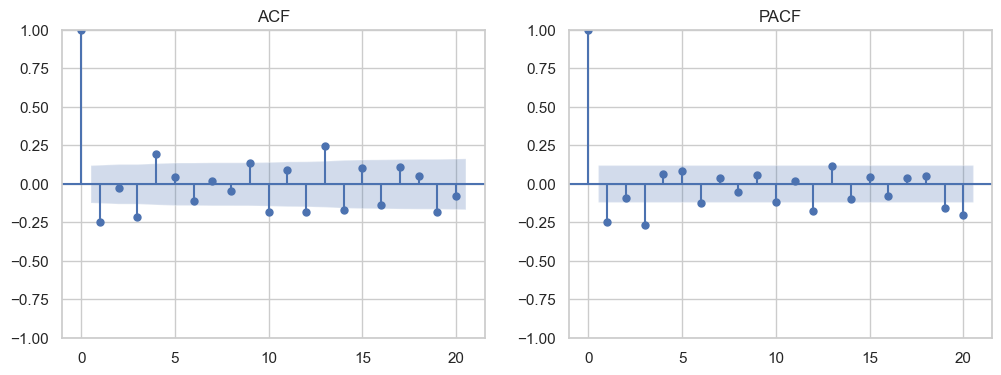

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(data['d_mortgage_world'])[1:], lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")

# Partial autocorrelation plot
plot_pacf(np.array(data['d_mortgage_world'])[1:], lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")

plt.show()

In [121]:

# Define and Fit the ARIMA model
arimaM111 = ARIMA(data_train['mortgage_world'].values, order=(1,1,1))
results_M111 = arimaM111.fit()

# Print the model summary
print("\n ARIMA Model Summary")
print(results_M111.summary())


 ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  262
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -811.169
Date:                Fri, 04 Jul 2025   AIC                           1628.339
Time:                        22:40:11   BIC                           1639.032
Sample:                             0   HQIC                          1632.637
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3481      0.132      2.633      0.008       0.089       0.607
ma.L1         -0.6770      0.111     -6.113      0.000      -0.894      -0.460
sigma2        29.2884      1.9

Now let's test its residuals for autocorrelation.

In [122]:
ljung_test = acorr_ljungbox(results_M111.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

         lb_stat    lb_pvalue
5   6.3840669932 0.2706201045
10 10.7082268150 0.3806970247
15 17.2373371188 0.3048755149
20 26.6179546343 0.1463587297
25 32.7651116083 0.1370456156


The Ljung-Box test results suggest that the residuals of the ARIMA models are mostly uncorrelated, implying that the models have successfully captured the main structure of the data (since all lb_pvalues (0.27, 0.38, 0.30, 0.14, 0.13) are well above the common significance level of 0.05, we fail to reject the null hypothesis of no autocorrelation in the residuals)

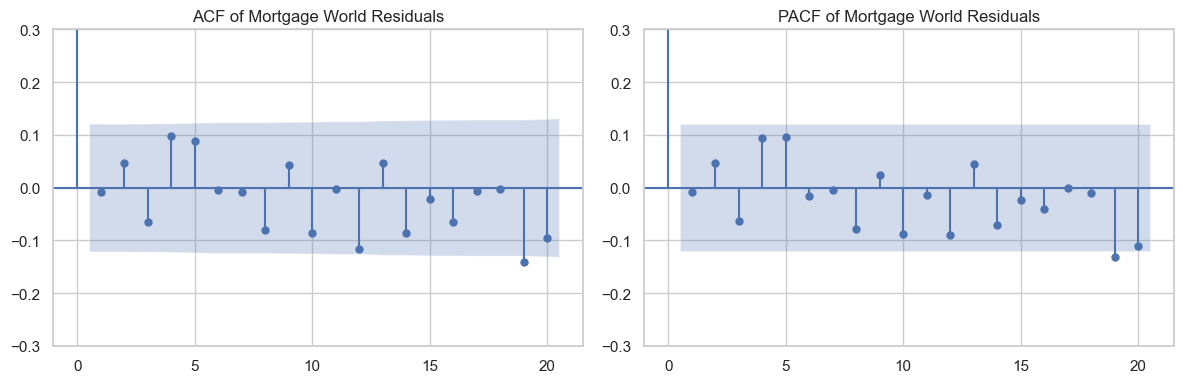

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot for MORTGAGE_WORLD residuals
# Use 'results.resid' to access the residuals of your fitted mortgage_world model
plot_acf(results_M111.resid, lags=20, ax=axes[0])
axes[0].set_title("ACF of Mortgage World Residuals")
axes[0].set_ylim([-0.3, 0.3]) # Limiting y-axis helps to see small deviations

# Partial autocorrelation plot for MORTGAGE_WORLD residuals
# Use 'results.resid' here too
plot_pacf(results_M111.resid, lags=20, ax=axes[1])
axes[1].set_title("PACF of Mortgage World Residuals")
axes[1].set_ylim([-0.3, 0.3]) # Limiting y-axis helps to see small deviations

plt.tight_layout() # Adjusts plot params for a tight layout
plt.show()

Almost all spikes are within the confidence bands without any pattern for a couple of out-of-bar spikes -> most probably, the residuals are white noise. Now the Interest Rates model.

Text(0.5, 1.0, 'PACF')

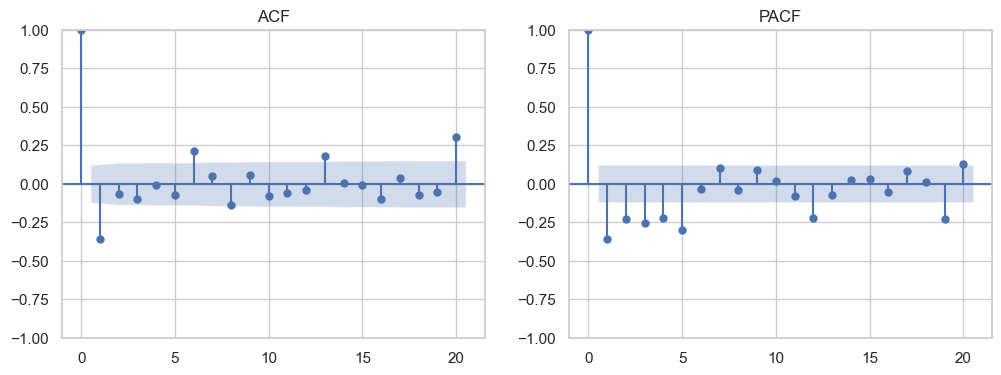

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(data['d_rates_world'])[1:], lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")

# Partial autocorrelation plot
plot_pacf(np.array(data['d_rates_world'])[1:], lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")

In [125]:
# Define and Fit the ARIMA model
arimaR111 = ARIMA(data_train['rates_world'].values, order=(1,1,1))
results_R111 = arimaR111.fit()

# Print the model summary
print("\n ARIMA Model Summary")
print(results_R111.summary())


 ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  262
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -591.097
Date:                Fri, 04 Jul 2025   AIC                           1188.194
Time:                        22:40:12   BIC                           1198.888
Sample:                             0   HQIC                          1192.492
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2092      0.072      2.903      0.004       0.068       0.350
ma.L1         -0.8456      0.044    -19.222      0.000      -0.932      -0.759
sigma2         5.4092      0.2

In [126]:
ljung_test_rates = acorr_ljungbox(results_R111.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test_rates)

         lb_stat    lb_pvalue
5   2.8356412749 0.7253071779
10 24.3483781363 0.0067274804
15 35.7595332009 0.0019145718
20 61.1081239605 0.0000047918
25 63.7518232381 0.0000311869


There is significant autocorrelation in the residuals at longer lags -> model is underspecified. Let's try ARIMA(0,1,1), as ACF in the beginning cuts off at 1 and PACF tails off.


In [127]:
arimaR011 = ARIMA(data_train['rates_world'].values, order=(0,1,1))
results_R011 = arimaR011.fit()

# Print the model summary
print("\n ARIMA Model Summary")
print(results_R011.summary())


 ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  262
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -594.911
Date:                Fri, 04 Jul 2025   AIC                           1193.822
Time:                        22:40:12   BIC                           1200.951
Sample:                             0   HQIC                          1196.688
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7703      0.041    -18.802      0.000      -0.851      -0.690
sigma2         5.5699      0.193     28.788      0.000       5.191       5.949
Ljung-Box (L1) (Q):           

In [128]:
ljung_test_rates = acorr_ljungbox(results_R011.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test_rates)

         lb_stat    lb_pvalue
5  13.5755589460 0.0185426213
10 41.1720741381 0.0000105195
15 56.6285575466 0.0000009487
20 85.5966390582 0.0000000004
25 88.3277433325 0.0000000054


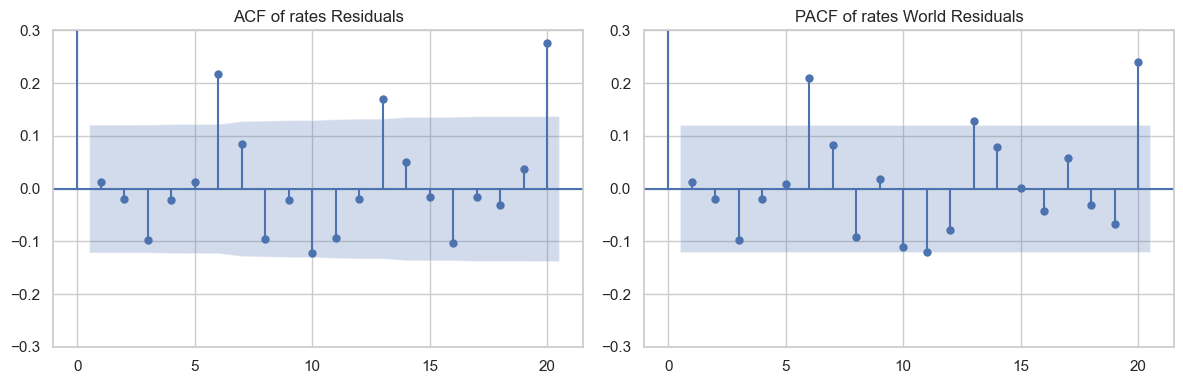

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot for MORTGAGE_WORLD residuals
# Use 'results.resid' to access the residuals of your fitted mortgage_world model
plot_acf(results_R111.resid, lags=20, ax=axes[0])
axes[0].set_title("ACF of rates Residuals")
axes[0].set_ylim([-0.3, 0.3]) # Limiting y-axis helps to see small deviations

# Partial autocorrelation plot for MORTGAGE_WORLD residuals
# Use 'results.resid' here too
plot_pacf(results_R111.resid, lags=20, ax=axes[1])
axes[1].set_title("PACF of rates World Residuals")
axes[1].set_ylim([-0.3, 0.3]) # Limiting y-axis helps to see small deviations

plt.tight_layout() # Adjusts plot params for a tight layout
plt.show()

ACF: Significant spikes outside the confidence bounds at 1,3,6,13 & PACF: 3,6,13. 1 & 2 have already been tried with unsuccessful outcome, therefore, AR (13) will be the starting point.

In [130]:
arimaR1311 = ARIMA(data_train['rates_world'].values, order=(6,1,1), enforce_stationarity=False, enforce_invertibility=False)
results_R1311 = arimaR1311.fit()

# Print the model summary
print("\n--- ARIMA Model Summary")
print(results_R1311.summary())


--- ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  262
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -569.954
Date:                Fri, 04 Jul 2025   AIC                           1155.908
Time:                        22:40:12   BIC                           1184.238
Sample:                             0   HQIC                          1167.304
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3668      0.204     -6.705      0.000      -1.766      -0.967
ar.L2         -1.0204      0.138     -7.380      0.000      -1.291      -0.749
ar.L3         -0.9338      

In [131]:
ljung_test_rates = acorr_ljungbox(results_R1311.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test_rates)

         lb_stat    lb_pvalue
5   4.6768366643 0.4565773233
10  9.3370585034 0.5004420060
15 16.6484286587 0.3403119528
20 28.5444568838 0.0971243820
25 30.6221192395 0.2018378332


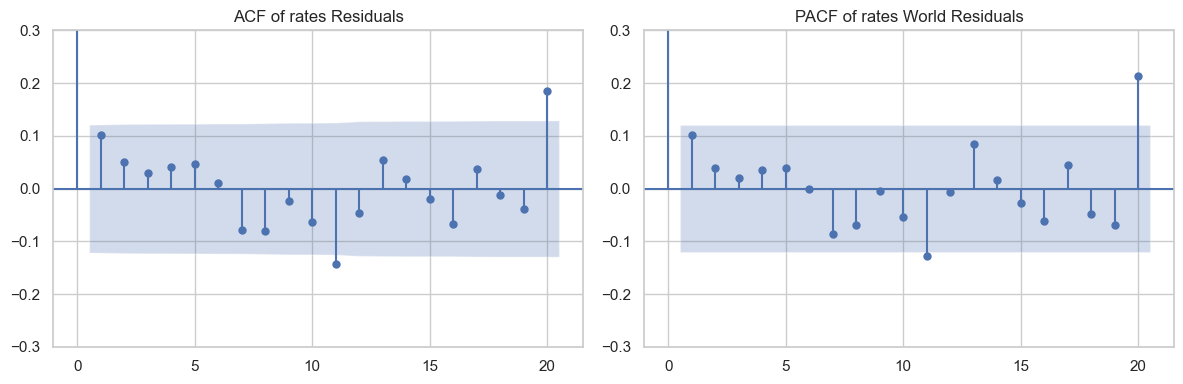

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot for MORTGAGE_WORLD residuals
# Use 'results.resid' to access the residuals of your fitted mortgage_world model
plot_acf(results_R1311.resid, lags=20, ax=axes[0])
axes[0].set_title("ACF of rates Residuals")
axes[0].set_ylim([-0.3, 0.3]) # Limiting y-axis helps to see small deviations

# Partial autocorrelation plot for MORTGAGE_WORLD residuals
# Use 'results.resid' here too
plot_pacf(results_R1311.resid, lags=20, ax=axes[1])
axes[1].set_title("PACF of rates World Residuals")
axes[1].set_ylim([-0.3, 0.3]) # Limiting y-axis helps to see small deviations

plt.tight_layout() # Adjusts plot params for a tight layout
plt.show()

This model is good for explaining the autocorrelation (white noise residuals), but its pretty complex (many insignificant model coefficients). Having tried out the model with AR (6) by ourselves, we concluded that we will proceed with the model presented above.

In [133]:
models = [results_R011, results_R111, results_R1311] # list with all the models
names = ['arimaR011', 'arimaR111', 'arimaR1311'] # models' names

# Preparing a DataFrame with models sorted by AIC, BIC
results = []
for model, name in zip(models, names):
    results.append([name, round(model.aic,2), round(model.bic,2)])
results_df = pd.DataFrame(results)
results_df.columns = ['model', 'AIC', 'BIC']

print('Models by AIC:\n',results_df.sort_values('AIC'))
print('Models by BIC:\n',results_df.sort_values('BIC'))

Models by AIC:
         model             AIC             BIC
2  arimaR1311 1155.9100000000 1184.2400000000
1   arimaR111 1188.1900000000 1198.8900000000
0   arimaR011 1193.8200000000 1200.9500000000
Models by BIC:
         model             AIC             BIC
2  arimaR1311 1155.9100000000 1184.2400000000
1   arimaR111 1188.1900000000 1198.8900000000
0   arimaR011 1193.8200000000 1200.9500000000


ARIMA(6,1,1) is the best performing model according to both AIC and BIC - lowest values.

### <a id="ARIMA-model-forecasting"></a>ARIMA model forecasting

In [134]:
arimaR1311 = ARIMA(data_train_short['rates_world'].values, order=(6,1,1), enforce_stationarity=False, enforce_invertibility=False)
results_R1311 = arimaR1311.fit()

# Print the model summary
print("\n--- ARIMA Model Summary")
print(results_R1311.summary())


--- ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  256
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -555.461
Date:                Fri, 04 Jul 2025   AIC                           1126.922
Time:                        22:40:13   BIC                           1155.062
Sample:                             0   HQIC                          1138.249
                                - 256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3362      0.248     -5.399      0.000      -1.821      -0.851
ar.L2         -1.0122      0.161     -6.279      0.000      -1.328      -0.696
ar.L3         -0.9242      

In [135]:
data_test = data_train.tail(6)

In [136]:
data_test

mortgage_world  rates_world
Date                                   
2025-04-20              64           14
2025-04-27              68           14
2025-05-04              66           16
2025-05-11              63           12
2025-05-18              61           14
2025-05-25              42           10

In [137]:

# Forecast for next ten observations (2 working weeks)
forecast_results = results_R1311.get_forecast(steps=6)

# Point forecast
forecast_values = forecast_results.predicted_mean

# Confidence (by default 95%) intervals of the point forecast
confidence_intervals = forecast_results.conf_int()

forecast_df = pd.DataFrame({
    "forecast": forecast_values,
    "lower_CI": confidence_intervals[:, 0],
    "upper_CI": confidence_intervals[:, 1],
    "rates_world": data_test['rates_world']
}, index=data_test.index)

forecast_df

forecast      lower_CI      upper_CI  rates_world
Date                                                             
2025-04-20 16.0119686454 11.6036859809 20.4202513099           14
2025-04-27 15.2479998434 10.5874553831 19.9085443036           14
2025-05-04 15.2622331906 10.5118101483 20.0126562330           16
2025-05-11 15.7724291186 10.9880328786 20.5568253586           12
2025-05-18 17.0118052866 12.1722003881 21.8514101852           14
2025-05-25 16.0011309062 11.0901657533 20.9120960591           10

In [138]:
final_df = pd.concat([data_train_short['rates_world'], forecast_df], axis=0)

final_df

rates_world      forecast      lower_CI      upper_CI
Date                                                             
2020-05-24           11           NaN           NaN           NaN
2020-05-31           12           NaN           NaN           NaN
2020-06-07           12           NaN           NaN           NaN
2020-06-14           11           NaN           NaN           NaN
2020-06-21           11           NaN           NaN           NaN
...                 ...           ...           ...           ...
2025-04-27           14 15.2479998434 10.5874553831 19.9085443036
2025-05-04           16 15.2622331906 10.5118101483 20.0126562330
2025-05-11           12 15.7724291186 10.9880328786 20.5568253586
2025-05-18           14 17.0118052866 12.1722003881 21.8514101852
2025-05-25           10 16.0011309062 11.0901657533 20.9120960591

[262 rows x 4 columns]

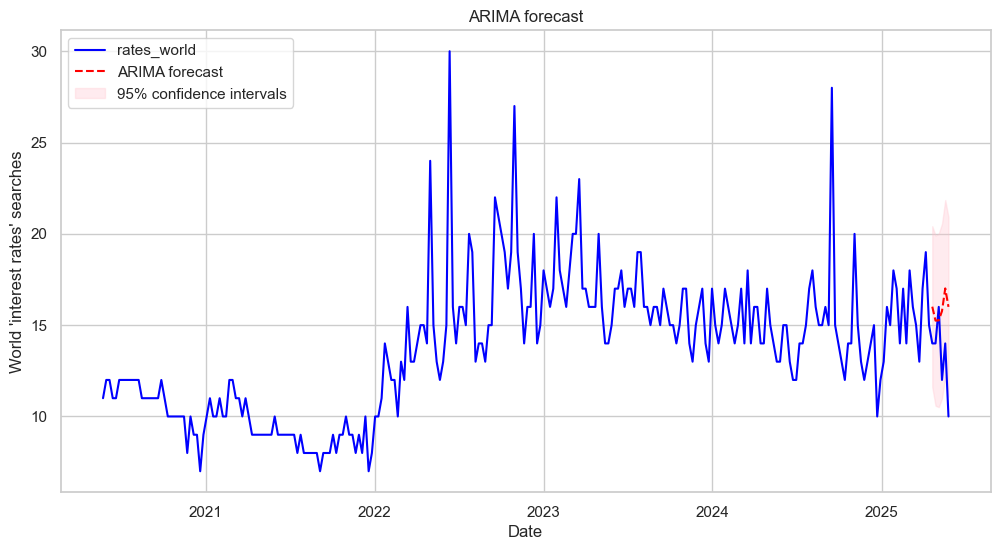

In [139]:
plt.figure(figsize=(12, 6))

# Plotting the true values (in-sample, out-of-sample)
plt.plot(final_df.index,
         final_df["rates_world"],
         label="rates_world",
         color="blue",
         linestyle="-")

# Plotting the forecast
plt.plot(final_df.index,
         final_df["forecast"],
         label="ARIMA forecast",
         color="red",
         linestyle="dashed")

# Plotting the confidence intervals
plt.fill_between(final_df.index,
                 final_df["lower_CI"],
                 final_df["upper_CI"],
                 color='pink',
                 alpha=0.3,
                 label="95% confidence intervals")

plt.title("ARIMA forecast")
plt.xlabel("Date")
plt.ylabel("World 'interest rates' searches")
plt.legend()
plt.grid(True)

plt.show()

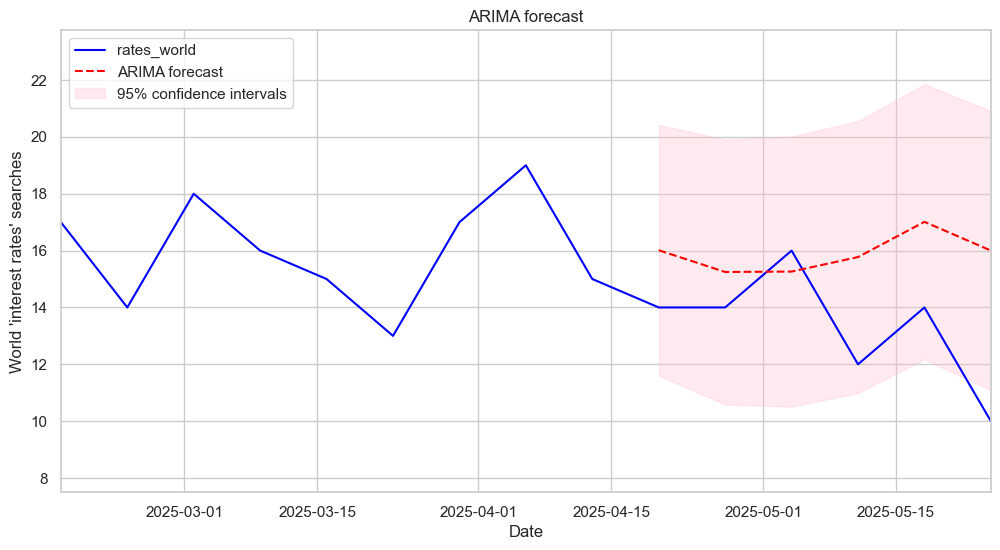

In [140]:
plt.figure(figsize=(12, 6))

# Plotting the true values (in-sample, out-of-sample)
plt.plot(final_df.index,
         final_df["rates_world"],
         label="rates_world",
         color="blue",
         linestyle="-")

# Plotting the forecast
plt.plot(final_df.index,
         final_df["forecast"],
         label="ARIMA forecast",
         color="red",
         linestyle="dashed")

# Plotting the confidence intervals
plt.fill_between(final_df.index,
                 final_df["lower_CI"],
                 final_df["upper_CI"],
                 color='pink',
                 alpha=0.3,
                 label="95% confidence intervals")

plt.title("ARIMA forecast")
plt.xlabel("Date")
plt.ylabel("World 'interest rates' searches")
plt.legend()
plt.grid(True)

# Here, we zoom the plot by putting limits on X and Y axes values
plt.xlim(final_df.index[-15], final_df.index[-1])
plt.ylim(final_df.tail(15)["rates_world"].min() * 0.75, final_df.tail(15)["rates_world"].max() * 1.25)


plt.show()

In [141]:
true_values = forecast_df["rates_world"].values
forecast_values = forecast_df["forecast"].values
n = len(forecast_values)

# 1. MAE (Mean Absolute Error)
mae = np.sum(np.abs(true_values - forecast_values)) / n

# 2. RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.sum((true_values - forecast_values) ** 2) / n)

# 3. MAPE (Mean Absolute Percentage Error)
mape = np.sum(np.abs((true_values - forecast_values) / true_values)) / n * 100

# 4. AMAPE (Adjusted Mean Absolute Percentage Error)
epsilon = 1e-8  # Small value to avoid division by zero
amape = np.sum(np.abs((true_values - forecast_values) / (np.abs(true_values) + epsilon))) / n * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"AMAPE: {amape:.2f}%")


MAE: 2.80
RMSE: 3.30
MAPE: 23.48%
AMAPE: 23.48%


Mortgage

In [142]:
arimaM111 = ARIMA(data_train_short['mortgage_world'].values, order=(1,1,1))
results_M111 = arimaM111.fit()

# Print the model summary
print("\n ARIMA Model Summary")
print(results_M111.summary())


 ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  256
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -786.801
Date:                Fri, 04 Jul 2025   AIC                           1579.602
Time:                        22:40:14   BIC                           1590.226
Sample:                             0   HQIC                          1583.875
                                - 256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3611      0.116      3.101      0.002       0.133       0.589
ma.L1         -0.7059      0.095     -7.450      0.000      -0.892      -0.520
sigma2        27.9988      2.0

In [143]:
forecast_results = results_M111.get_forecast(steps=6)

# Point forecast
forecast_values = forecast_results.predicted_mean

# Confidence (by default 95%) intervals of the point forecast
confidence_intervals = forecast_results.conf_int()

forecast_df = pd.DataFrame({
    "forecast": forecast_values,
    "lower_CI": confidence_intervals[:, 0],
    "upper_CI": confidence_intervals[:, 1],
    "mortgage_world": data_test['mortgage_world']
}, index=data_test.index)

forecast_df

forecast      lower_CI      upper_CI  mortgage_world
Date                                                                
2025-04-20 69.6970411206 59.3261069438 80.0679752974              64
2025-04-27 70.3097669880 57.9114294888 82.7081044872              68
2025-05-04 70.5309949736 56.9662955568 84.0956943904              66
2025-05-11 70.6108705333 56.1412737308 85.0804673358              63
2025-05-18 70.6397100358 55.3730814673 85.9063386043              61
2025-05-25 70.6501226940 54.6444190077 86.6558263803              42

In [144]:
final_df = pd.concat([data_train_short['mortgage_world'], forecast_df], axis=0)

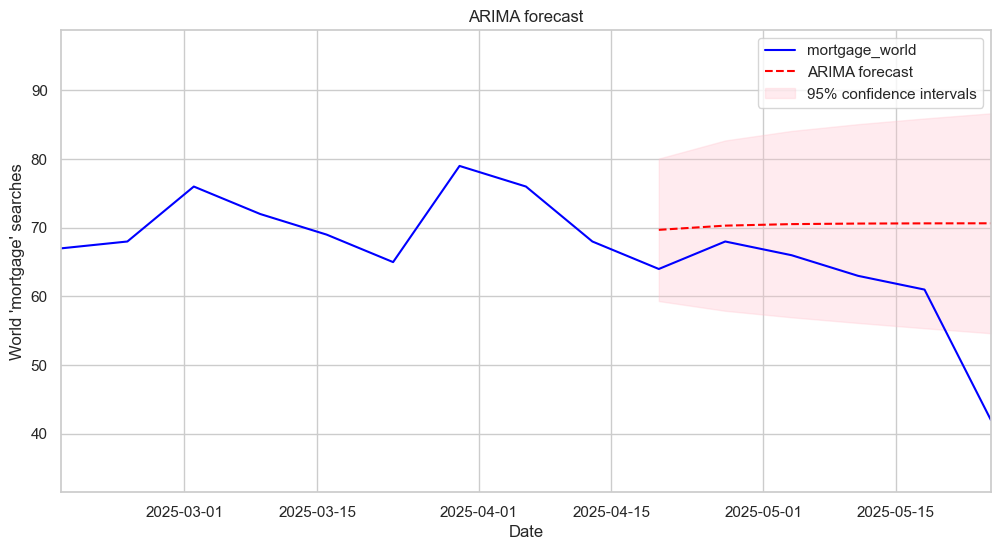

In [145]:
plt.figure(figsize=(12, 6))

# Plotting the true values (in-sample, out-of-sample)
plt.plot(final_df.index,
         final_df["mortgage_world"],
         label="mortgage_world",
         color="blue",
         linestyle="-")

# Plotting the forecast
plt.plot(final_df.index,
         final_df["forecast"],
         label="ARIMA forecast",
         color="red",
         linestyle="dashed")

# Plotting the confidence intervals
plt.fill_between(final_df.index,
                 final_df["lower_CI"],
                 final_df["upper_CI"],
                 color='pink',
                 alpha=0.3,
                 label="95% confidence intervals")

plt.title("ARIMA forecast")
plt.xlabel("Date")
plt.ylabel("World 'mortgage' searches")
plt.legend()
plt.grid(True)

# Here, we zoom the plot by putting limits on X and Y axes values
plt.xlim(final_df.index[-15], final_df.index[-1])
plt.ylim(final_df.tail(15)["mortgage_world"].min() * 0.75, final_df.tail(15)["mortgage_world"].max() * 1.25)


plt.show()

The ARIMA forecast for rates tends to slightly underpredict in the final two weeks, suggesting it may not capture short-term volatility as effectively as VAR.

In [146]:
true_values = forecast_df["mortgage_world"].values
forecast_values = forecast_df["forecast"].values
n = len(forecast_values)

# 1. MAE (Mean Absolute Error)
mae = np.sum(np.abs(true_values - forecast_values)) / n

# 2. RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.sum((true_values - forecast_values) ** 2) / n)

# 3. MAPE (Mean Absolute Percentage Error)
mape = np.sum(np.abs((true_values - forecast_values) / true_values)) / n * 100

# 4. AMAPE (Adjusted Mean Absolute Percentage Error)
epsilon = 1e-8  # Small value to avoid division by zero
amape = np.sum(np.abs((true_values - forecast_values) / (np.abs(true_values) + epsilon))) / n * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"AMAPE: {amape:.2f}%")

MAE: 9.74
RMSE: 13.10
MAPE: 19.21%
AMAPE: 19.21%


## <a id="Model-Comparison"></a>Model Comparison

### <a id="Morgage-Rates"></a>Mortgage Rates - VAR (6) & ARIMA (1,1,1)

In [147]:
def generate_markdown_table(headers, data, align='left'):
    """
    Generates a Markdown table string.

    Args:
        headers (list): A list of strings for the table headers.
        data (list of lists): A list of lists, where each inner list represents a row of data.
        align (str or list): 'left', 'center', 'right' for all columns, or a list of
                              'left', 'center', 'right' for each column.

    Returns:
        str: The Markdown table string.
    """
    if not headers:
        return ""
    if not data:
        # Just headers if no data
        header_line = "| " + " | ".join(headers) + " |"
        separator_line = "|---" * len(headers) + "|"
        return f"{header_line}\n{separator_line}"

    # Determine column widths for consistent formatting (optional but good for readability)
    col_widths = [len(header) for header in headers]
    for row in data:
        for i, cell in enumerate(row):
            col_widths[i] = max(col_widths[i], len(str(cell)))

    # Handle alignment
    if isinstance(align, str):
        align_list = [align] * len(headers)
    elif isinstance(align, list) and len(align) == len(headers):
        align_list = align
    else:
        raise ValueError("Align must be 'left', 'center', 'right' or a list of these for each column.")

    # Build the header line
    header_parts = []
    for i, header in enumerate(headers):
        header_parts.append(f"{header:<{col_widths[i]}}") # Left-align header for now
    header_line = "| " + " | ".join(header_parts) + " |"

    # Build the separator line
    separator_parts = []
    for i, width in enumerate(col_widths):
        if align_list[i] == 'left':
            separator_parts.append(f":{'-' * (width - 1)}")
        elif align_list[i] == 'center':
            separator_parts.append(f":{'-' * (width - 2)}:")
        elif align_list[i] == 'right':
            separator_parts.append(f"{'-' * (width - 1)}:")
        else:
            separator_parts.append("-" * width) # Default to left if invalid align
    separator_line = "| " + " | ".join(separator_parts) + " |"

    # Build the data rows
    data_lines = []
    for row in data:
        row_parts = []
        for i, cell in enumerate(row):
            if align_list[i] == 'left':
                row_parts.append(f"{str(cell):<{col_widths[i]}}")
            elif align_list[i] == 'center':
                row_parts.append(f"{str(cell):^{col_widths[i]}}")
            elif align_list[i] == 'right':
                row_parts.append(f"{str(cell):>{col_widths[i]}}")
            else:
                row_parts.append(f"{str(cell):<{col_widths[i]}}") # Default to left
        data_lines.append("| " + " | ".join(row_parts) + " |")

    # Combine all parts
    return f"{header_line}\n{separator_line}\n" + "\n".join(data_lines)


# Data for the "x-Post Forecast Error Comparison – Mortgage" table
headers = ["Metric", "ARIMA", "VAR(6)", "Better Model"]
data = [
    ["MAE", "9.74", "4.88", "✅ VAR"],
    ["RMSE", "13.10", "8.67", "✅ VAR"],
    ["MAPE (%)", "19.21%", "10.47%", "✅ VAR"],
    ["AMAPE (%)", "19.21%", "8.80%", "✅ VAR"]
]

# Define alignment for each column:
# Metric: left
# ARIMA: right (for numbers)
# VAR(6): right (for numbers)
# Better Model: center
alignments = ['left', 'right', 'right', 'center']

# Generate the Markdown table
markdown_table = generate_markdown_table(headers, data, align=alignments)

print("### x-Post Forecast Error Comparison – Mortgage")
print(markdown_table)

### x-Post Forecast Error Comparison – Mortgage
| Metric    | ARIMA  | VAR(6) | Better Model |
| :-------- | -----: | -----: | :----------: |
| MAE       |   9.74 |   4.88 |    ✅ VAR     |
| RMSE      |  13.10 |   8.67 |    ✅ VAR     |
| MAPE (%)  | 19.21% | 10.47% |    ✅ VAR     |
| AMAPE (%) | 19.21% |  8.80% |    ✅ VAR     |


For the mortgage_world series, the VAR(6) model provides significantly more accurate forecasts than the ARIMA model, as shown by lower MAE, RMSE, MAPE, and AMAPE values.

### <a id="Interest-Rates"></a>Interest Rates - VAR (6) & ARIMA (13,1,1)

In [148]:
def generate_markdown_table(headers, data, align='left'):
    """
    Generates a Markdown table string.

    Args:
        headers (list): A list of strings for the table headers.
        data (list of lists): A list of lists, where each inner list represents a row of data.
        align (str or list): 'left', 'center', 'right' for all columns, or a list of
                              'left', 'center', 'right' for each column.

    Returns:
        str: The Markdown table string.
    """
    if not headers:
        return ""
    if not data:
        # Just headers if no data
        header_line = "| " + " | ".join(headers) + " |"
        separator_line = "|---" * len(headers) + "|"
        return f"{header_line}\n{separator_line}"

    # Determine column widths for consistent formatting (optional but good for readability)
    col_widths = [len(header) for header in headers]
    for row in data:
        for i, cell in enumerate(row):
            col_widths[i] = max(col_widths[i], len(str(cell)))

    # Handle alignment
    if isinstance(align, str):
        align_list = [align] * len(headers)
    elif isinstance(align, list) and len(align) == len(headers):
        align_list = align
    else:
        raise ValueError("Align must be 'left', 'center', 'right' or a list of these for each column.")

    # Build the header line
    header_parts = []
    for i, header in enumerate(headers):
        header_parts.append(f"{header:<{col_widths[i]}}") # Left-align header for now
    header_line = "| " + " | ".join(header_parts) + " |"

    # Build the separator line
    separator_parts = []
    for i, width in enumerate(col_widths):
        if align_list[i] == 'left':
            separator_parts.append(f":{'-' * (width - 1)}")
        elif align_list[i] == 'center':
            separator_parts.append(f":{'-' * (width - 2)}:")
        elif align_list[i] == 'right':
            separator_parts.append(f"{'-' * (width - 1)}:")
        else:
            separator_parts.append("-" * width) # Default to left if invalid align
    separator_line = "| " + " | ".join(separator_parts) + " |"

    # Build the data rows
    data_lines = []
    for row in data:
        row_parts = []
        for i, cell in enumerate(row):
            if align_list[i] == 'left':
                row_parts.append(f"{str(cell):<{col_widths[i]}}")
            elif align_list[i] == 'center':
                row_parts.append(f"{str(cell):^{col_widths[i]}}")
            elif align_list[i] == 'right':
                row_parts.append(f"{str(cell):>{col_widths[i]}}")
            else:
                row_parts.append(f"{str(cell):<{col_widths[i]}}") # Default to left
        data_lines.append("| " + " | ".join(row_parts) + " |")

    # Combine all parts
    return f"{header_line}\n{separator_line}\n" + "\n".join(data_lines)


# Data for the "Ex-Post Forecast Error Comparison – Interest Rates" table
headers = ["Metric", "ARIMA", "VAR(6)", "Better Model"]
data = [
    ["MAE", "2.80", "4.88", "✅ ARIMA"],
    ["RMSE", "3.30", "2.32", "✅ VAR"],
    ["MAPE (%)", "23.48%", "15.58%", "✅ VAR"],
    ["AMAPE (%)", "23.48%", "13.64%", "✅ VAR"]
]

# Define alignment for each column:
# Metric: left
# ARIMA: right (for numbers)
# VAR(6): right (for numbers)
# Better Model: center
alignments = ['left', 'right', 'right', 'center']

# Generate the Markdown table
markdown_table = generate_markdown_table(headers, data, align=alignments)

# Print the table with a title
print("### Ex-Post Forecast Error Comparison – Interest Rates")
print(markdown_table)

### Ex-Post Forecast Error Comparison – Interest Rates
| Metric    | ARIMA  | VAR(6) | Better Model |
| :-------- | -----: | -----: | :----------: |
| MAE       |   2.80 |   4.88 |   ✅ ARIMA    |
| RMSE      |   3.30 |   2.32 |    ✅ VAR     |
| MAPE (%)  | 23.48% | 15.58% |    ✅ VAR     |
| AMAPE (%) | 23.48% | 13.64% |    ✅ VAR     |


For the rates_world series, the VAR(6) model achieves lower RMSE, MAPE, and AMAPE, showing better overall forecast performance for variability and percentage error. Although ARIMA has a lower MAE, the VAR model is clearly more accurate.

### <a id="Final-Results"></a>Conclusion

Overall, the VAR model in our case performs more reliably across both time series. While ARIMA provides acceptable results, its higher error metrics and signs of autocorrelation in residuals make it less suitable for short-term forecasting.